# CellOracle PART II: GRN Analysis

In [ ]:
import pandas as pd
import numpy as np
np.random.seed(0)
import sklearn
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
# %matplotlib inline
import os
import time
from IPython.core.interactiveshell import InteractiveShell
import scanpy as sc
from collections import Counter
from scipy.stats import spearmanr
from itertools import chain


import celloracle as co
from celloracle import motif_analysis as ma
from celloracle.utility import save_as_pickled_object
co.__version__


InteractiveShell.ast_node_interactivity = "all"
import gc
gc.collect()

sc.settings.verbosity = 3          # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=150, dpi_save = 300, transparent = 'False', color_map = 'viridis')
sns.set_style("whitegrid")#, {"axes.facecolor": "0.93"})
sns.set_palette('Spectral')
sns.set_context('talk')

# visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300


save_folder = "figures"
os.makedirs(save_folder, exist_ok=True)

earthy_pal_ordered = ["#2C5241","#528670","#81b29a","#a0c9e2","#789FBD",
                      "#5f7893","#3d405b","#634A5B","#88535a","#d26559",
                      "#ef8264","#F1A77A","#f2cc8f","#C8A6A3"]
sns.color_palette(earthy_pal_ordered)
earthy_pal = ["#ef8264", "#3d405b","#81b29a","#f2cc8f","#789FBD",
              "#88535a","#C8A6A3","#F1A77A","#528670","#a0c9e2",
              "#BB6157","#5f7893","#634A5B","#2C5241"]
sns.color_palette(earthy_pal)


## Configure paths and plots

In [4]:
homeDir = os.getenv("HOME")

In [5]:
homeDir

'/group/testa/Users/alessandro.vitriolo/dockerbase8'

In [6]:
import yaml
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
with open(homeDir+"/utils/rcParams.yaml") as f:
    rcParamsDict = yaml.full_load(f)
    for k in rcParamsDict["rcParams"]:
        print("{} {}".format(k,rcParamsDict["rcParams"][k]))
        plt.rcParams[k] = rcParamsDict["rcParams"][k]
    for k1 in set(list(rcParamsDict)).difference(set(["rcParams"])):
        print("{} {}".format(k1,rcParamsDict[k1]))
import matplotlib.pyplot as plt

scanpy==1.9.1 anndata==0.9.2 umap==0.5.3 numpy==1.20.2 scipy==1.6.3 pandas==1.2.4 scikit-learn==1.1.1 statsmodels==0.13.2 python-igraph==0.11.4 louvain==0.8.2 pynndescent==0.5.7
figure.dpi 100
savefig.dpi 300
figure.figsize [4, 4]
axes.facecolor None
figure.facecolor None
font.size 10
image.cmap viridis
dotSize 10


In [7]:
  = homeDir
figdir = "./figures"
resultsdir = "./results"

if not os.path.exists(outdir):
   # Create a new directory because it does not exist
   os.makedirs(outdir)
    
if not os.path.exists(outdir+"/h5ad"):
   # Create a new directory because it does not exist
   os.makedirs(outdir+"/h5ad")

with open(homeDir+"/utils/colorsMap.yaml", 'r') as f:
    colorsMap = yaml.load(f, Loader=yaml.FullLoader)

if not os.path.exists(figdir):
   # Create a new directory because it does not exist
   os.makedirs(figdir)


if not os.path.exists(resultsdir):
   # Create a new directory because it does not exist
   os.makedirs(resultsdir)


In [6]:
adata = sc.read_h5ad('/group/testa/Users/marina.fuster/dockerbase/CellOracle/PostPseudoTimeFull.h5ad')

In [7]:
print(f"Cell number is :{adata.shape[0]}")
print(f"Gene number is :{adata.shape[1]}")

Cell number is :223360
Gene number is :19914


In [8]:
# Base GRN
base_GRN = pd.read_parquet("/group/testa/Users/marina.fuster/dockerbase/CellOracle/tfi.celloracle.parquet", engine='pyarrow')
base_GRN.head()


# Check data in anndata
print("Metadata columns :", list(adata.obs.columns))
print("Dimensional reduction: ", list(adata.obsm.keys()))

# This part can be avoided

filter_result = sc.pp.filter_genes_dispersion(adata.X, # compute hvgs
                                              flavor='cell_ranger',
                                              n_top_genes=2500,
                                              log=True)

hvgs = list(adata.var_names[filter_result.gene_subset])
# add wanted genes!
# hvgs.extend(lines_sarah)
hvgs.extend(adata.var[adata.var.highly_variable].index.tolist())
hvgs = pd.Series(hvgs).unique()
len(hvgs)

hvgs = list(set(hvgs).intersection(set(adata.var_names)))
len(hvgs)

sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5,batch_key="Dataset")
hvgs = adata.var[adata.var.highly_variable].index.tolist()
adata_raw = adata.raw.to_adata()
#### Subset the genes
adata_raw = adata_raw[:, hvgs].copy()
adata_raw.var_names

gc.collect()

peak_id gene_short_name  9430076C15RIK  AC002126.6  \
0  chr10_100009478_100010332           DNMBP            0.0         0.0   
1  chr10_100045768_100046671            CHUK            0.0         0.0   
2  chr10_100045768_100046671          ERLIN1            0.0         0.0   
3  chr10_100185577_100186445          ERLIN1            0.0         0.0   
4  chr10_100229128_100229954            CHUK            0.0         0.0   

   AC012531.1  AC226150.2  AFP  AHR  AHRR  AIRE  ...  ZNF784  ZNF8  ZNF816  \
0         0.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0     0.0   
1         0.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0     0.0   
2         0.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0     0.0   
3         0.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0     0.0   
4         0.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0     0.0   

   ZNF85  ZSCAN10  ZSCAN16  ZSCAN22  ZSCAN26  ZSCAN31  ZSCAN4  
0    0.0      0.0      0.0      0.0      0.0      0.0     0.0  
1    0.0      0.0      0.0      0.0      0.0      0.0     0.0  
2    0.0      0.0      0.0      0.0      0.0      0.0     0.0  
3    0.0      0.0      0.0      0.0      0.0      0.0     0.0  
4    0.0      0.0      0.0      0.0      0.0      0.0     0.0  

[5 rows x 1096 columns]

Metadata columns : ['phase', 'stage', 'celltype2', 'Dataset', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'leiden', 'celltype', 'leiden_harmony', 'IP_score', 'GABA_score', 'astro_score', 'ERstress_score', 'glycolysis_score', 'hypoxia_score', 'Lineage1', 'Lineage2', 'Lineage3', 'Pseudotime_Lineage1', 'Pseudotime_Lineage2', 'Pseudotime_Lineage3', 'Pseudotime']
Dimensional reduction:  ['X_diffmap', 'X_draw_graph_fa', 'X_pca', 'X_umap']
extracting highly variable genes


/usr/local/lib/python3.8/dist-packages/scanpy/preprocessing/_deprecated/highly_variable_genes.py:145: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


    finished (0:00:07)


11487

11487

Index(['WDR43', 'RP11-829H16.3', 'AL133493.2', 'NCAPG', 'CCL25', 'KDELR3',
       'CTA-286B10.7', 'RP11-20I23.8', 'C17orf96', 'ARHGEF12',
       ...
       'HEPH', 'LPAR3', 'TBL1X', 'RP11-620J15.3', 'TIGD4', 'PNPLA7', 'L1TD1',
       'AP000275.65', 'RP11-527D7.1', 'PTCHD4'],
      dtype='object', length=11487)

35807

In [10]:
os.chdir('/group/testa/Project/CBOProgPools/CellOracle/')

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`
categories: 0, 1, 2, etc.
var_group_labels: astrocytes, pericyte, microglia, etc.


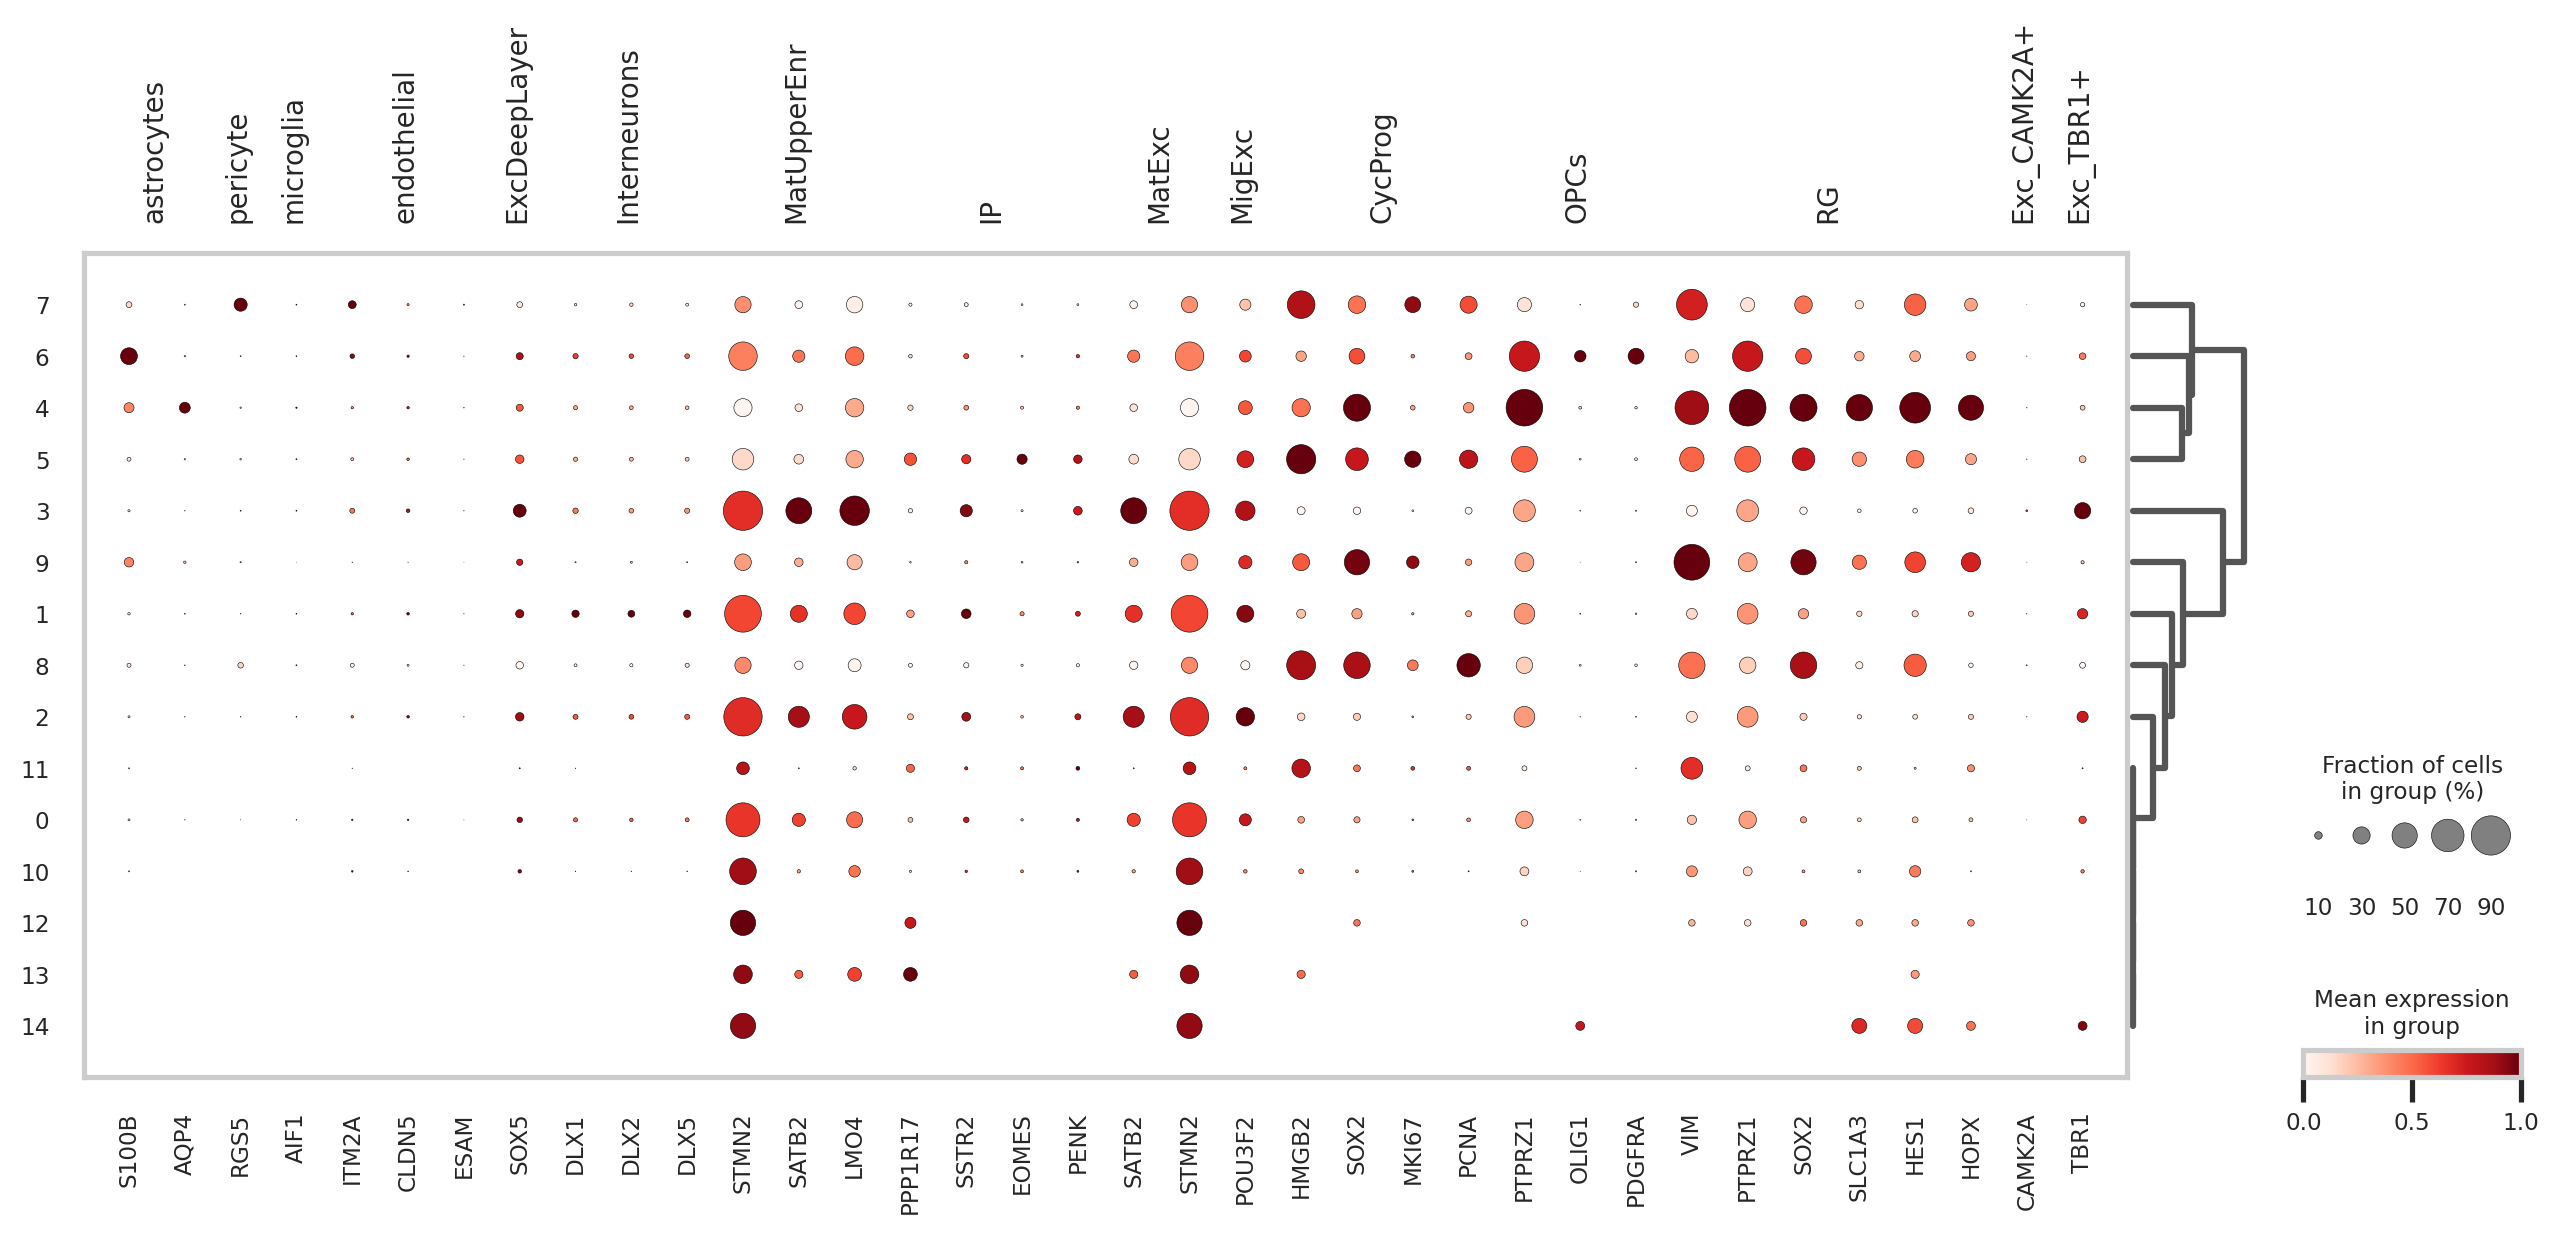

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_celltype']`
categories: MatUpp, oRG, vRG, etc.
var_group_labels: astrocytes, pericyte, microglia, etc.


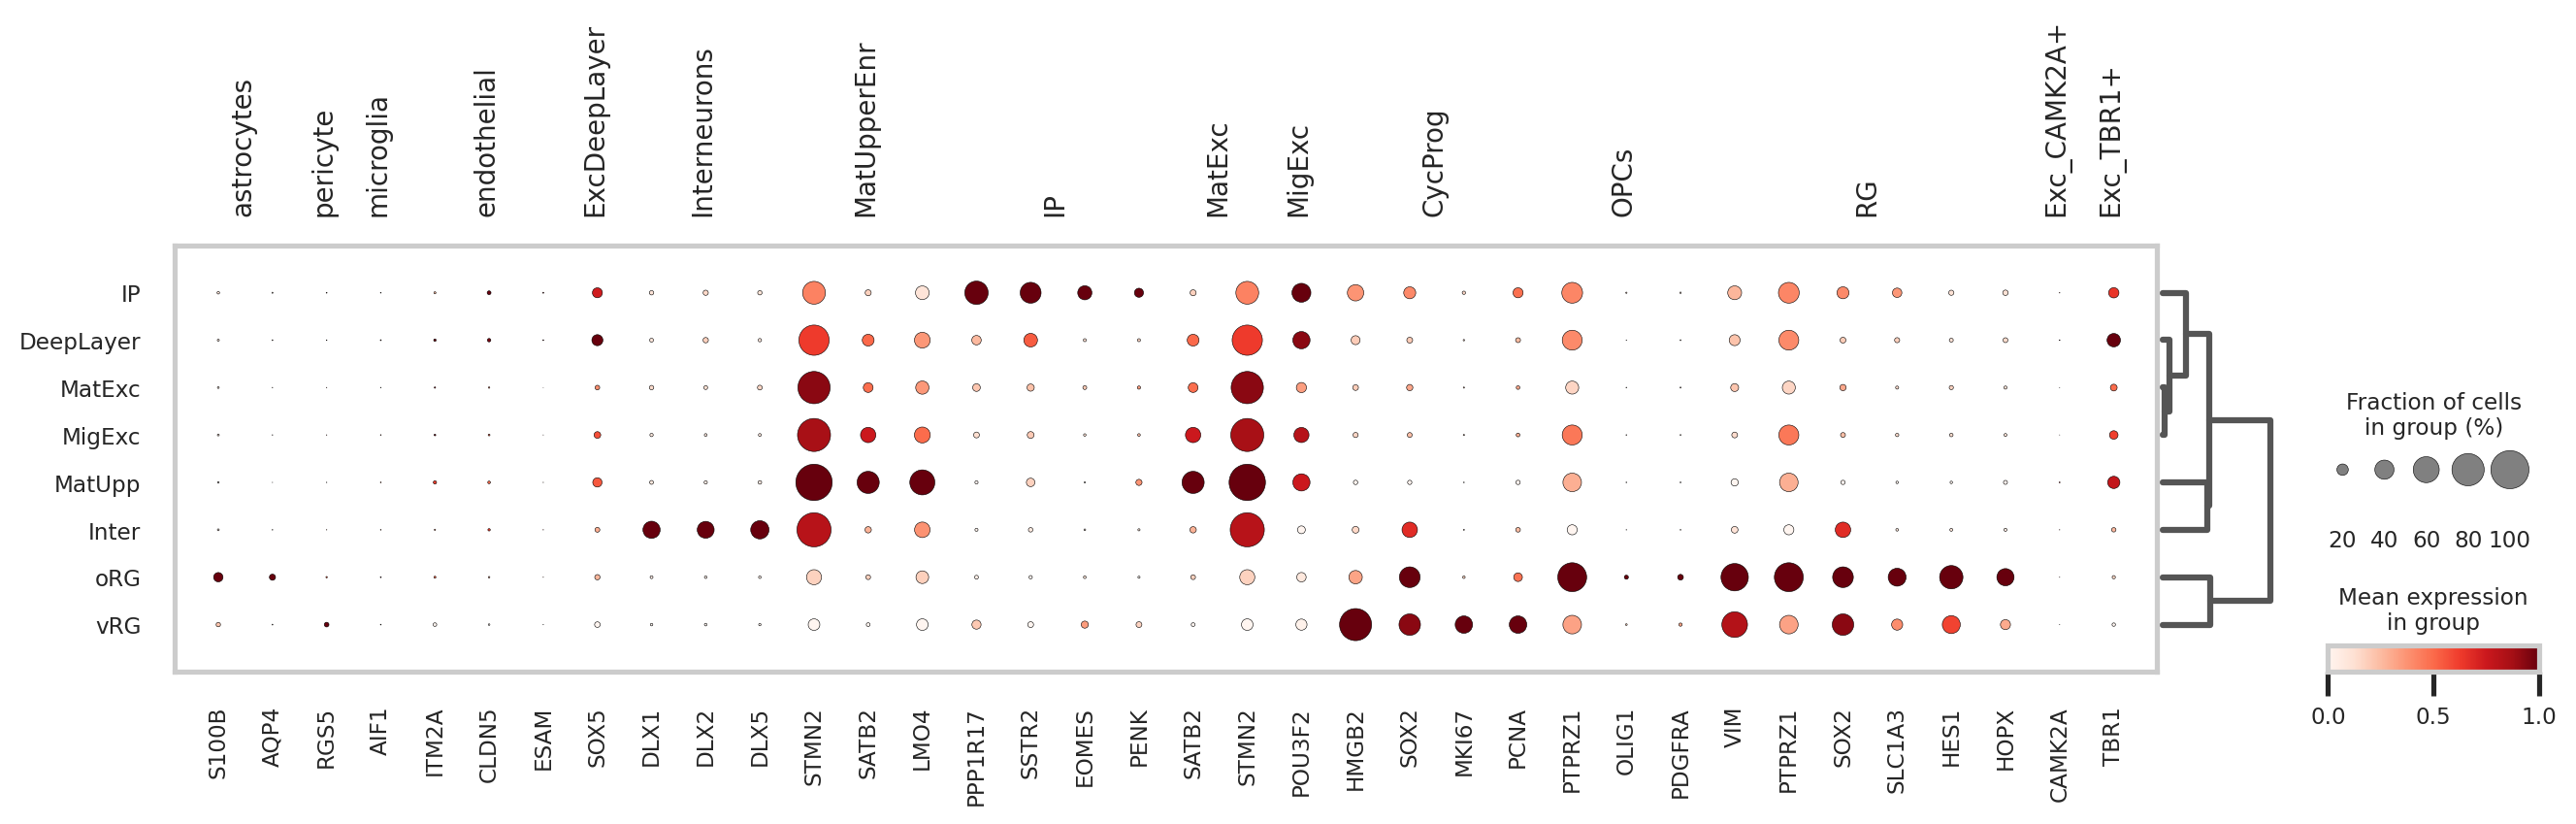

In [11]:
all_dict = {
  'astrocytes' : ['S100B','AQP4'],
  'pericyte' : ['RGS5'],
  'microglia' : ['AIF1'],
  'endothelial' : ['ITM2A','CLDN5','ESAM'],
  'ExcDeepLayer' : ['SOX5'],
  'Interneurons' : ['DLX1','DLX2','DLX5'],
  'MatUpperEnr' : ['STMN2','SATB2','LMO4'],
  'IP' : ['PPP1R17','SSTR2','EOMES','PENK'],
  'MatExc' : ['SATB2','STMN2'],
  'MigExc' : ['POU3F2'],
  'CycProg' : ['HMGB2','SOX2','MKI67','PCNA'],
  'OPCs' : ['PTPRZ1','OLIG1','PDGFRA'],
  'RG' : ['VIM','PTPRZ1','SOX2','SLC1A3','HES1','HOPX'],
  'Exc_CAMK2A+' : ['CAMK2A'],
  'Exc_TBR1+' : ['TBR1']
}
sc.tl.dendrogram(adata,'leiden')
sc.pl.dotplot(adata, all_dict , 'leiden', dendrogram=True,save="2024_06_06_markersDotplot_leiden",use_raw=False,log=True,standard_scale='var')

sc.tl.dendrogram(adata,'celltype')
sc.pl.dotplot(adata, all_dict , 'celltype', dendrogram=True,save="2024_06_06_markersDotplot_CellTypes",use_raw=False,log=True,standard_scale='var')

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_celltype']`


/group/testa/Users/marina.fuster/hpc_vm/.local/lib/python3.8/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)


categories: ExcMat, MatUpp, Mixed, etc.
var_group_labels: astrocytes, pericyte, microglia, etc.


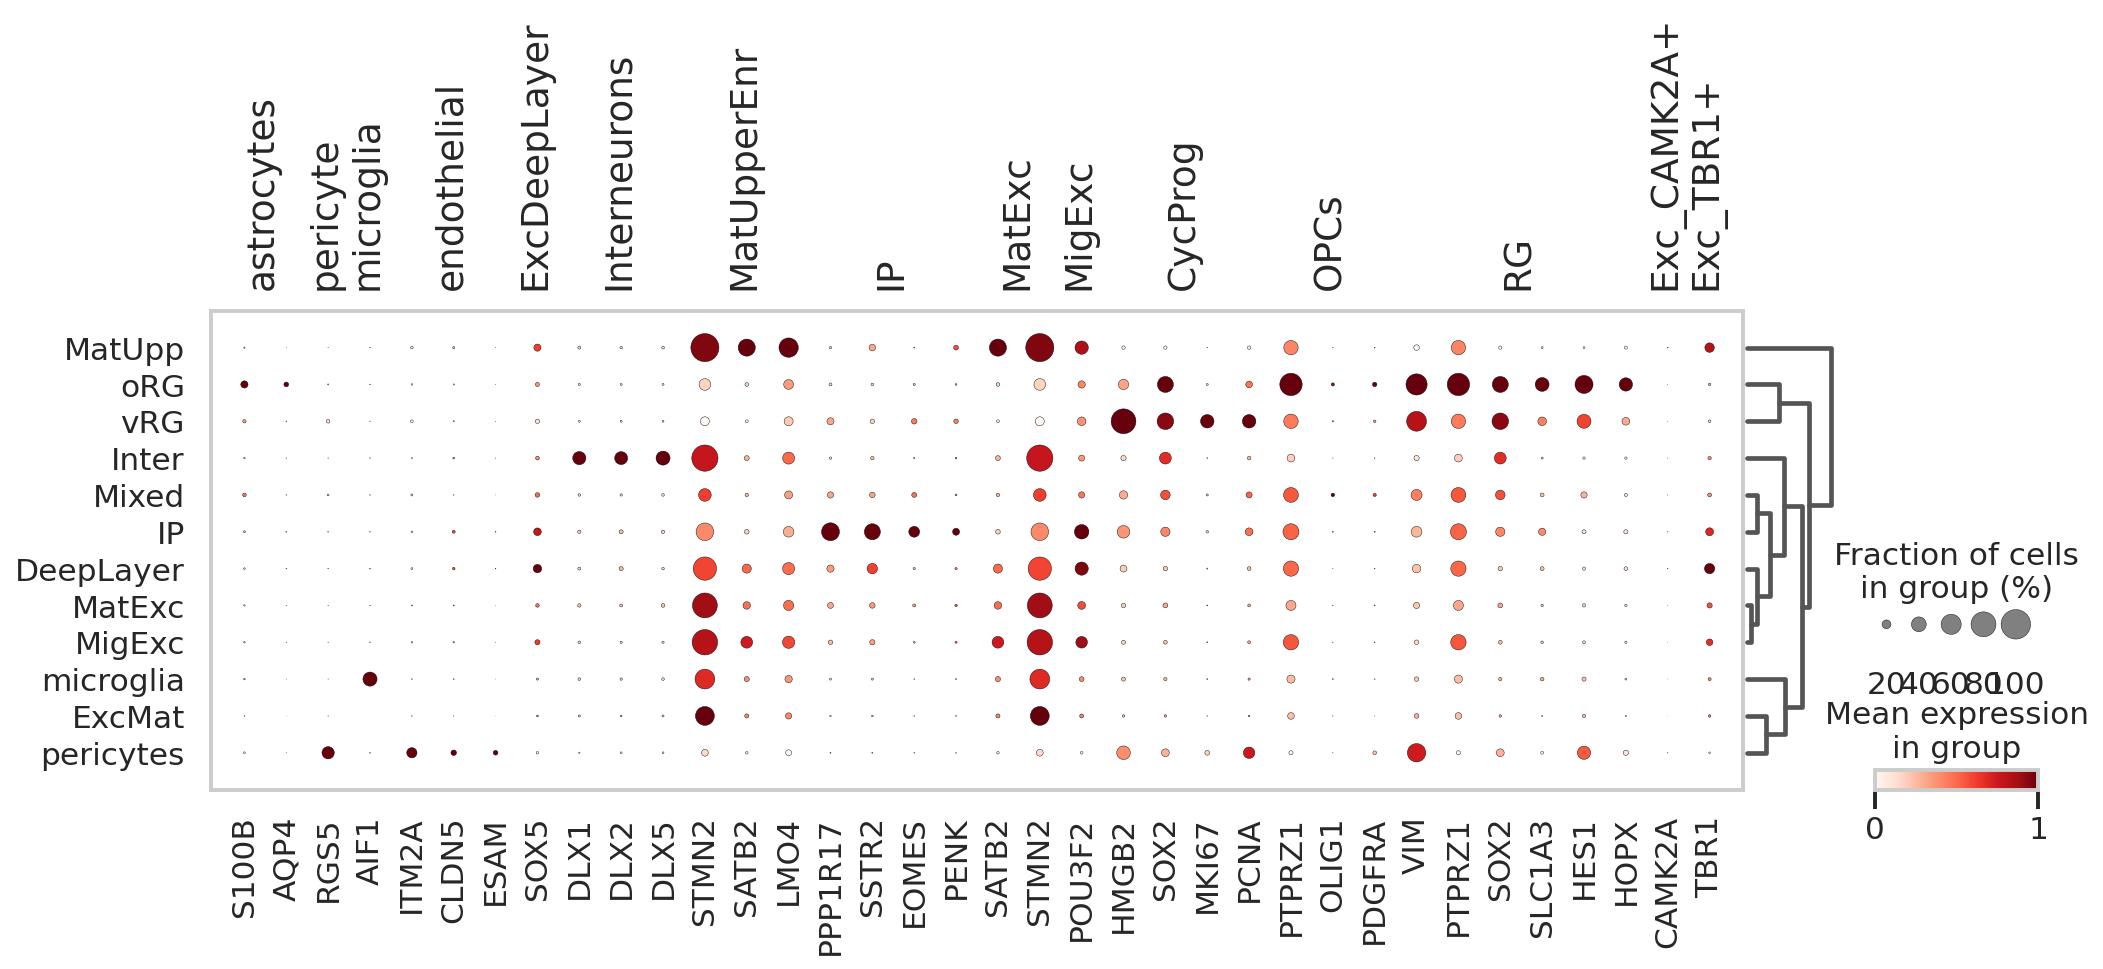

In [2]:
tempo = sc.read_h5ad("/group/testa/Users/marina.fuster/dockerbase/ResultsOracle/results_plot_draw_graph.h5ad")
all_dict = {
  'astrocytes' : ['S100B','AQP4'],
  'pericyte' : ['RGS5'],
  'microglia' : ['AIF1'],
  'endothelial' : ['ITM2A','CLDN5','ESAM'],
  'ExcDeepLayer' : ['SOX5'],
  'Interneurons' : ['DLX1','DLX2','DLX5'],
  'MatUpperEnr' : ['STMN2','SATB2','LMO4'],
  'IP' : ['PPP1R17','SSTR2','EOMES','PENK'],
  'MatExc' : ['SATB2','STMN2'],
  'MigExc' : ['POU3F2'],
  'CycProg' : ['HMGB2','SOX2','MKI67','PCNA'],
  'OPCs' : ['PTPRZ1','OLIG1','PDGFRA'],
  'RG' : ['VIM','PTPRZ1','SOX2','SLC1A3','HES1','HOPX'],
  'Exc_CAMK2A+' : ['CAMK2A'],
  'Exc_TBR1+' : ['TBR1']
}
sc.tl.dendrogram(tempo,'celltype')
sc.pl.dotplot(tempo, all_dict , 'celltype', dendrogram=True,save="2024_06_06_markersDotplot_celltype_tempo",use_raw=False,log=True,standard_scale='var')


In [12]:
oracle = co.Oracle()

oracle.import_anndata_as_raw_count(adata=adata_raw,
                                   cluster_column_name='celltype',
                                   embedding_name="X_draw_graph_fa")


oracle.import_TF_data(TF_info_matrix=base_GRN)

oracle

11487 genes were found in the adata. Note that Celloracle is intended to use around 1000-3000 genes, so the behavior with this number of genes may differ from what is expected.


Oracle object

Meta data
    celloracle version used for instantiation: 0.17.2
    n_cells: 223360
    n_genes: 11487
    cluster_name: celltype
    dimensional_reduction_name: X_draw_graph_fa
    n_target_genes_in_TFdict: 13058 genes
    n_regulatory_in_TFdict: 1094 genes
    n_regulatory_in_both_TFdict_and_scRNA-seq: 369 genes
    n_target_genes_both_TFdict_and_scRNA-seq: 5312 genes
    k_for_knn_imputation: NA
Status
    Gene expression matrix: Ready
    BaseGRN: Ready
    PCA calculation: Not finished
    Knn imputation: Not finished
    GRN calculation for simulation: Not finished

In [16]:
# Perform PCA
oracle.perform_PCA()

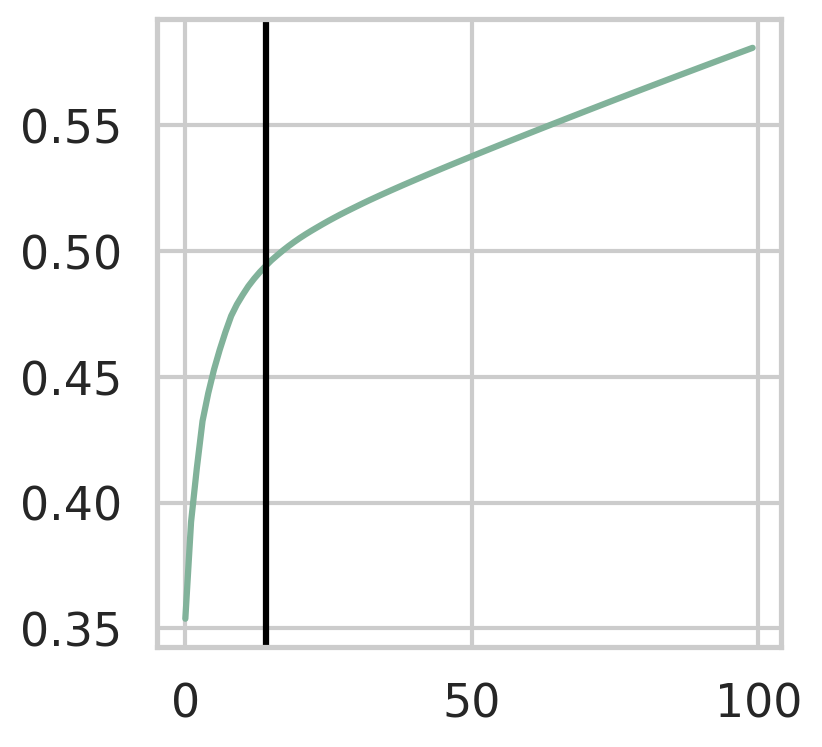

14


In [17]:
# Select important PCs
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100], color = earthy_pal[2])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
plt.show()
print(n_comps)
n_comps = min(n_comps, 50)

In [18]:
n_cell = oracle.adata.shape[0]
print(f"cell number is :{n_cell}")

k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")

cell number is :223360
Auto-selected k is :5584


In [ ]:
oracle.to_hdf5("/group/testa/Project/CBOProgPools/CellOracle/2024_06_08_Celltype_before_Imputation.celloracle.oracle")

In [ ]:
n_comps

In [ ]:
oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8,
                      b_maxl=k*4, n_jobs=4)

In [ ]:
oracle

# Calculate GRN for each cluster.
links = oracle.get_links(cluster_name_for_GRN_unit="celltype", alpha=10,
                         verbose_level=10, )


links.links_dict.keys()

In [ ]:
oracle.to_hdf5("/group/testa/Project/CBOProgPools/CellOracle/2024_06_08_Celltype_after_Imputation.celloracle.oracle")

In [ ]:
links.to_hdf5(file_path="/group/testa/Project/CBOProgPools/CellOracle/20240608_Celltype.celloracle.links")

In [9]:
links = co.load_hdf5("/group/testa/Project/CBOProgPools/CellOracle/20240608_Celltype.celloracle.links")

In [ ]:
oracle = co.load_hdf5("/group/testa/Project/CBOProgPools/CellOracle/2024_06_08_Celltype_after_Imputation.celloracle.oracle")

In [11]:
links.links_dict.keys()

dict_keys(['DeepLayer', 'IP', 'Inter', 'MatExc', 'MatUpp', 'MigExc', 'oRG', 'vRG'])

In [12]:

links.links_dict["DeepLayer"]

# Set cluster name
cluster = "DeepLayer"

# Save as csv
links.links_dict[cluster].to_csv("GRN_DeepLayer.csv")

links.links_dict["IP"]

# Set cluster name
cluster = "IP"

# Save as csv
links.links_dict[cluster].to_csv("GRN_IP.csv")

links.links_dict["Inter"]

# Set cluster name
cluster = "Inter"

# Save as csv
links.links_dict[cluster].to_csv("GRN_Inter.csv")

links.links_dict["MatExc"]

# Set cluster name
cluster = "MatExc"

# Save as csv
links.links_dict[cluster].to_csv("GRN_MatExc.csv")

links.links_dict["MatUpp"]
# Set cluster name
cluster = "MatUpp"
# Save as csv
links.links_dict[cluster].to_csv("GRN_MatUpp.csv")

links.links_dict["MigExc"]
# Set cluster name
cluster = "MigExc"
# Save as csv
links.links_dict[cluster].to_csv("GRN_MigExc.csv")

links.links_dict["oRG"]
# Set cluster name
cluster = "oRG"
# Save as csv
links.links_dict[cluster].to_csv("GRN_oRG.csv")

links.links_dict["vRG"]
# Set cluster name
cluster = "vRG"
# Save as csv
links.links_dict[cluster].to_csv("GRN_vRG.csv")


links.to_hdf5(file_path="/group/testa/Project/CBOProgPools/CellOracle/20240608_Celltype_unfiltered.celloracle.links")

source  target     coef_mean      coef_abs             p     -logp
0         MSC   AANAT  3.901097e-07  3.901097e-07  8.358530e-01  0.077870
1      ZBTB7B   AANAT  2.316268e-06  2.316268e-06  3.227839e-01  0.491088
2       NR2E3   AANAT  6.965386e-06  6.965386e-06  1.570148e-05  4.804059
3       FOXC1   AANAT -3.665946e-05  3.665946e-05  2.435940e-05  4.613333
4        LHX4   AANAT  3.114230e-05  3.114230e-05  6.083073e-10  9.215877
...       ...     ...           ...           ...           ...       ...
72402   NANOG  ZNF860 -1.577191e-04  1.577191e-04  6.178997e-10  9.209082
72403   TCF15  ZNF860  4.154114e-06  4.154114e-06  8.007948e-01  0.096479
72404    FLI1  ZNF860 -1.773569e-04  1.773569e-04  7.684084e-08  7.114408
72405   FOXD4  ZNF860  5.768093e-04  5.768093e-04  2.306110e-07  6.637120
72406    GLI1  ZNF860  1.175159e-05  1.175159e-05  4.638051e-01  0.333665

[72407 rows x 6 columns]

source  target  coef_mean  coef_abs             p      -logp
0         MSC   AANAT  -0.000007  0.000007  1.026212e-02   1.988763
1      ZBTB7B   AANAT   0.000002  0.000002  4.447668e-01   0.351868
2       NR2E3   AANAT   0.000014  0.000014  2.234489e-08   7.650822
3       FOXC1   AANAT  -0.000084  0.000084  9.582342e-11  10.018528
4        LHX4   AANAT   0.000020  0.000020  1.590635e-06   5.798430
...       ...     ...        ...       ...           ...        ...
72402   NANOG  ZNF860  -0.000044  0.000044  2.091310e-07   6.679582
72403   TCF15  ZNF860   0.000006  0.000006  4.662030e-01   0.331425
72404    FLI1  ZNF860   0.000033  0.000033  7.397269e-03   2.130929
72405   FOXD4  ZNF860   0.000265  0.000265  1.076900e-05   4.967825
72406    GLI1  ZNF860   0.000008  0.000008  5.817952e-02   1.235230

[72407 rows x 6 columns]

source  target  coef_mean  coef_abs             p     -logp
0         MSC   AANAT  -0.000032  0.000032  2.590149e-06  5.586675
1      ZBTB7B   AANAT  -0.000022  0.000022  1.090184e-06  5.962500
2       NR2E3   AANAT   0.000002  0.000002  3.596455e-02  1.444125
3       FOXC1   AANAT  -0.000010  0.000010  2.066187e-01  0.684830
4        LHX4   AANAT   0.000022  0.000022  4.880912e-08  7.311499
...       ...     ...        ...       ...           ...       ...
72402   NANOG  ZNF860  -0.000045  0.000045  2.974079e-06  5.526648
72403   TCF15  ZNF860   0.000129  0.000129  1.849854e-05  4.732863
72404    FLI1  ZNF860   0.000076  0.000076  6.401547e-05  4.193715
72405   FOXD4  ZNF860   0.000348  0.000348  7.977203e-07  6.098149
72406    GLI1  ZNF860  -0.000004  0.000004  6.338920e-01  0.197985

[72407 rows x 6 columns]

source  target     coef_mean      coef_abs             p     -logp
0         MSC   AANAT -1.130329e-05  1.130329e-05  3.399014e-03  2.468647
1      ZBTB7B   AANAT -1.459408e-05  1.459408e-05  9.887227e-06  5.004925
2       NR2E3   AANAT  7.036095e-06  7.036095e-06  1.739932e-08  7.759468
3       FOXC1   AANAT -6.988670e-07  6.988670e-07  9.381847e-01  0.027712
4        LHX4   AANAT  1.508132e-05  1.508132e-05  2.471695e-09  8.607005
...       ...     ...           ...           ...           ...       ...
72402   NANOG  ZNF860 -5.047727e-05  5.047727e-05  2.346391e-08  7.629600
72403   TCF15  ZNF860 -3.695314e-05  3.695314e-05  3.655318e-02  1.437075
72404    FLI1  ZNF860  1.367764e-04  1.367764e-04  7.418550e-06  5.129681
72405   FOXD4  ZNF860  3.225927e-04  3.225927e-04  1.493042e-06  5.825928
72406    GLI1  ZNF860  1.013127e-05  1.013127e-05  2.325691e-01  0.633448

[72407 rows x 6 columns]

('MatUpp', 'MigExc', 'oRG', 'vRG')

source  target  coef_mean  coef_abs             p     -logp
0         MSC   AANAT  -0.000021  0.000021  5.756322e-06  5.239855
1      ZBTB7B   AANAT  -0.000015  0.000015  5.072309e-04  3.294794
2       NR2E3   AANAT   0.000007  0.000007  1.121950e-07  6.950026
3       FOXC1   AANAT  -0.000053  0.000053  1.414350e-03  2.849443
4        LHX4   AANAT   0.000023  0.000023  2.858098e-09  8.543923
...       ...     ...        ...       ...           ...       ...
72402   NANOG  ZNF860  -0.000155  0.000155  2.051896e-10  9.687845
72403   TCF15  ZNF860   0.000055  0.000055  9.974157e-02  1.001124
72404    FLI1  ZNF860  -0.000120  0.000120  2.662669e-04  3.574683
72405   FOXD4  ZNF860   0.000430  0.000430  6.914846e-07  6.160218
72406    GLI1  ZNF860   0.000009  0.000009  4.783682e-01  0.320238

[72407 rows x 6 columns]

source  target     coef_mean      coef_abs             p      -logp
0         MSC   AANAT -2.503135e-06  2.503135e-06  3.325477e-01   0.478146
1      ZBTB7B   AANAT -1.901342e-05  1.901342e-05  6.084690e-07   6.215762
2       NR2E3   AANAT  7.855175e-06  7.855175e-06  3.565592e-10   9.447868
3       FOXC1   AANAT  7.751031e-07  7.751031e-07  9.409262e-01   0.026444
4        LHX4   AANAT  1.887416e-05  1.887416e-05  3.623367e-11  10.440888
...       ...     ...           ...           ...           ...        ...
72402   NANOG  ZNF860 -5.244046e-05  5.244046e-05  2.391090e-08   7.621404
72403   TCF15  ZNF860 -6.310560e-05  6.310560e-05  3.403871e-04   3.468027
72404    FLI1  ZNF860  8.289968e-05  8.289968e-05  6.789151e-04   3.168185
72405   FOXD4  ZNF860  3.037830e-04  3.037830e-04  4.535034e-06   5.343419
72406    GLI1  ZNF860  1.053906e-05  1.053906e-05  3.602188e-01   0.443434

[72407 rows x 6 columns]

source  target     coef_mean      coef_abs             p      -logp
0         MSC   AANAT -7.525442e-06  7.525442e-06  4.159604e-04   3.380948
1      ZBTB7B   AANAT -5.502862e-07  5.502862e-07  7.360121e-01   0.133115
2       NR2E3   AANAT  1.697690e-05  1.697690e-05  1.872495e-13  12.727579
3       FOXC1   AANAT  2.743823e-05  2.743823e-05  1.345811e-04   3.871016
4        LHX4   AANAT  1.876422e-05  1.876422e-05  1.085251e-07   6.964470
...       ...     ...           ...           ...           ...        ...
72402   NANOG  ZNF860 -5.415016e-05  5.415016e-05  4.458753e-08   7.350787
72403   TCF15  ZNF860  5.535378e-05  5.535378e-05  1.325006e-04   3.877782
72404    FLI1  ZNF860  5.875974e-05  5.875974e-05  1.018464e-05   4.992054
72405   FOXD4  ZNF860  2.227213e-04  2.227213e-04  9.909757e-06   5.003937
72406    GLI1  ZNF860  3.993483e-06  3.993483e-06  3.311289e-01   0.480003

[72407 rows x 6 columns]

source  target     coef_mean      coef_abs             p      -logp
0         MSC   AANAT -1.635258e-05  1.635258e-05  3.465132e-06   5.460280
1      ZBTB7B   AANAT -1.778092e-06  1.778092e-06  5.188348e-01   0.284971
2       NR2E3   AANAT  1.742196e-05  1.742196e-05  3.772947e-12  11.423319
3       FOXC1   AANAT  1.519057e-05  1.519057e-05  1.381862e-02   1.859535
4        LHX4   AANAT  2.292947e-05  2.292947e-05  1.027479e-07   6.988227
...       ...     ...           ...           ...           ...        ...
72402   NANOG  ZNF860 -4.833237e-05  4.833237e-05  1.038882e-06   5.983434
72403   TCF15  ZNF860  8.244485e-05  8.244485e-05  8.515302e-08   7.069800
72404    FLI1  ZNF860  5.011696e-05  5.011696e-05  7.758166e-06   5.110241
72405   FOXD4  ZNF860  1.861837e-04  1.861837e-04  1.005336e-06   5.997689
72406    GLI1  ZNF860 -8.835032e-07  8.835032e-07  8.364329e-01   0.077569

[72407 rows x 6 columns]

DeepLayer


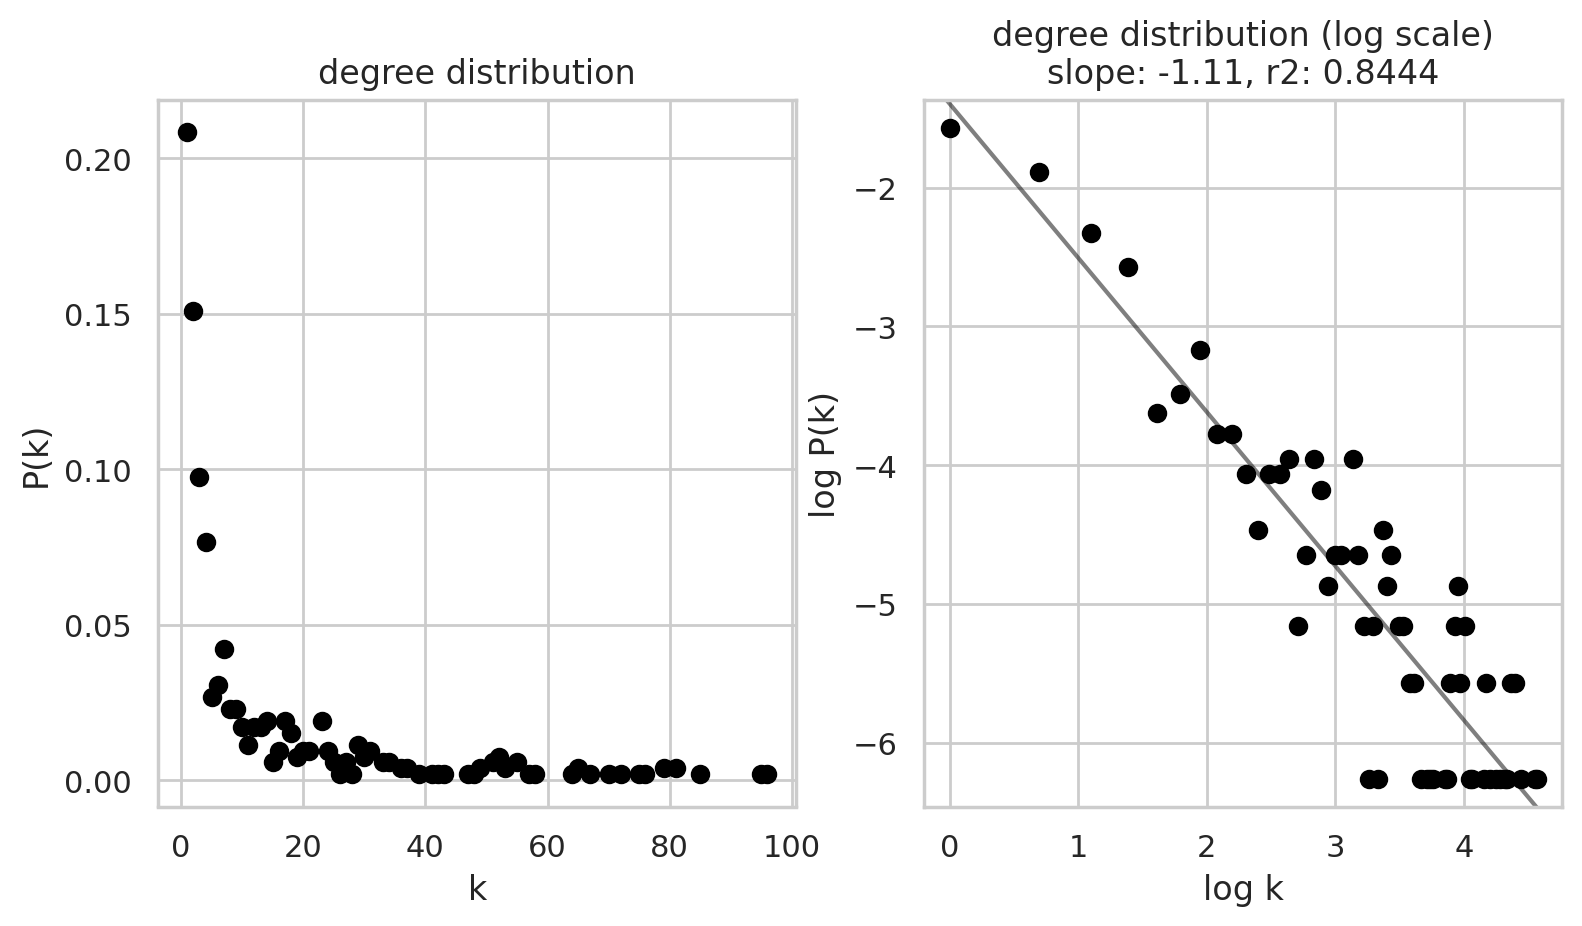

IP


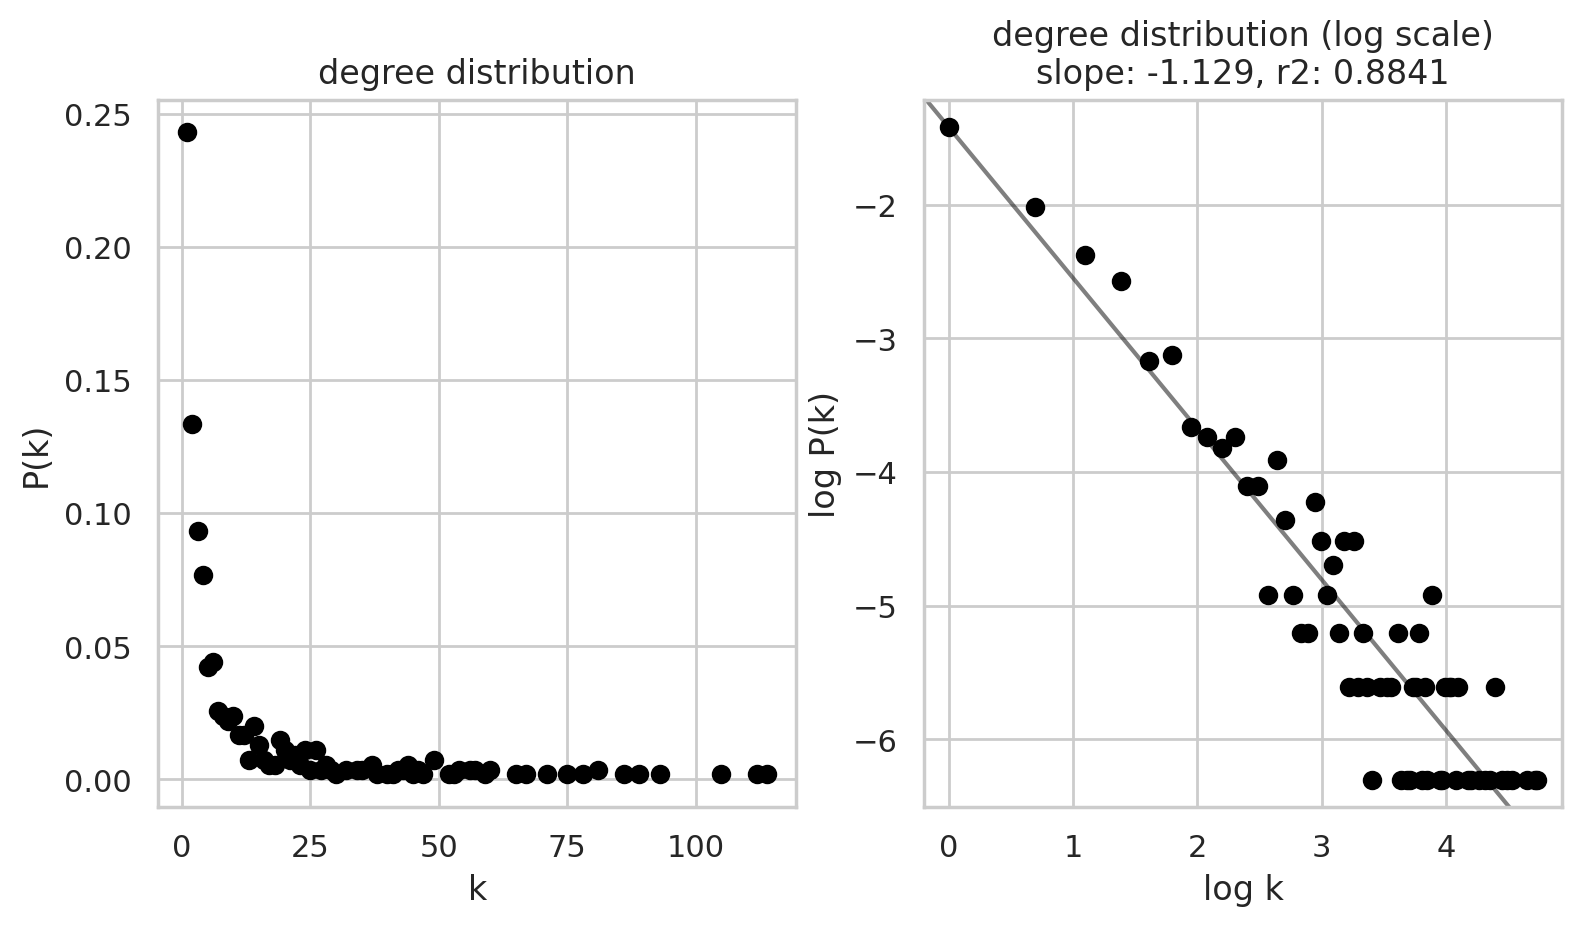

Inter


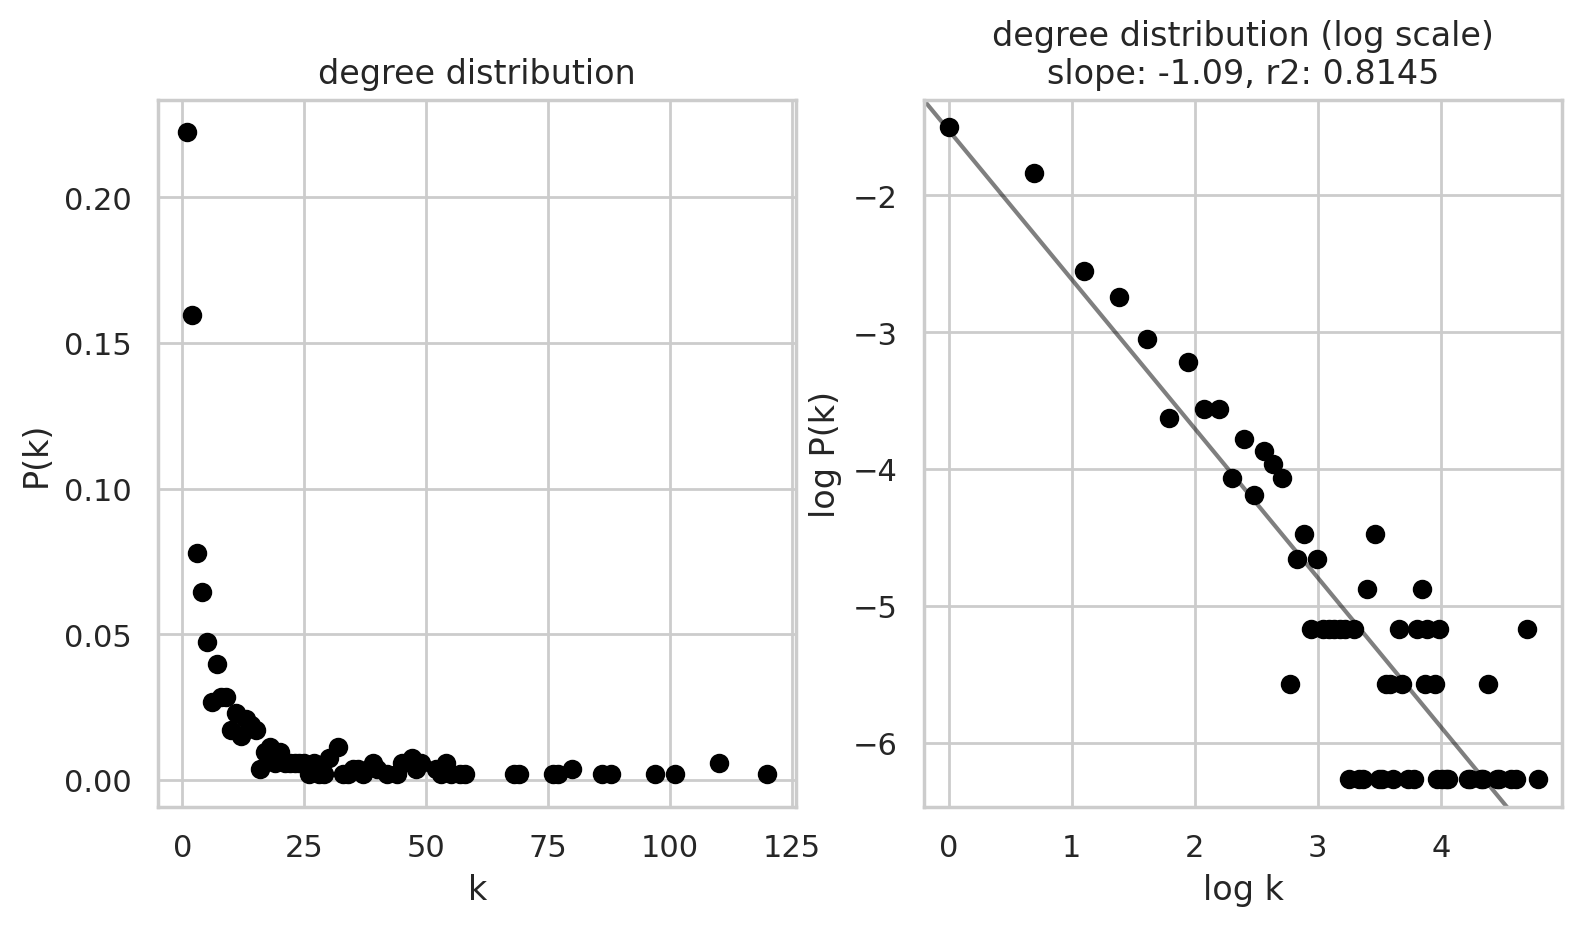

MatExc


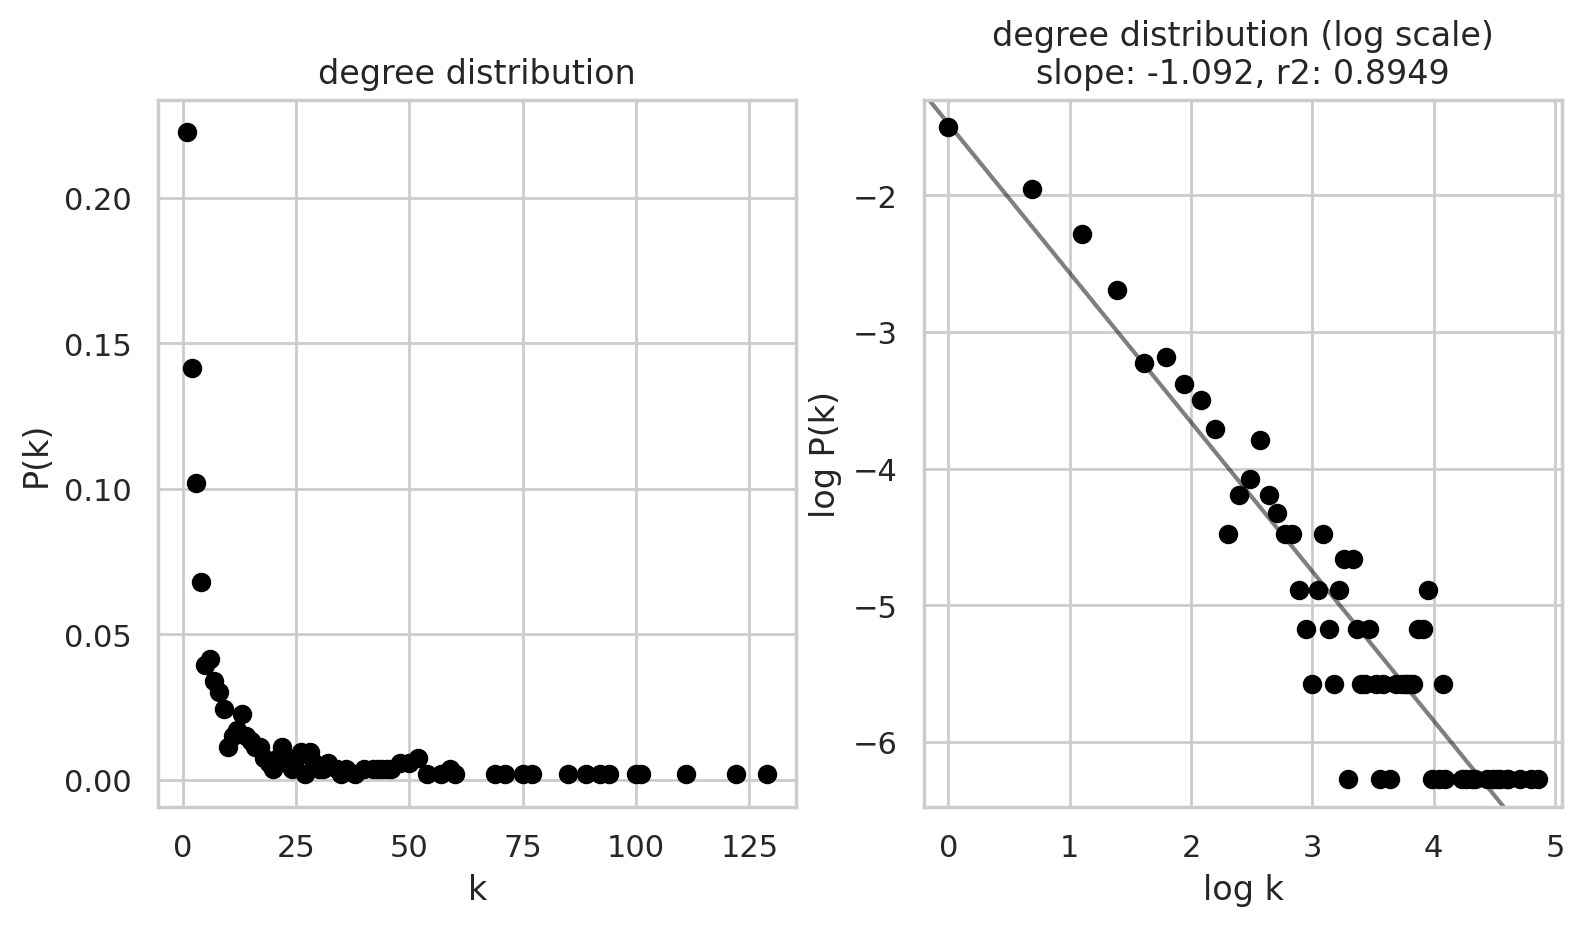

MatUpp


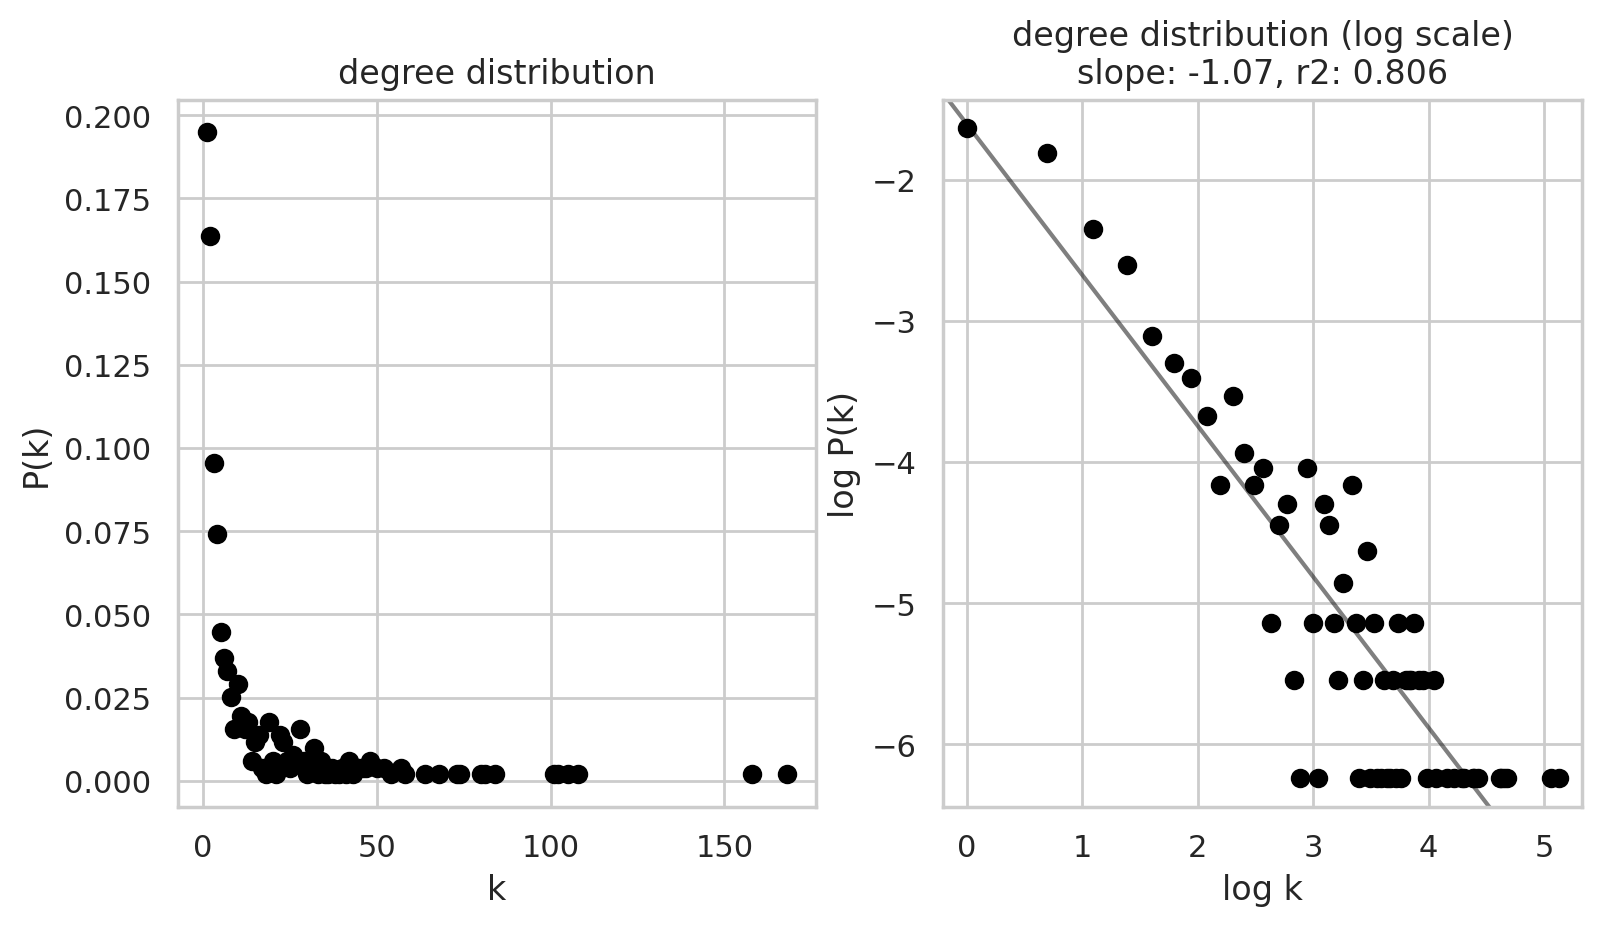

MigExc


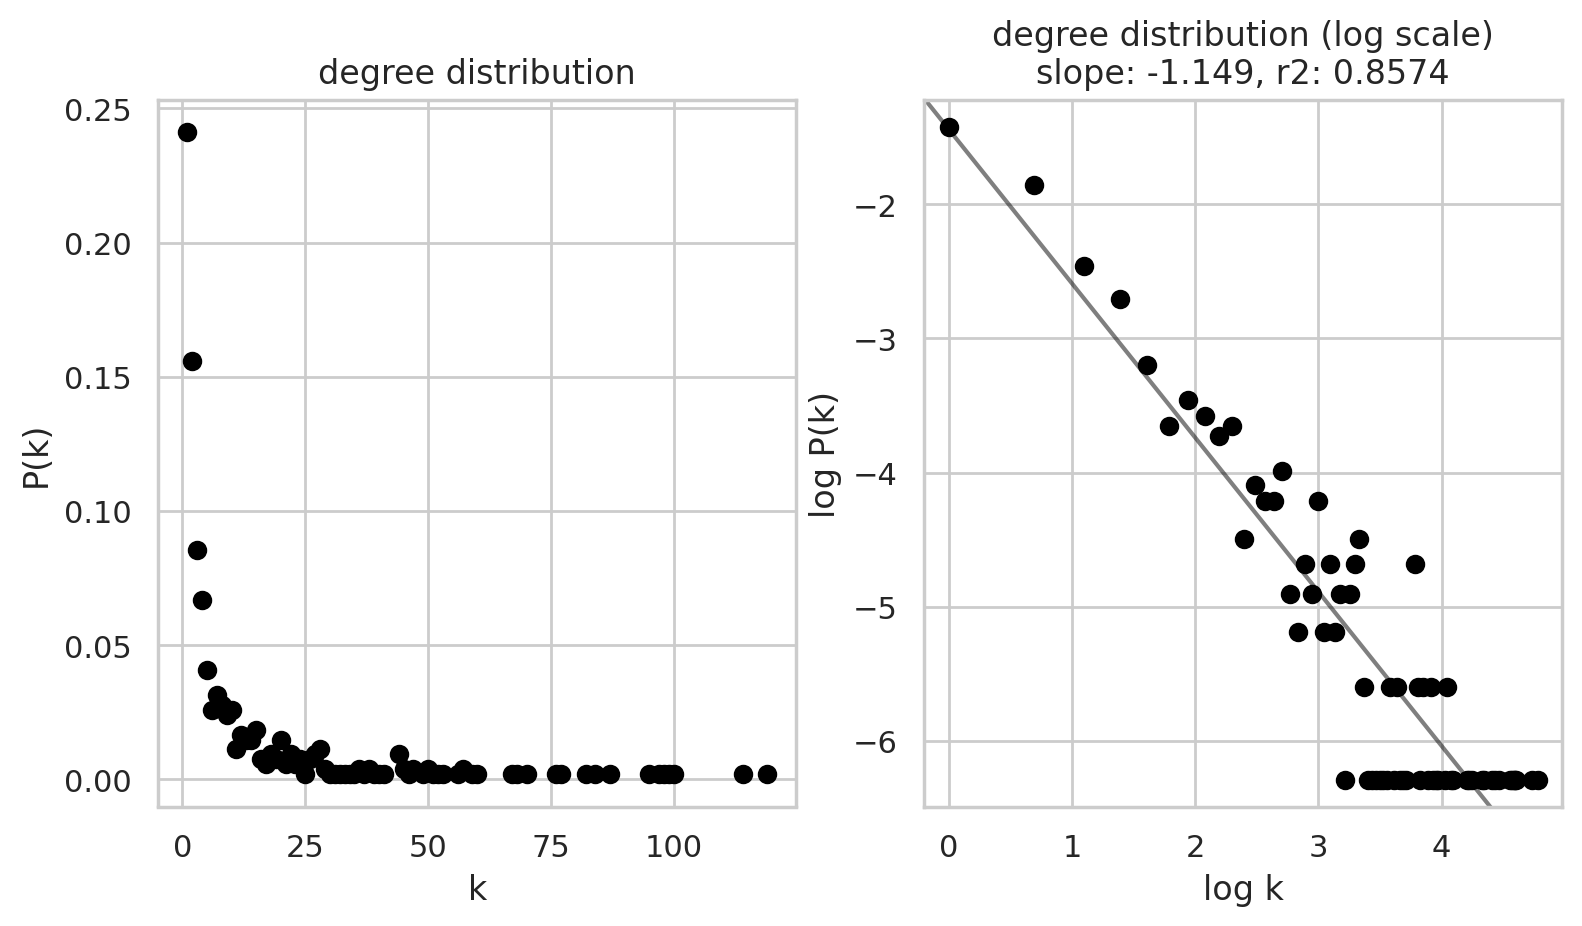

oRG


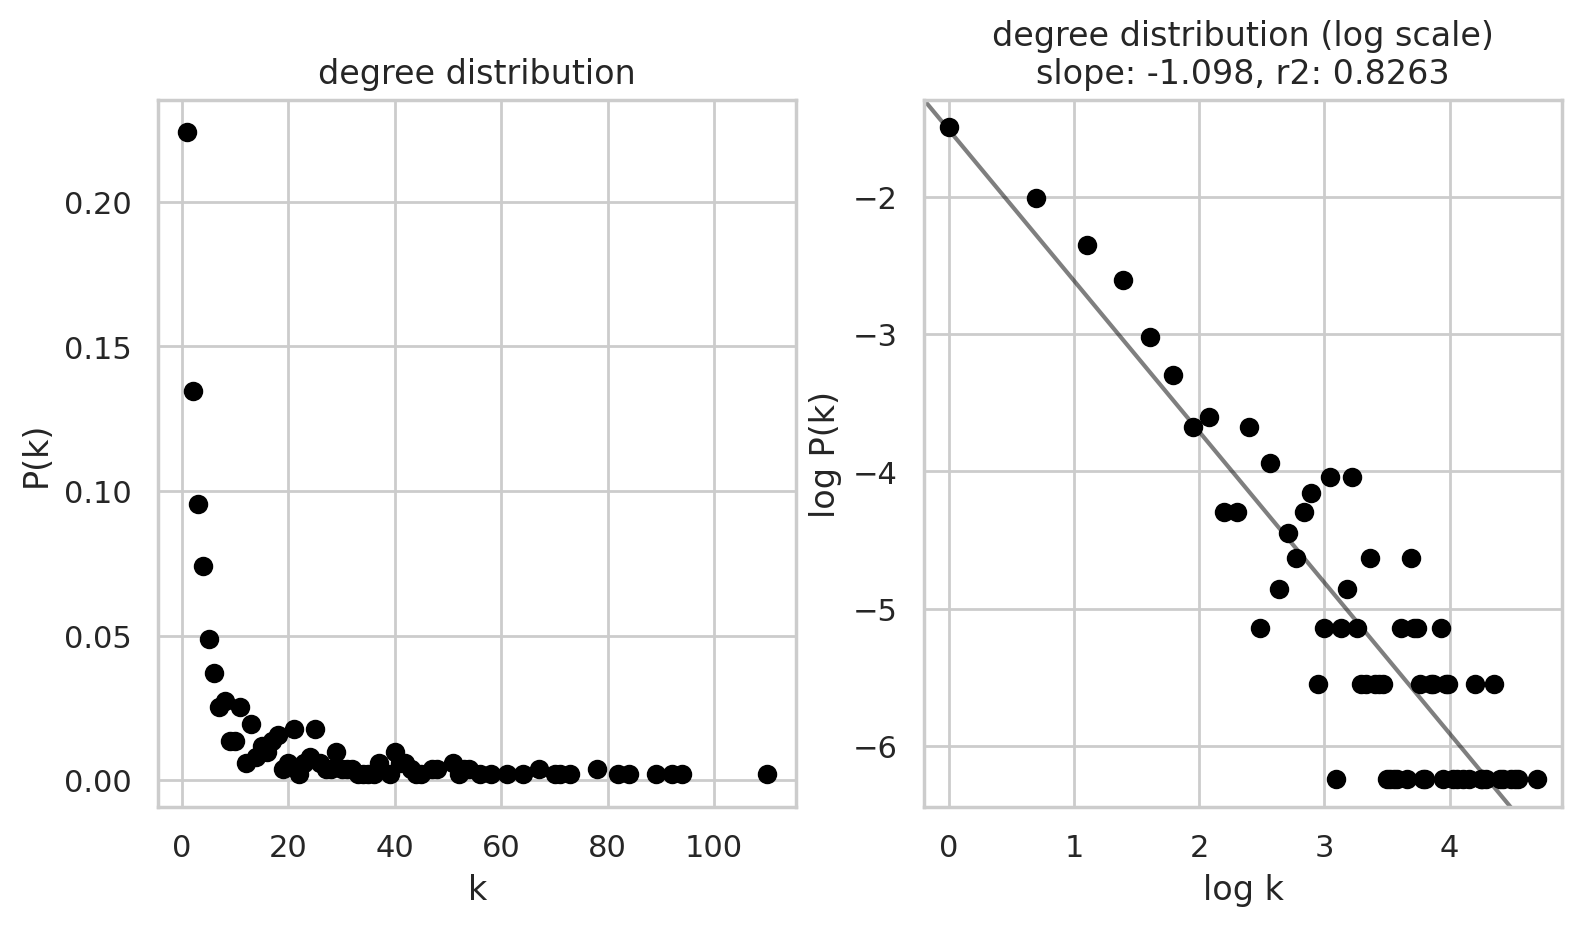

vRG


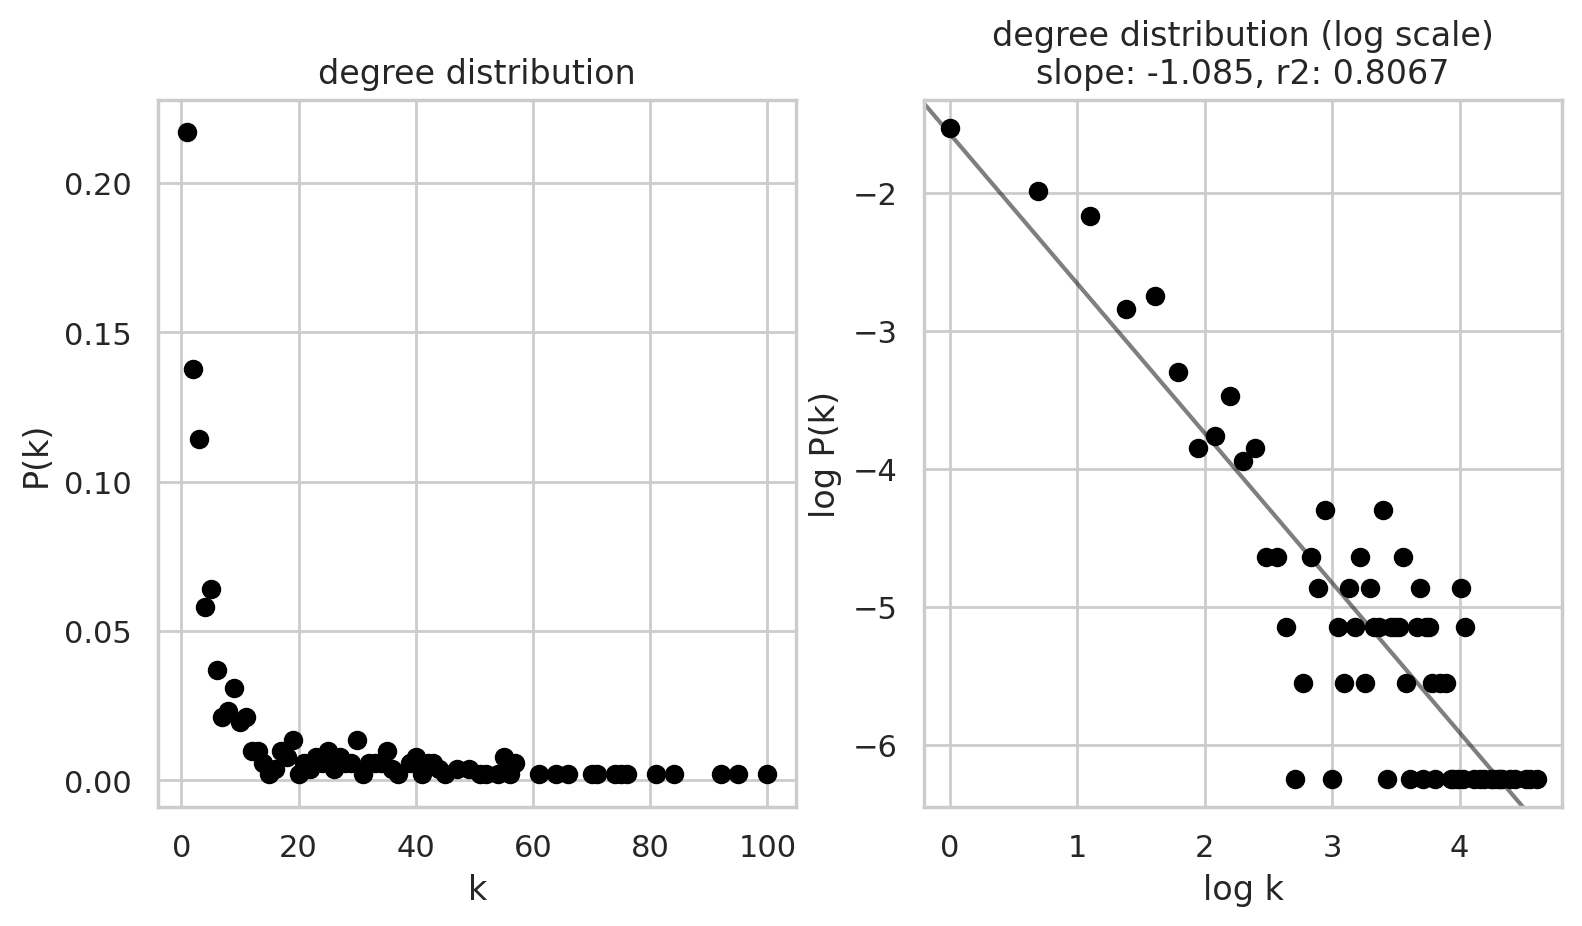

In [13]:
# filter by pvalue
# filter the top 3000 edges by strength
links.filter_links(p=0.001, weight="coef_abs", threshold_number=3000)

sns.set_context("notebook")
plt.rcParams["figure.figsize"] = [9, 4.5]

links.plot_degree_distributions(plot_model=True,
                                save=f"{save_folder}/degree_distribution/",
                               )

# Calculate network scores.

In [14]:
links.get_network_score()

In [15]:
links.merged_score.head()

# Save Links object.
links.to_hdf5(file_path="/group/testa/Project/CBOProgPools/CellOracle/20240608_Celltype_mergedScores.celloracle.links")

degree_all  degree_centrality_all  degree_in  degree_centrality_in  \
GATA2           97               0.185824          1              0.001916   
CCL2            13               0.024904         13              0.024904   
ID3            100               0.191571         36              0.068966   
SIX4            47               0.090038          4              0.007663   
MLXIPL          21               0.040230          0              0.000000   

        degree_out  degree_centrality_out  betweenness_centrality  \
GATA2           96               0.183908                  1225.0   
CCL2             0               0.000000                     0.0   
ID3             64               0.122605                 13376.0   
SIX4            43               0.082375                   886.0   
MLXIPL          21               0.040230                     0.0   

        eigenvector_centrality    cluster  
GATA2                 1.000000  DeepLayer  
CCL2                  0.763169  DeepLayer  
ID3                   0.883145  DeepLayer  
SIX4                  0.304180  DeepLayer  
MLXIPL                0.110158  DeepLayer

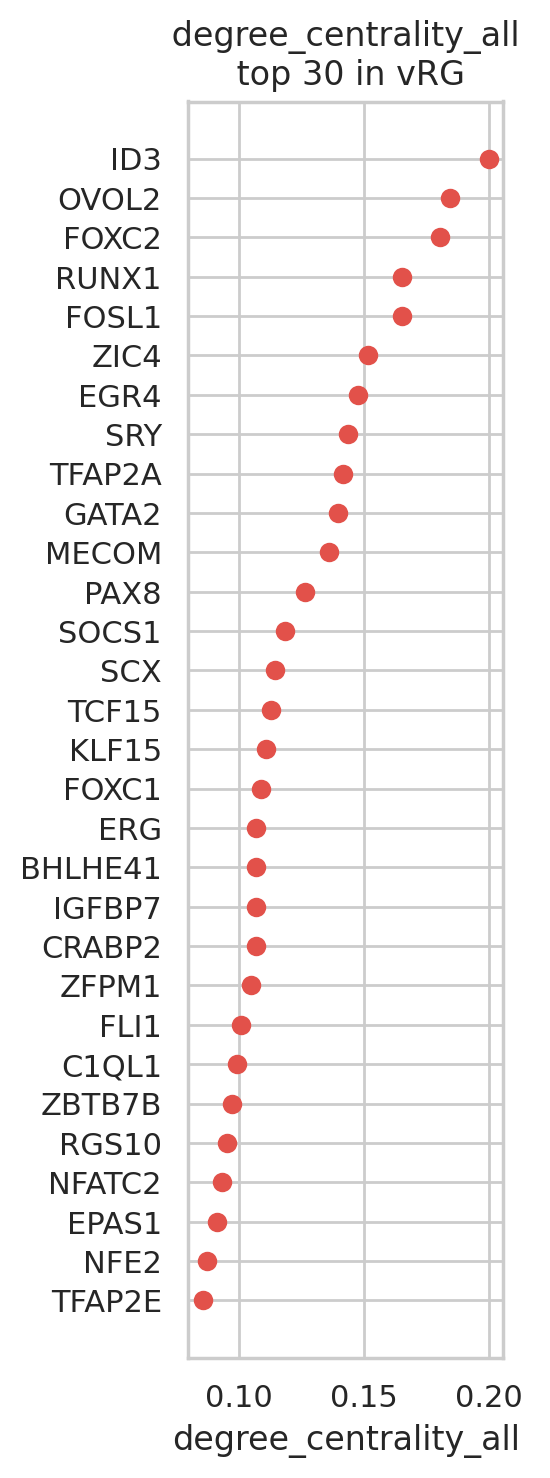

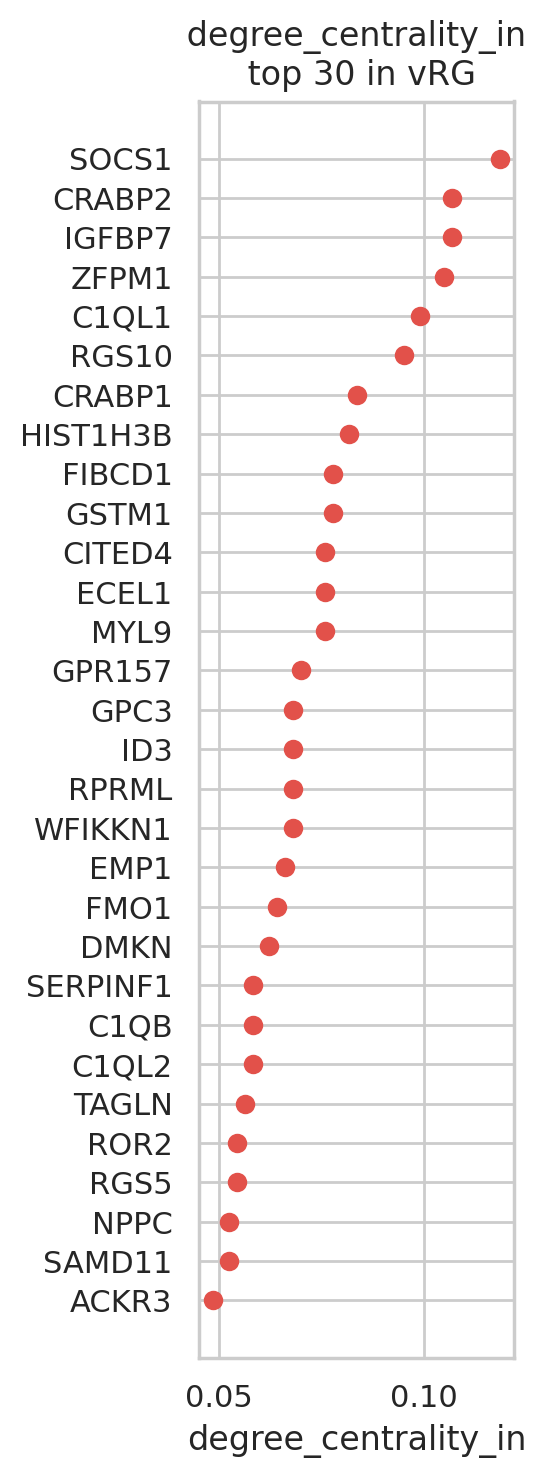

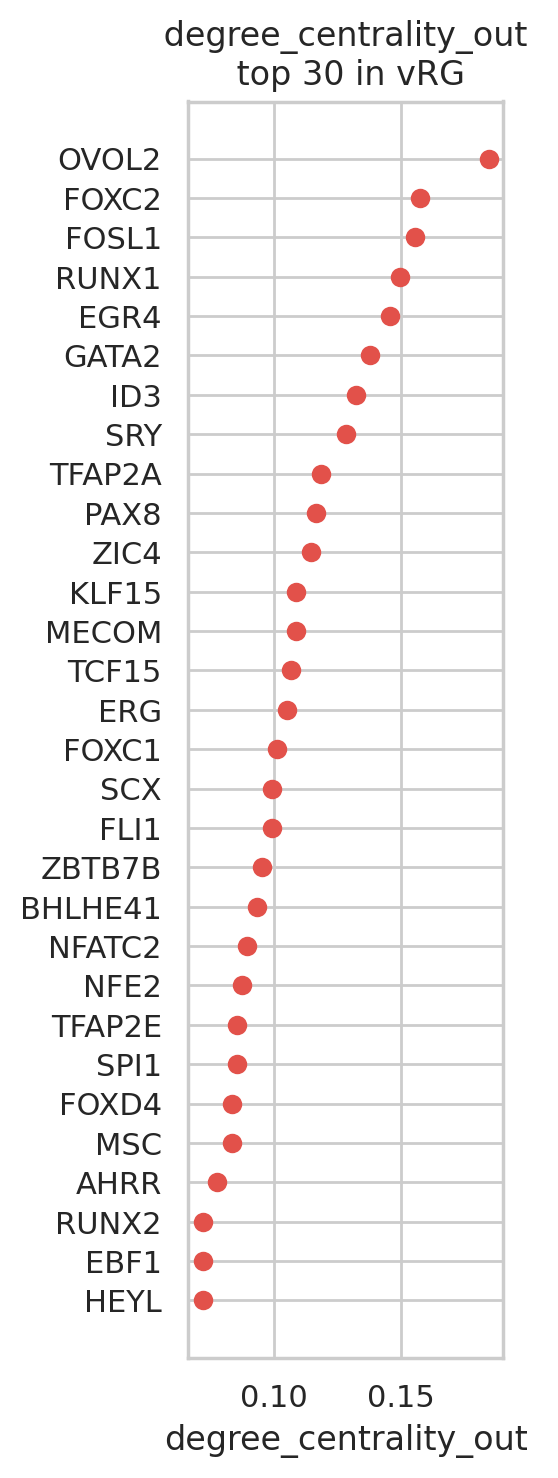

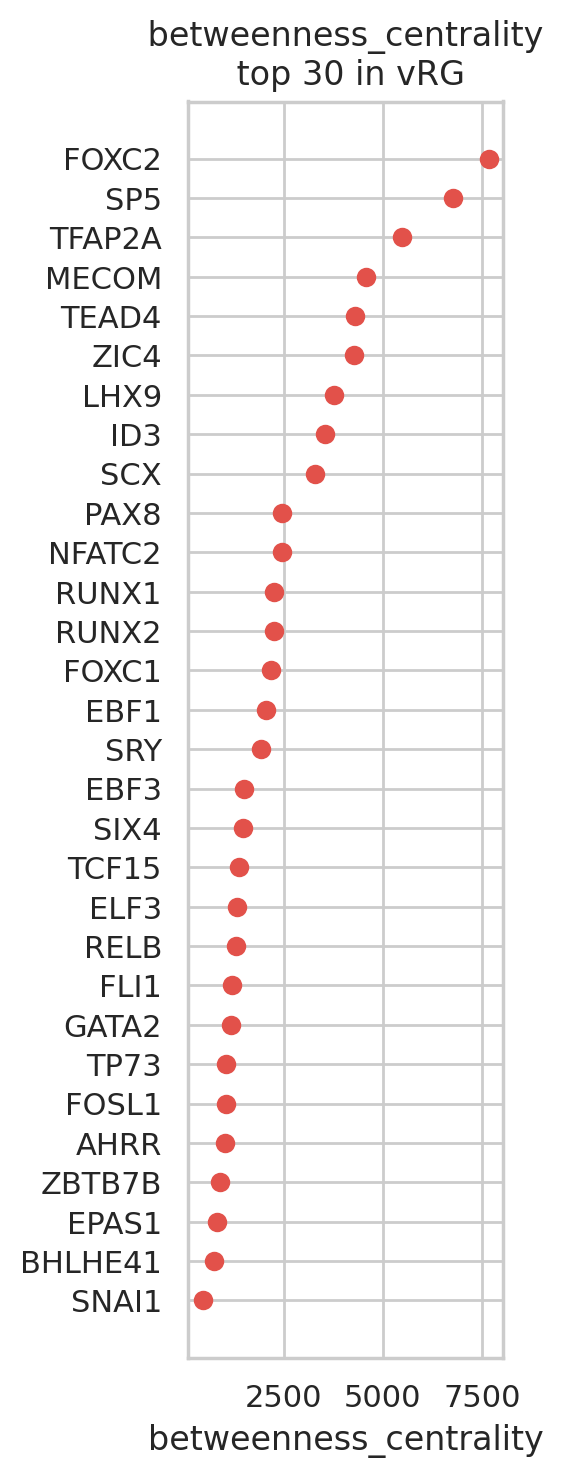

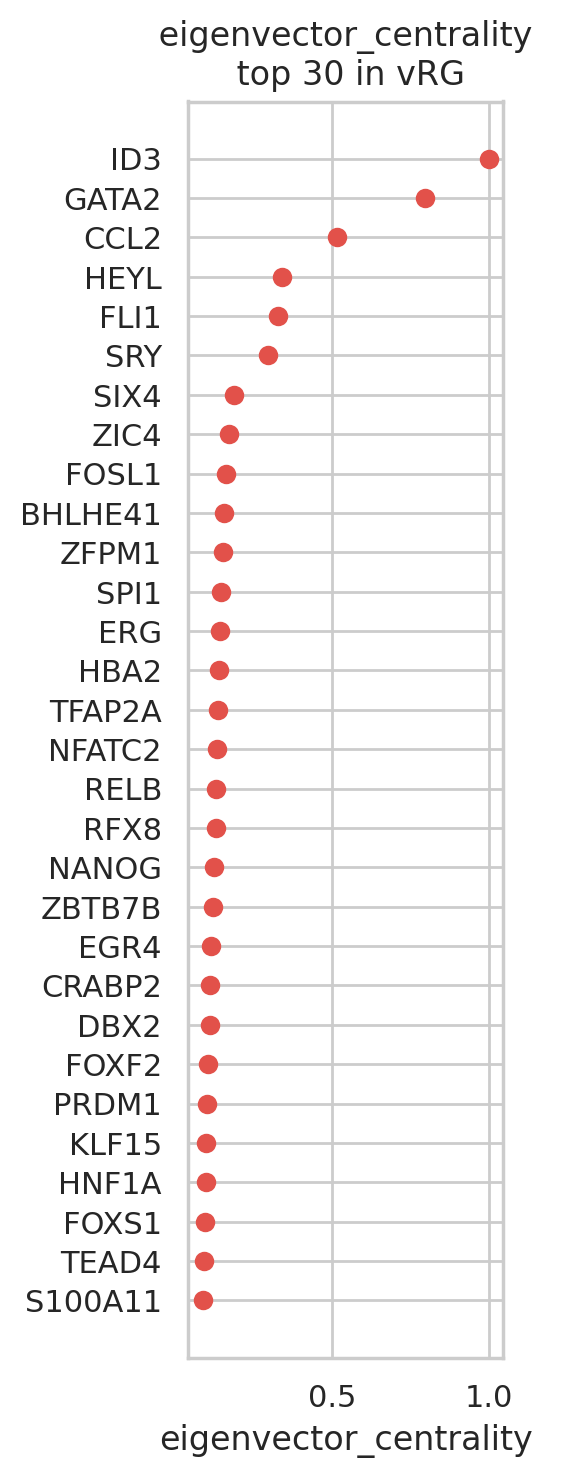

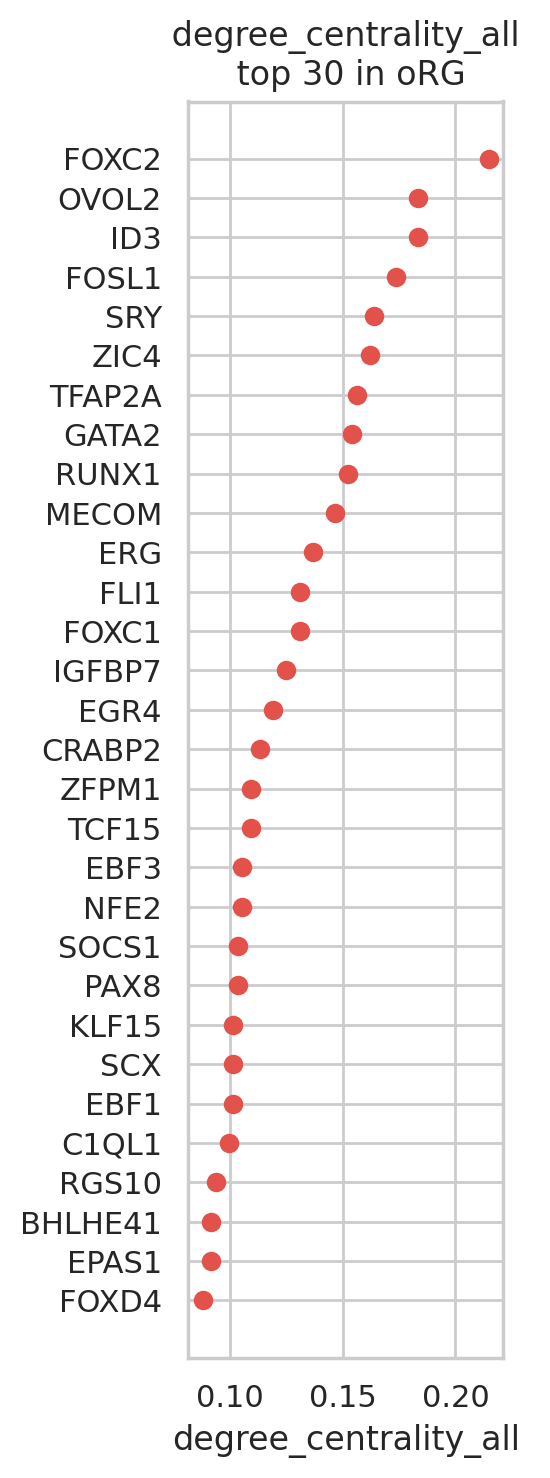

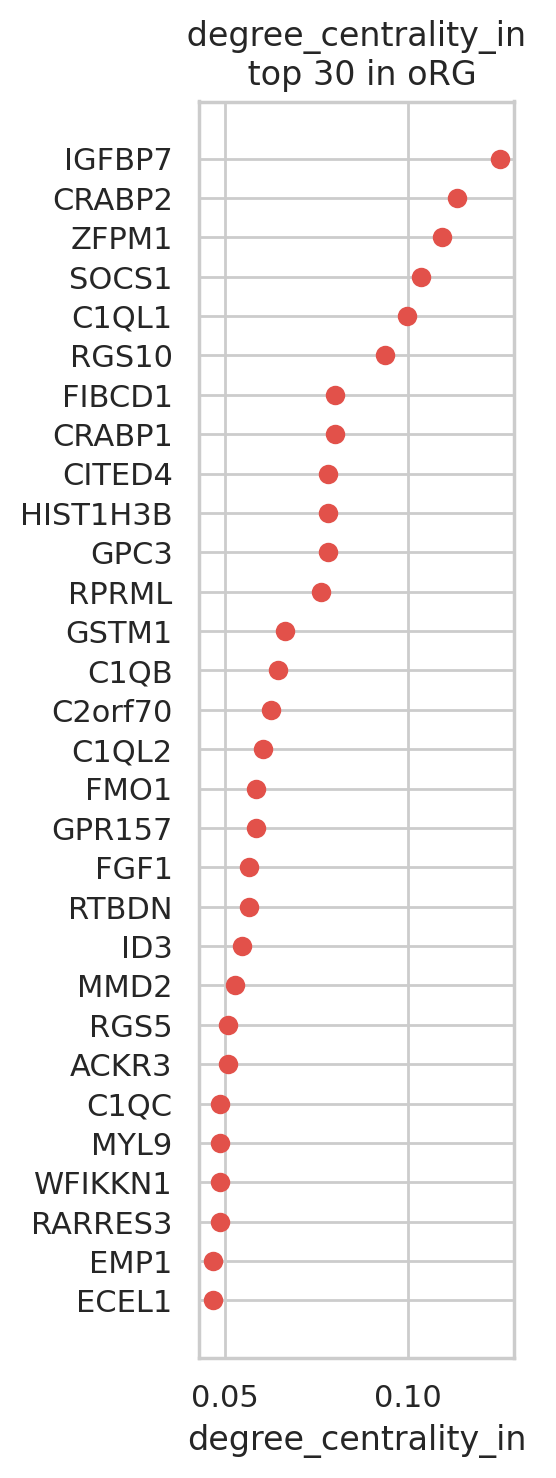

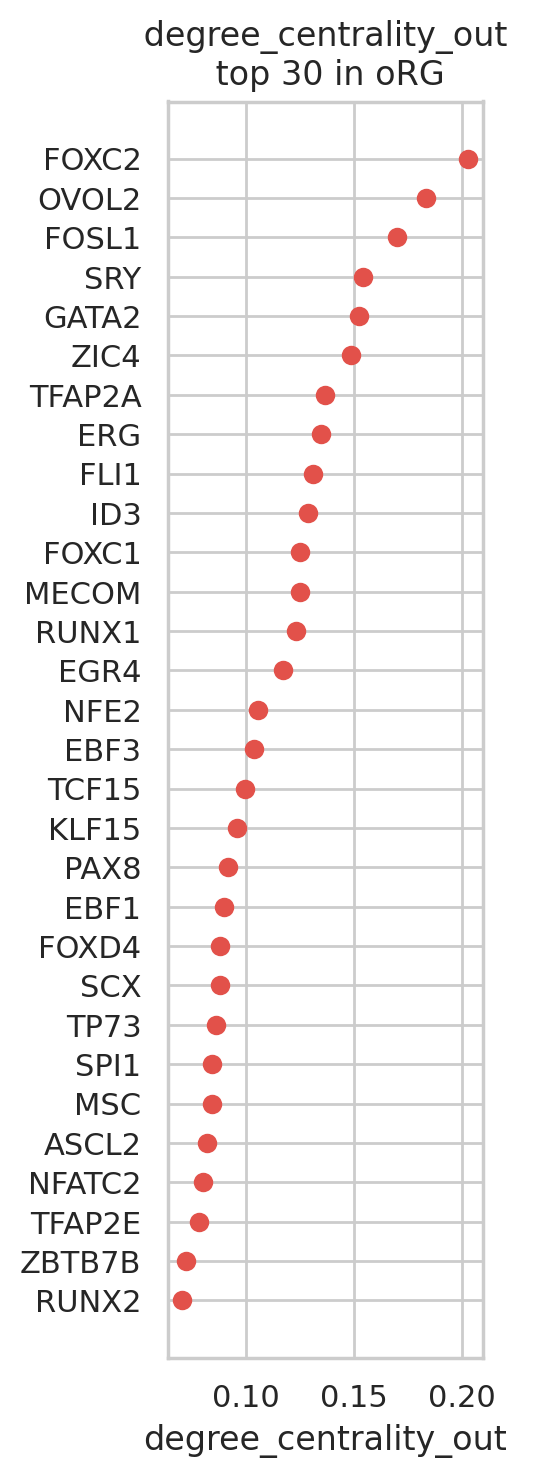

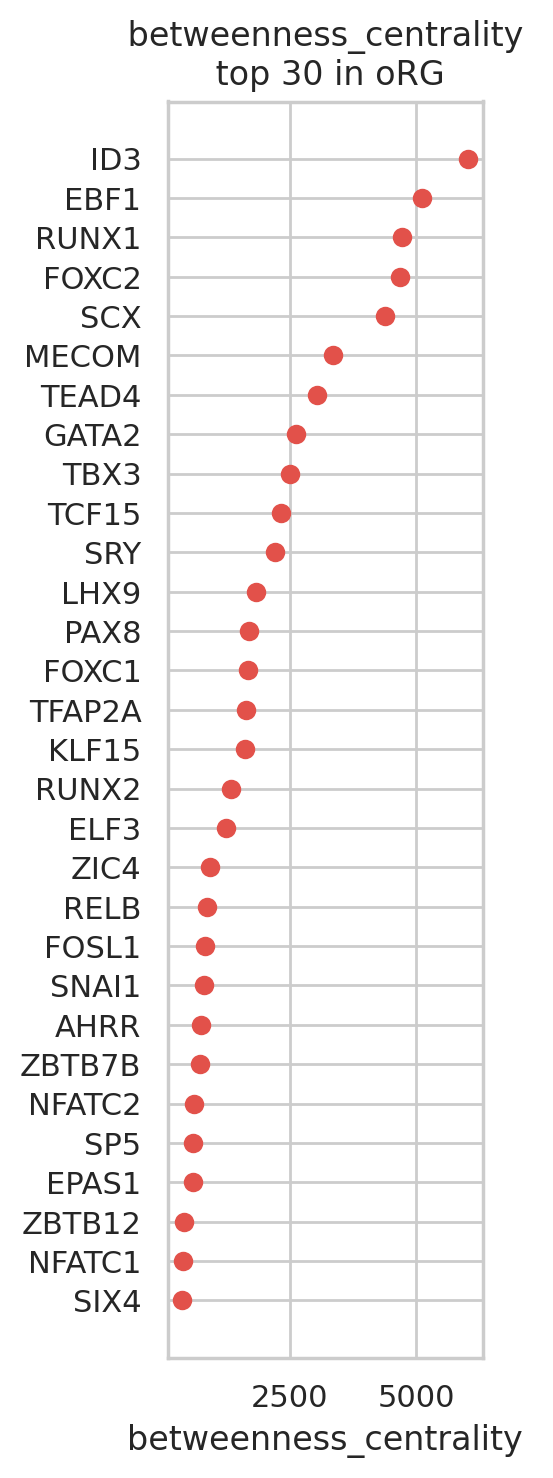

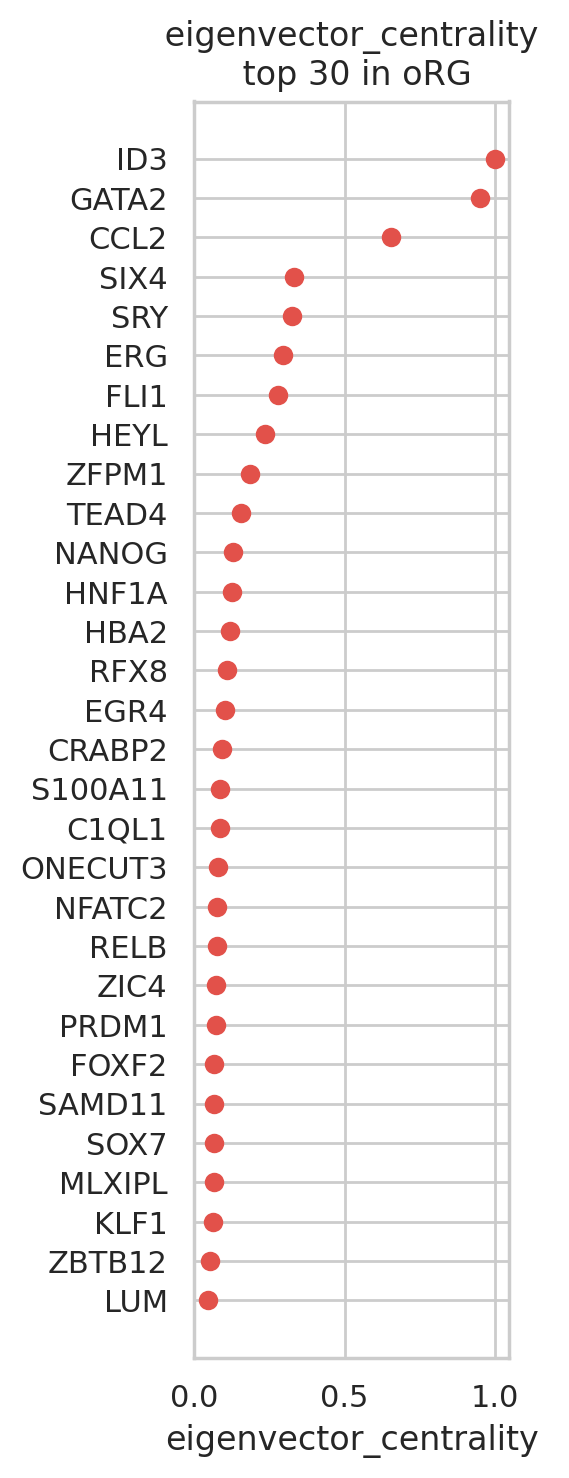

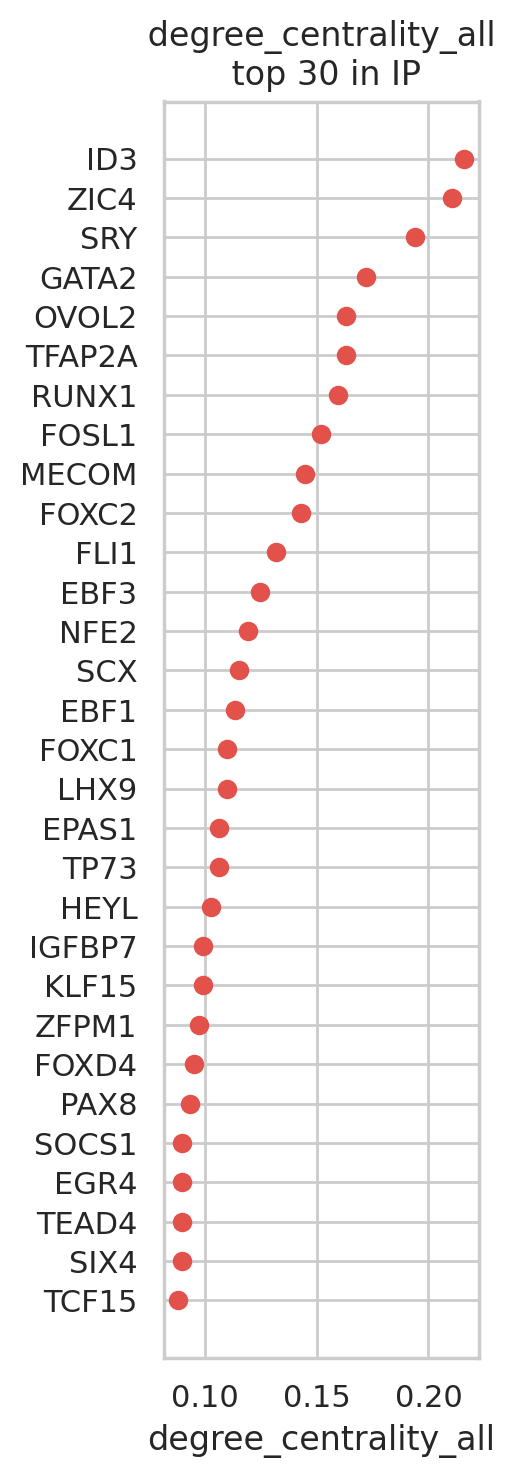

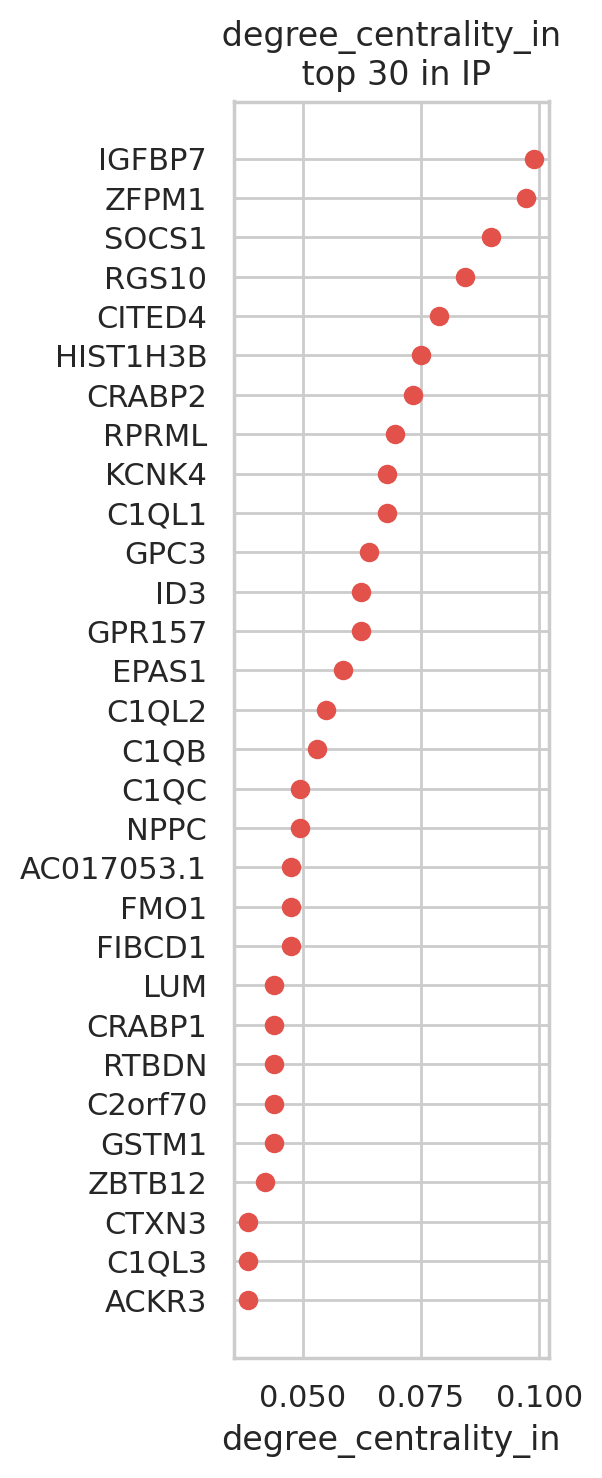

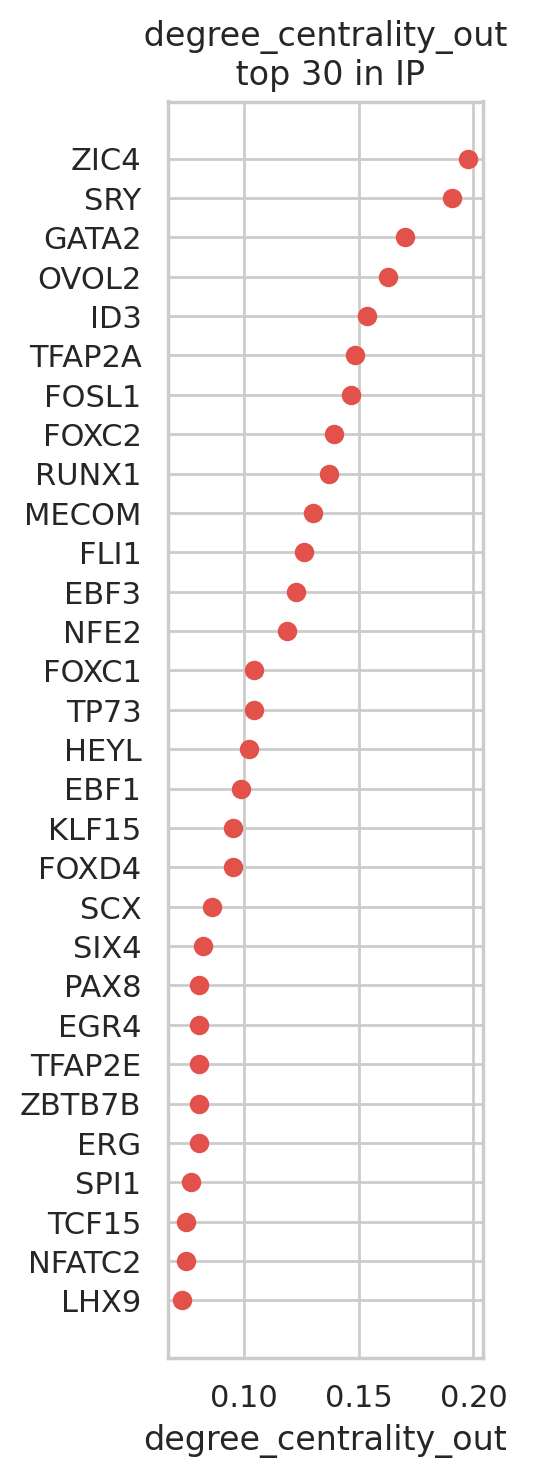

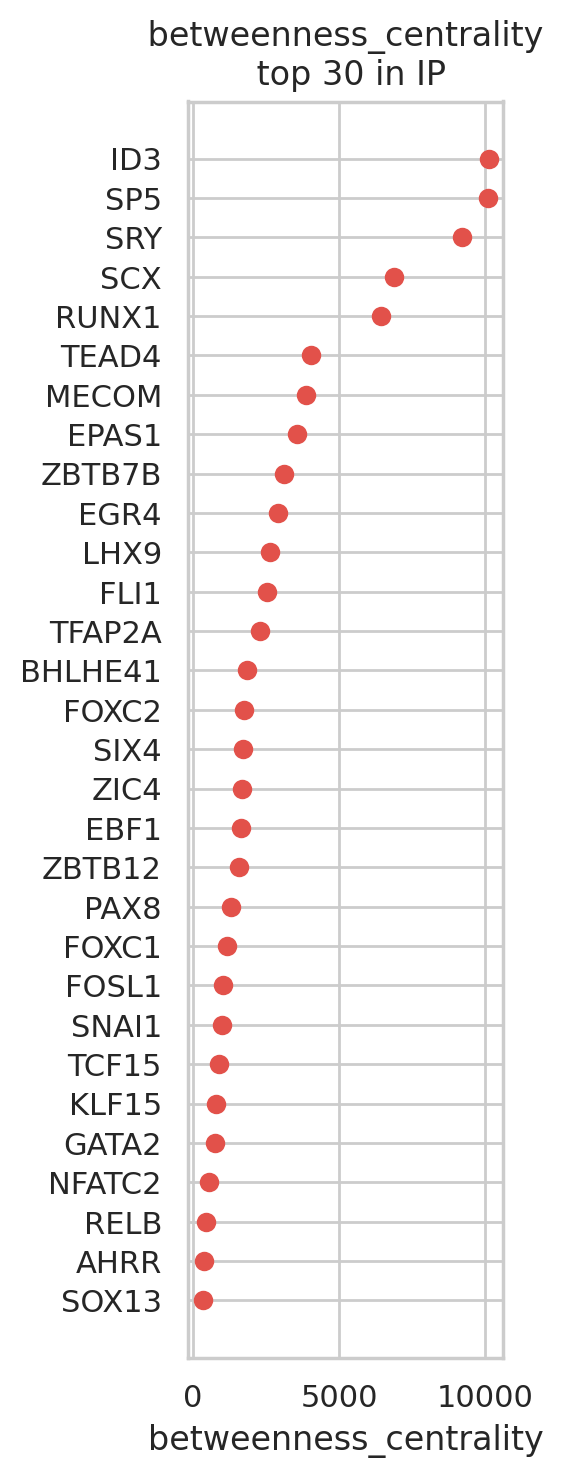

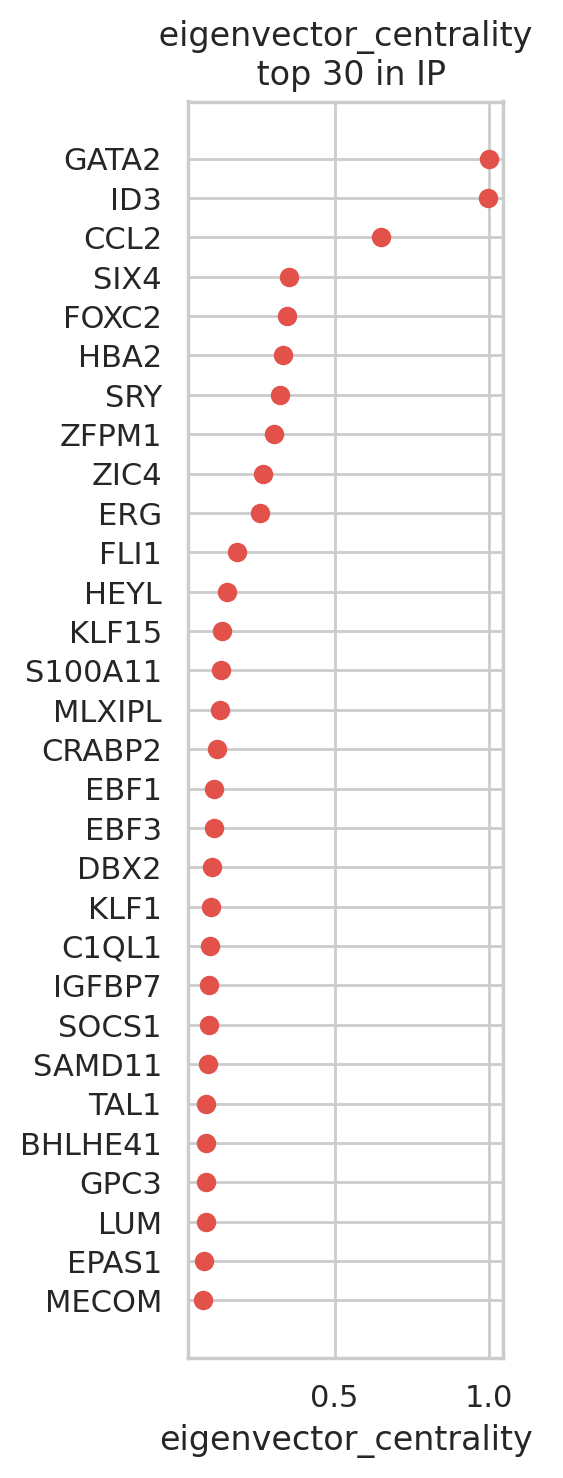

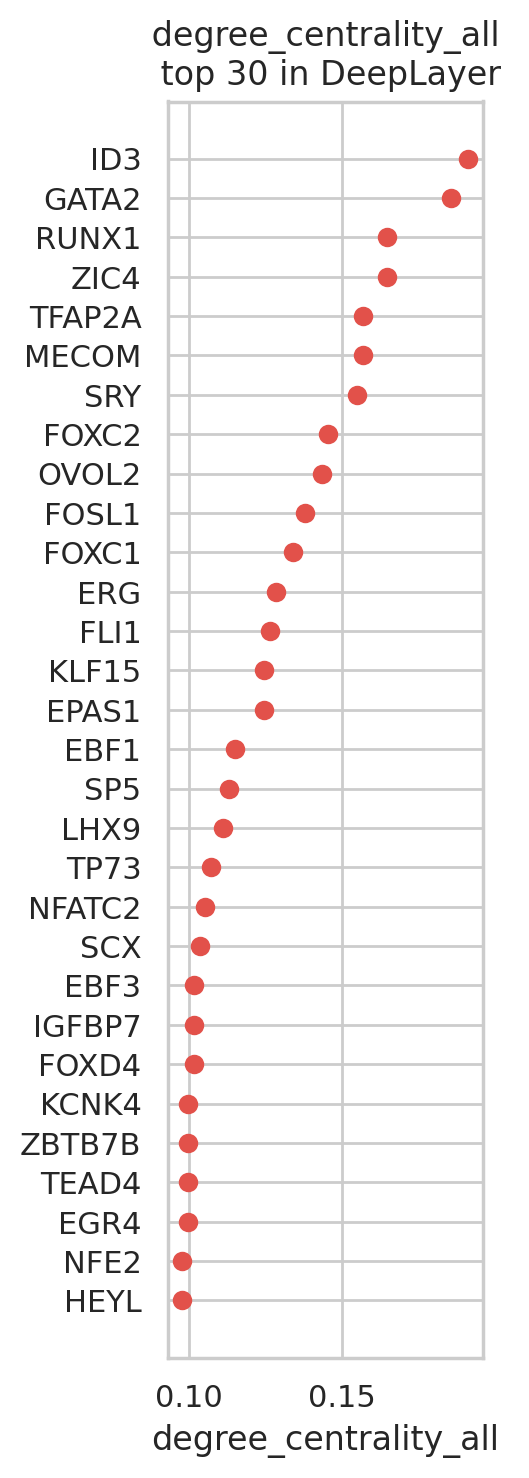

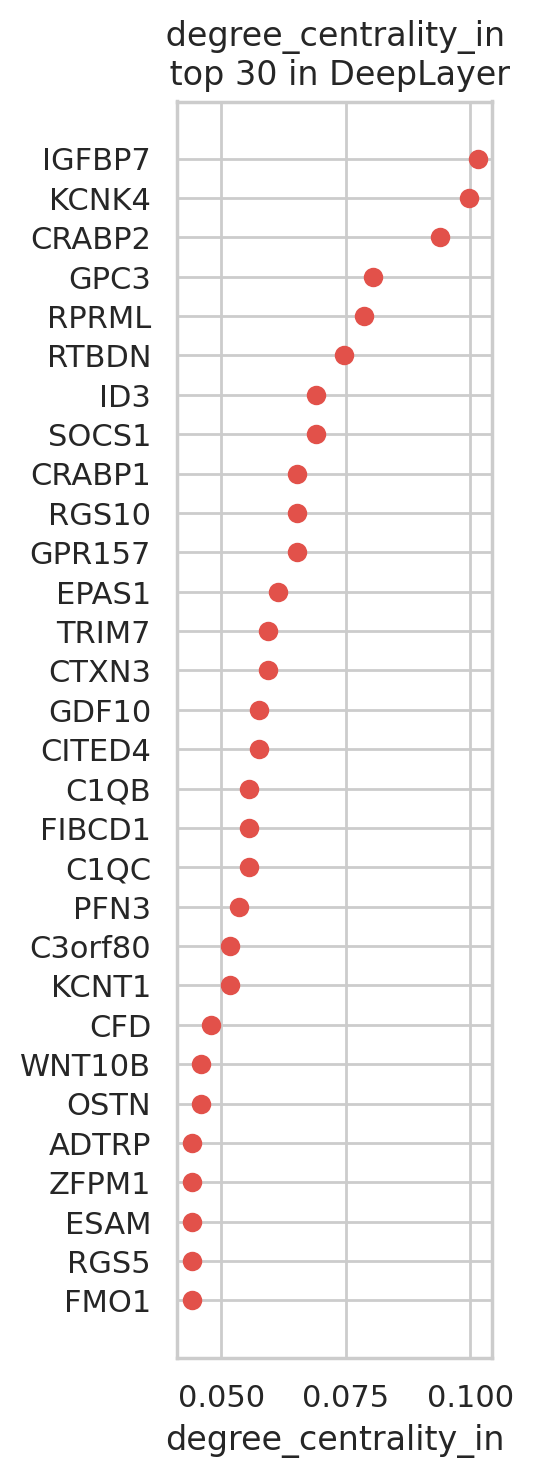

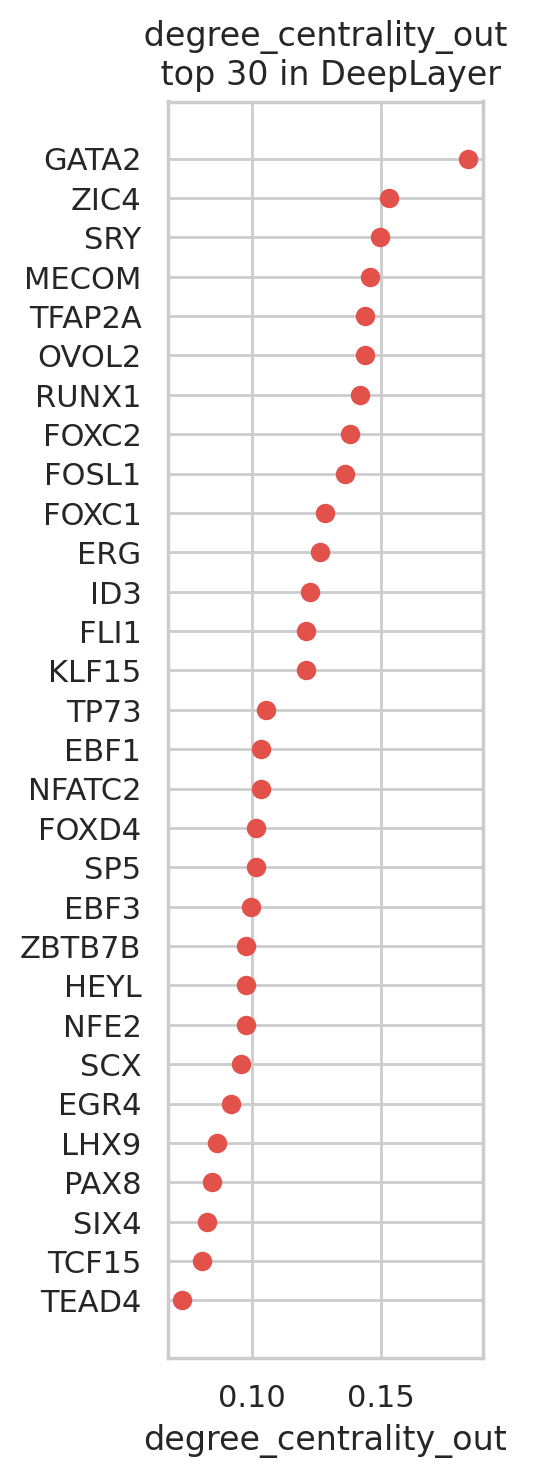

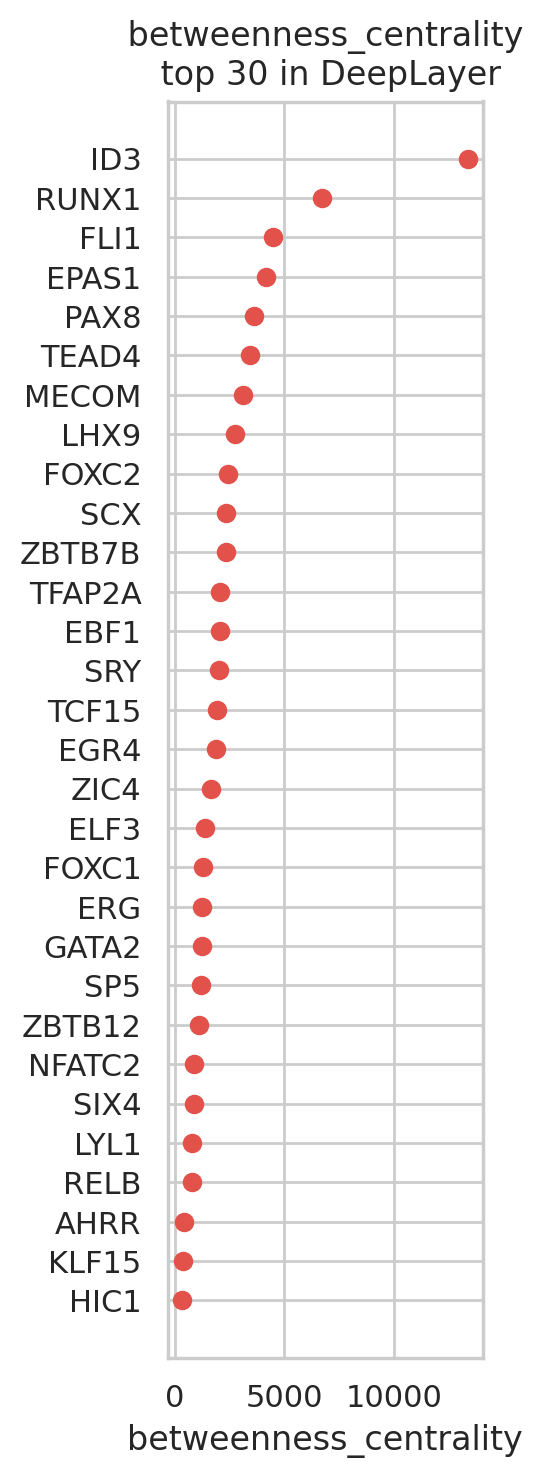

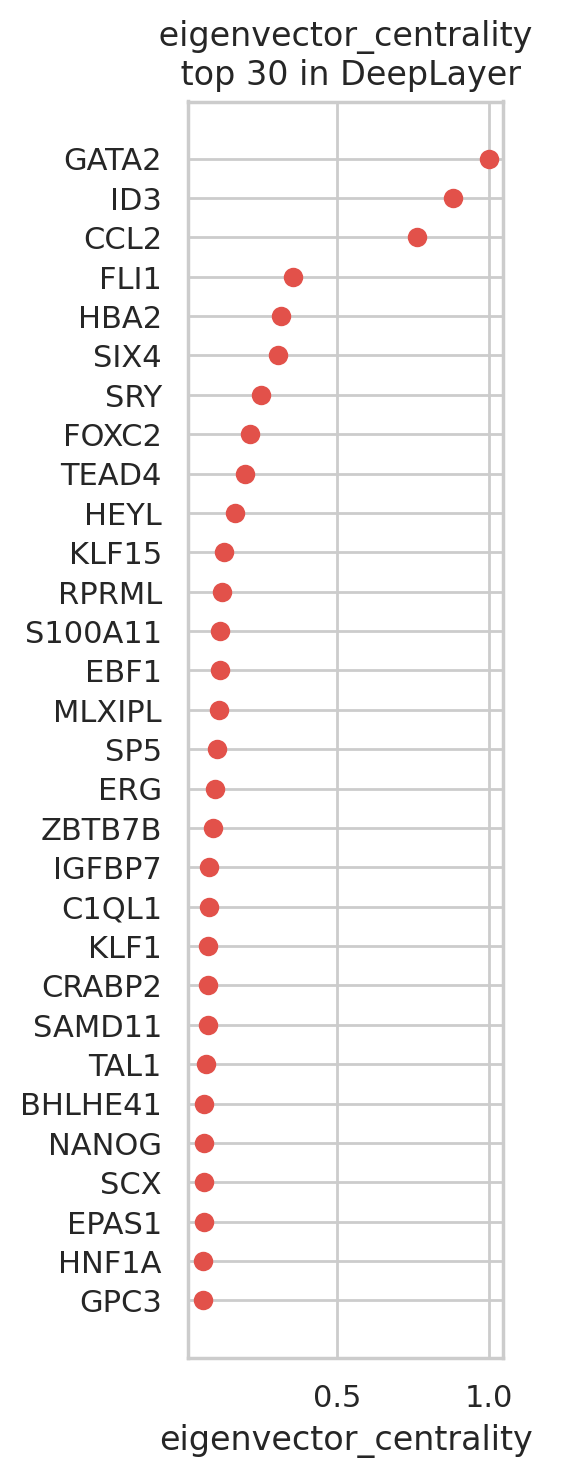

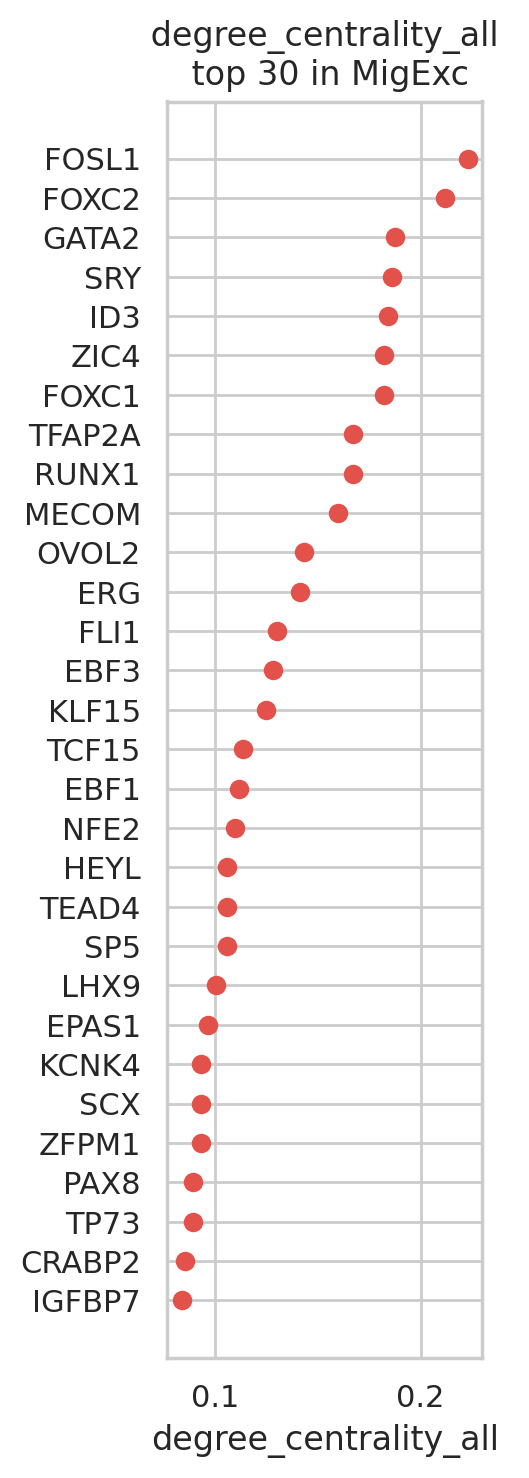

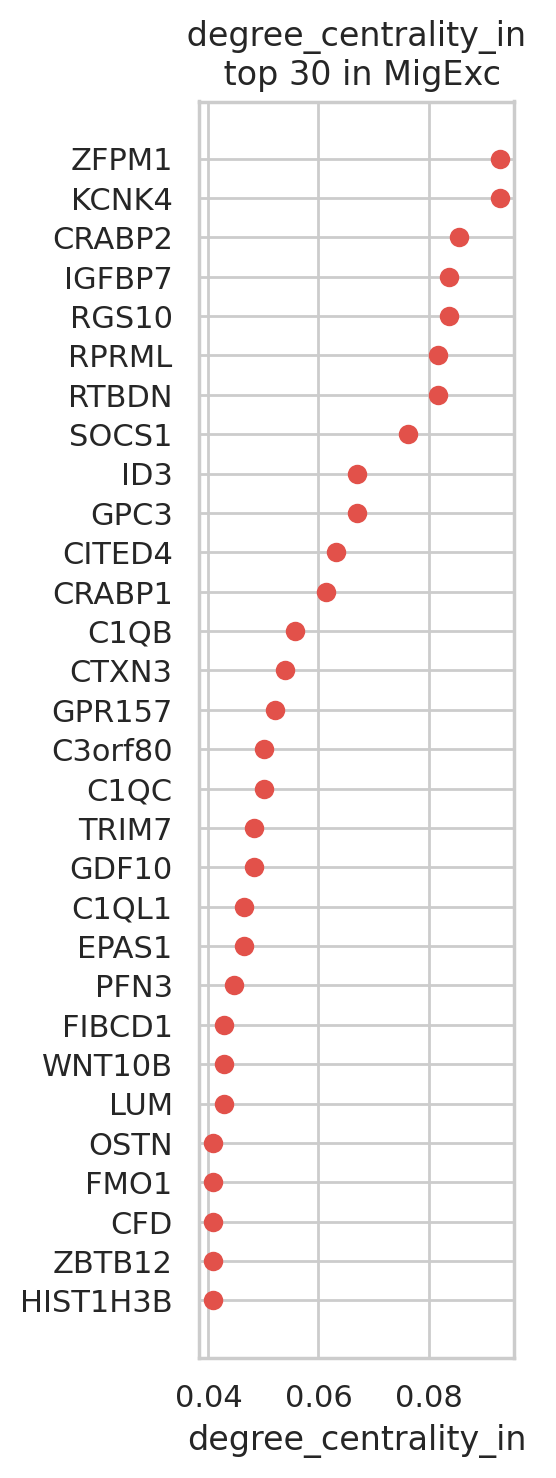

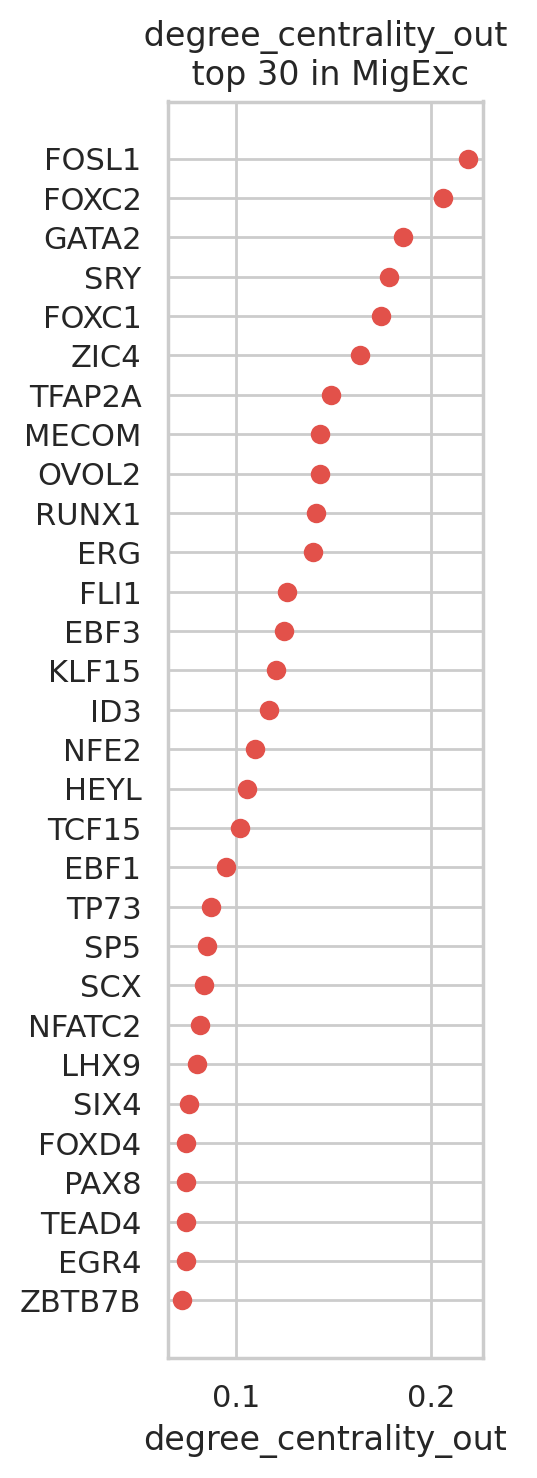

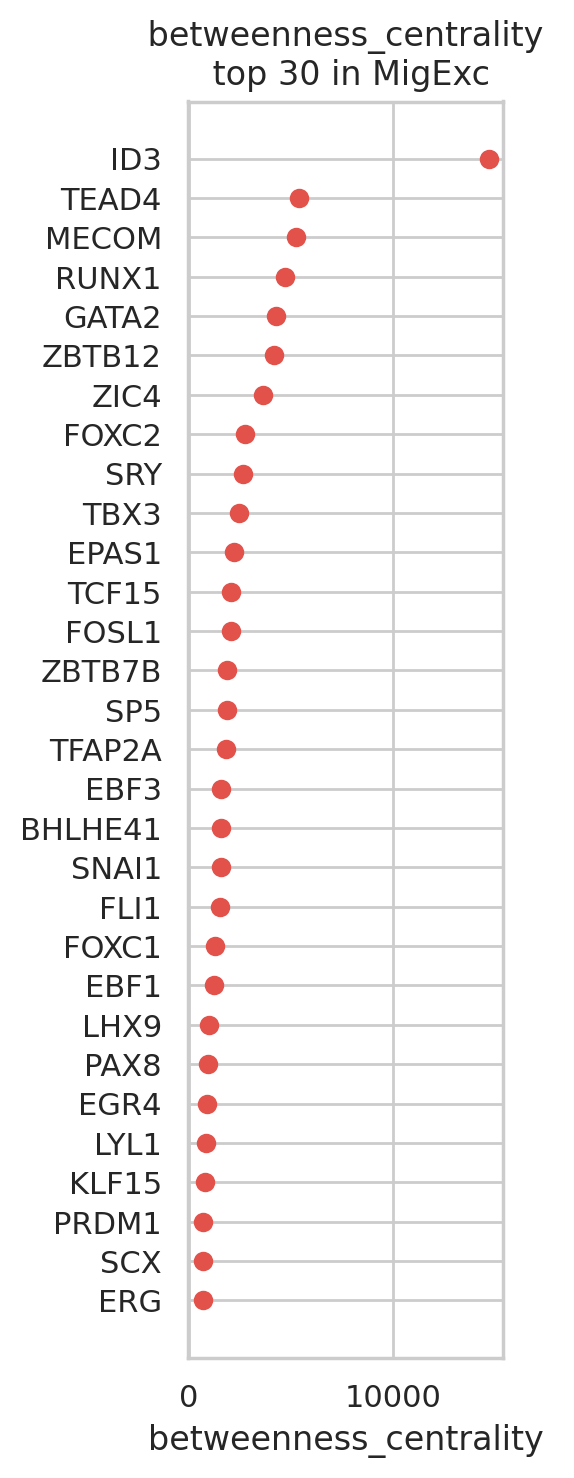

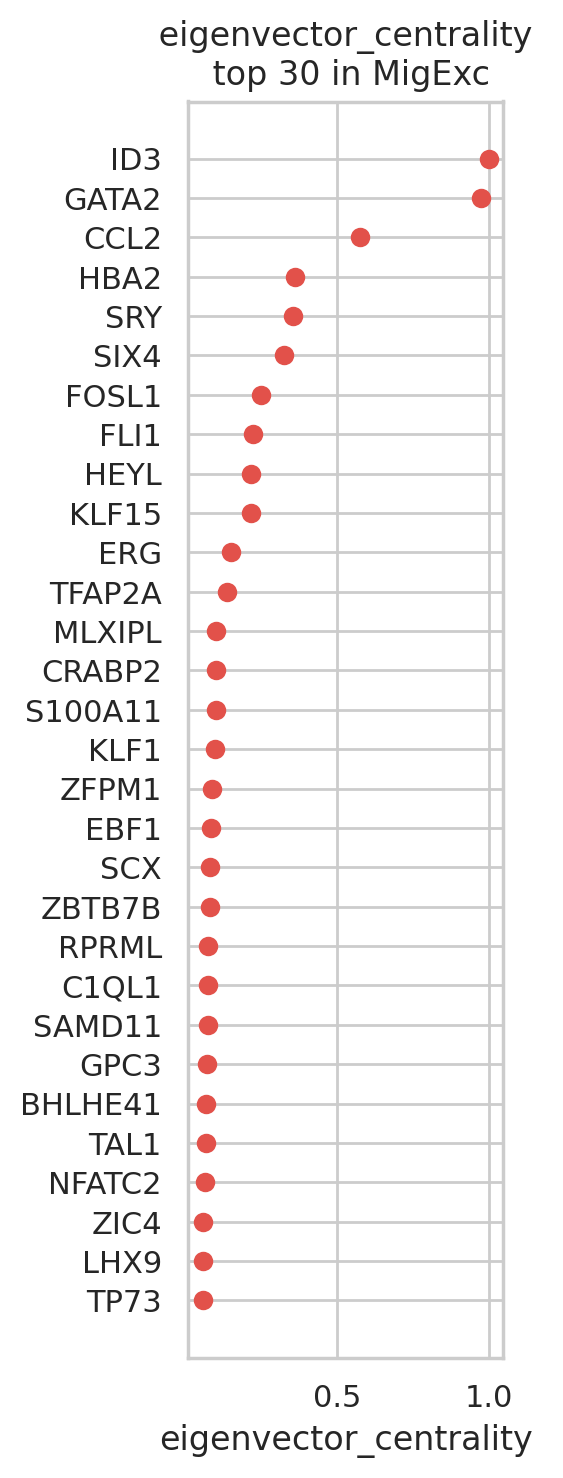

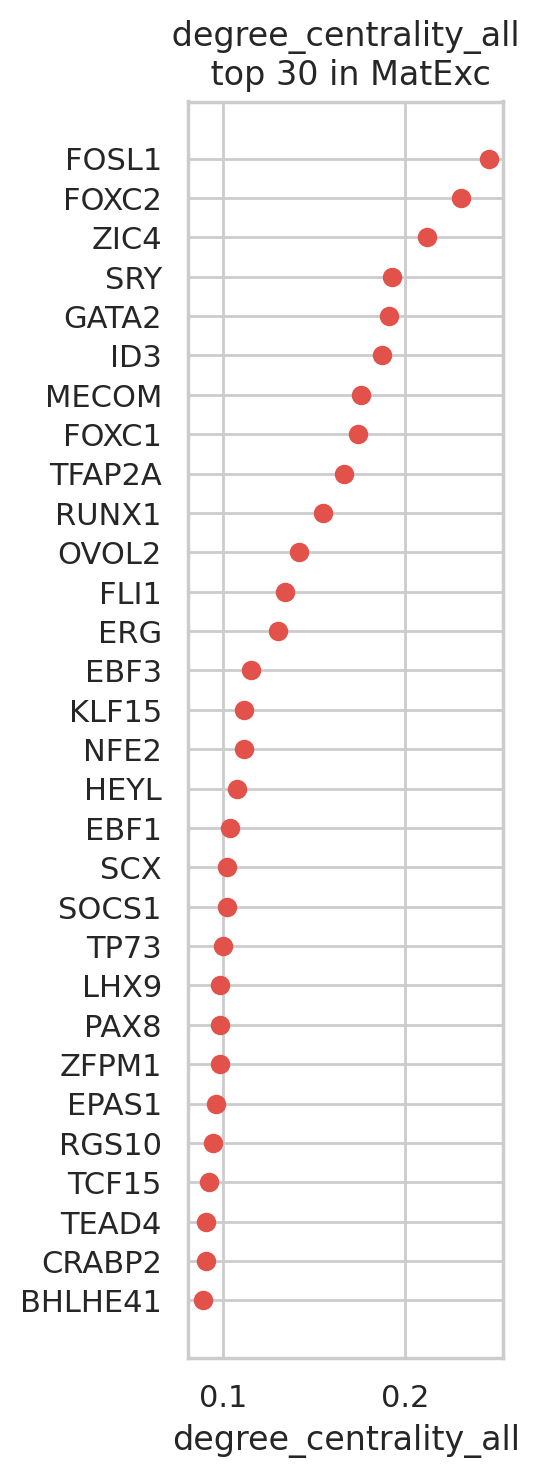

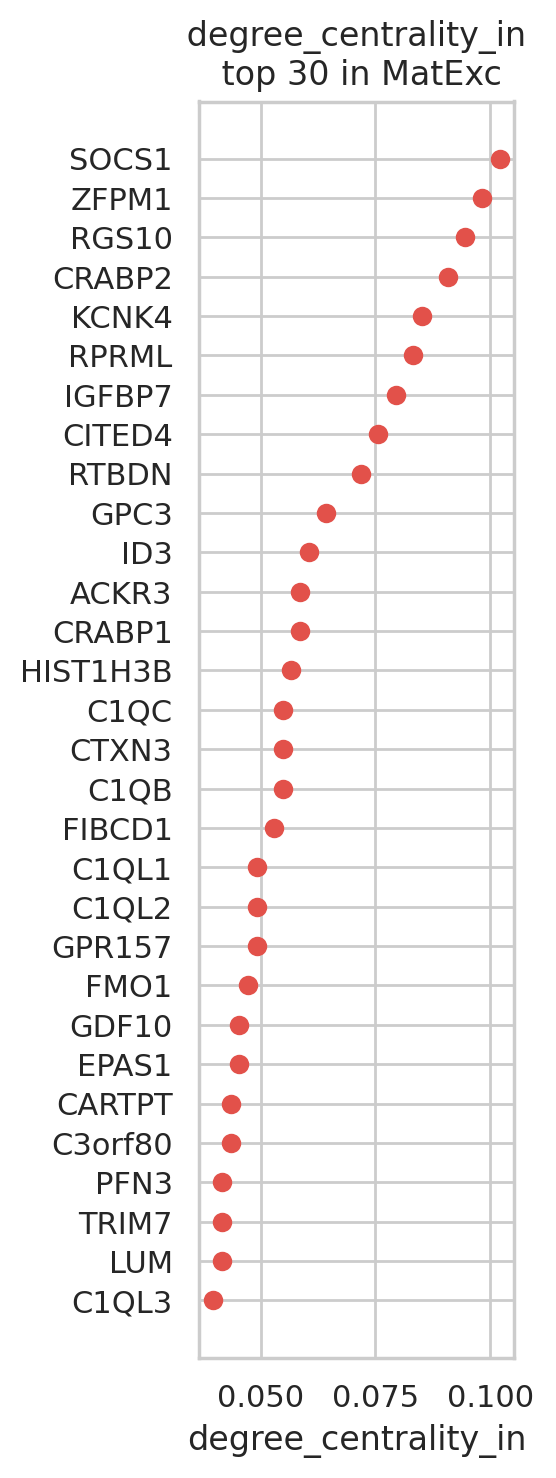

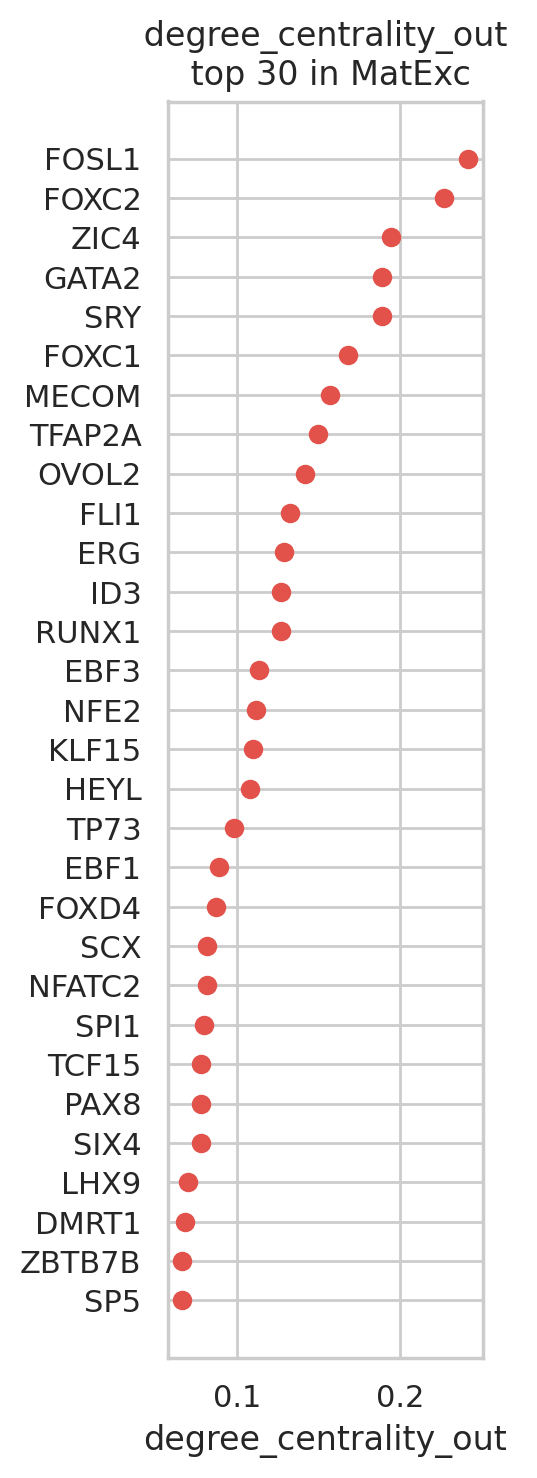

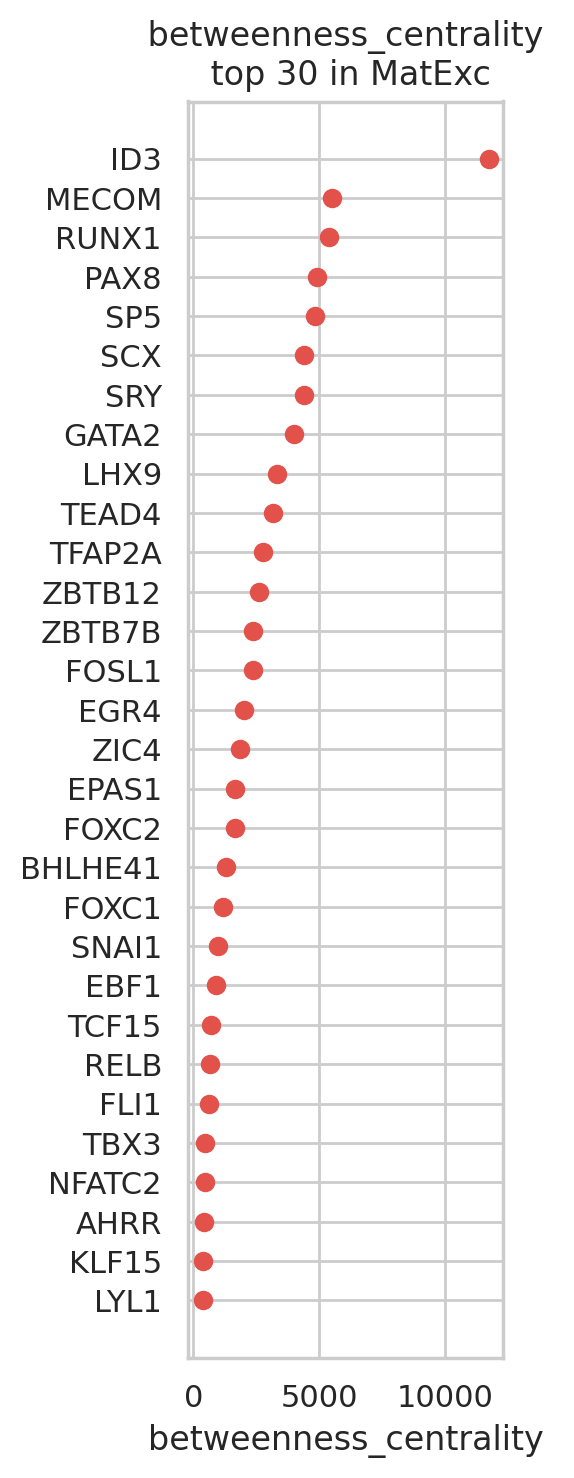

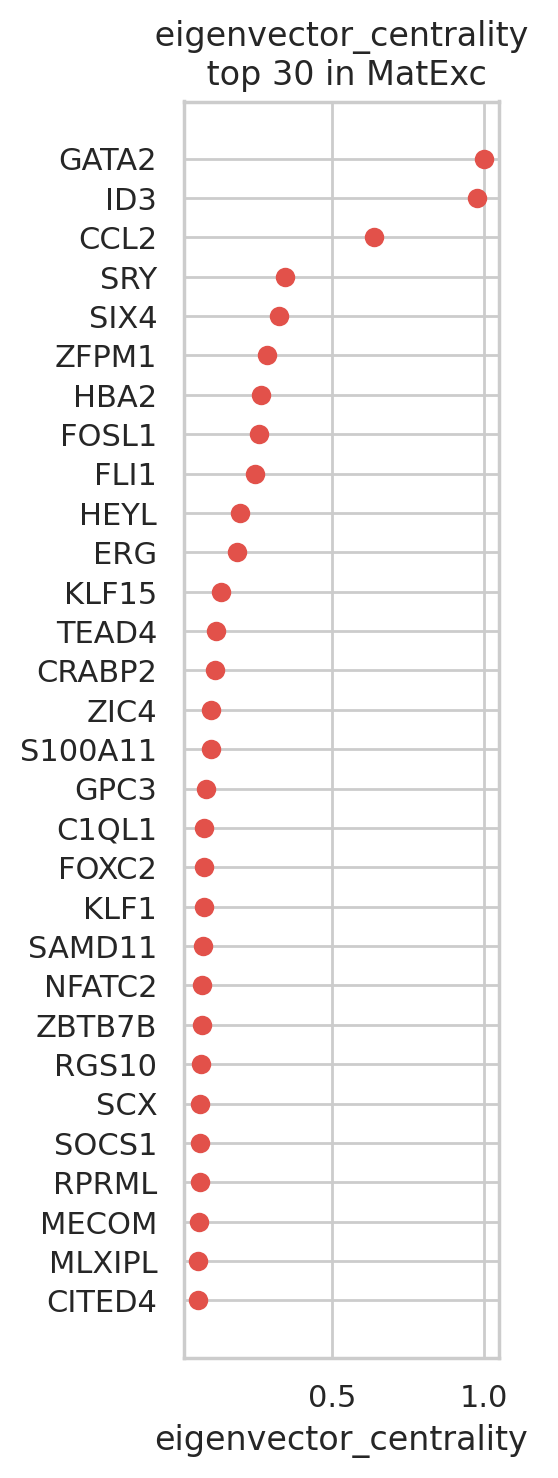

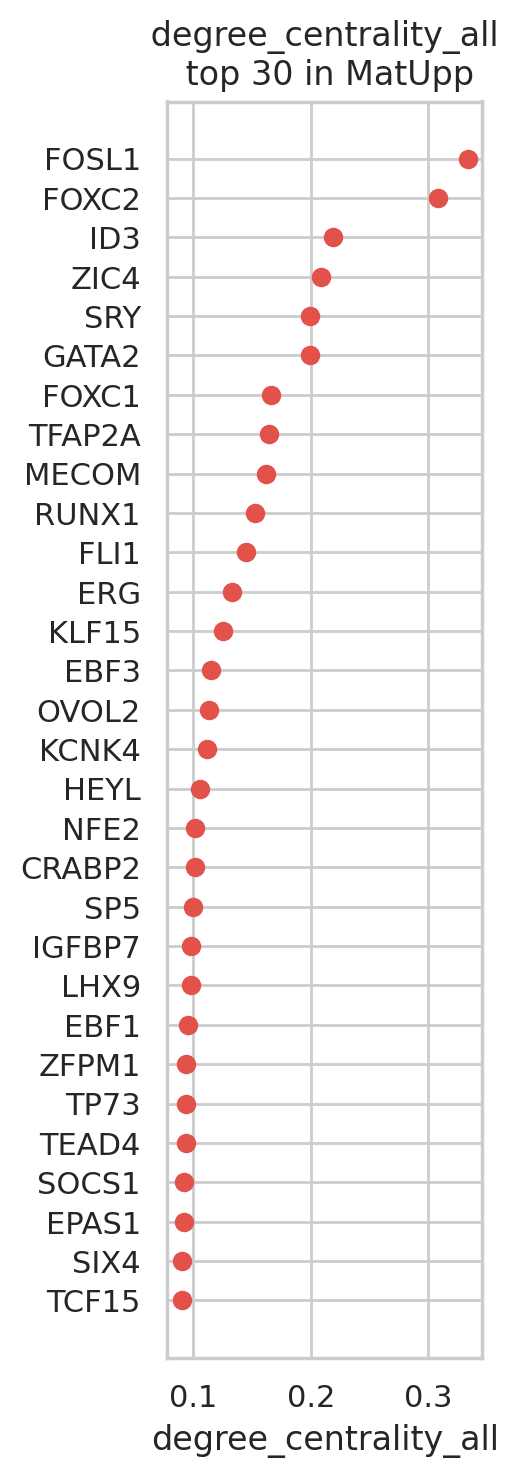

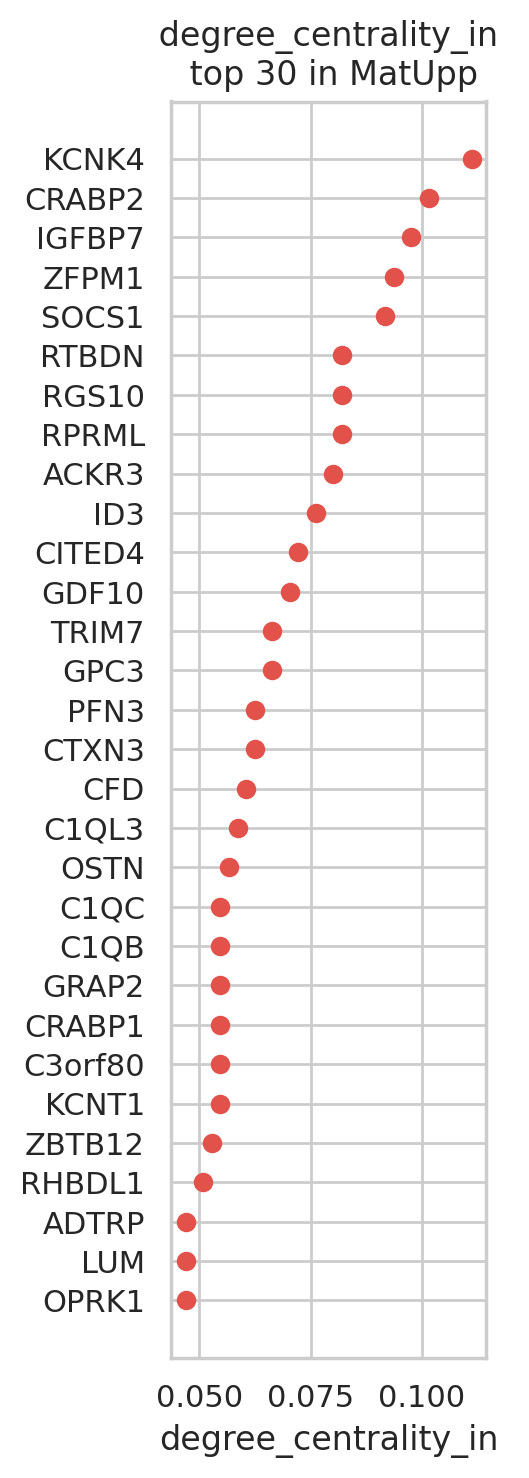

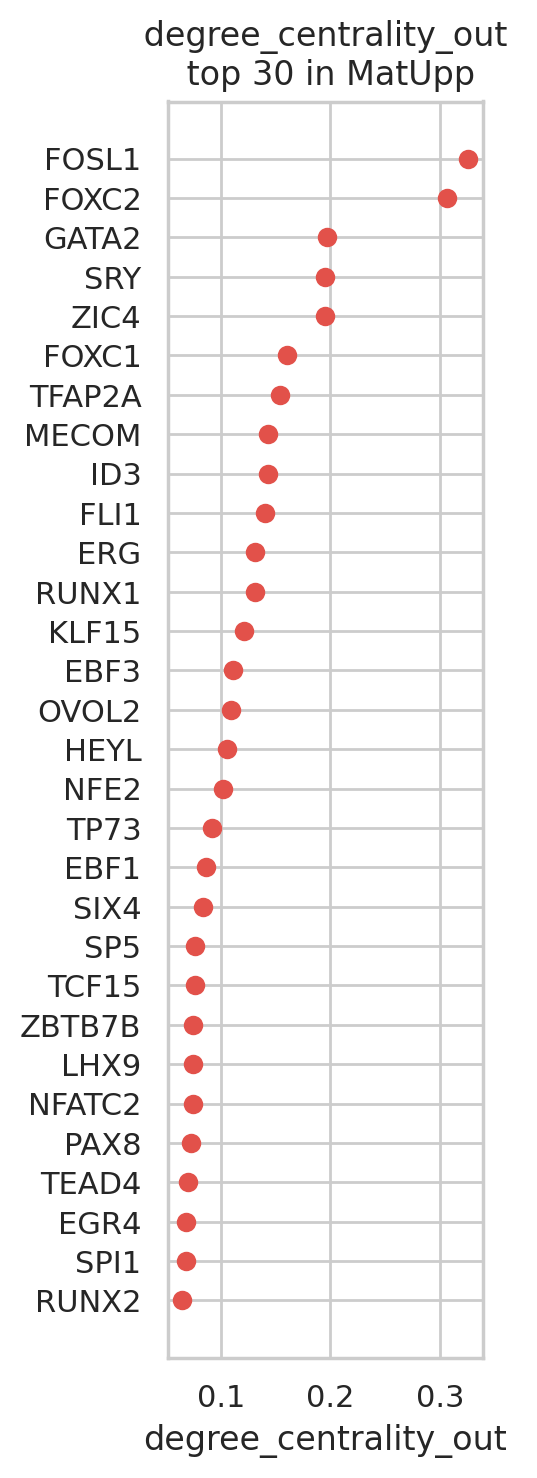

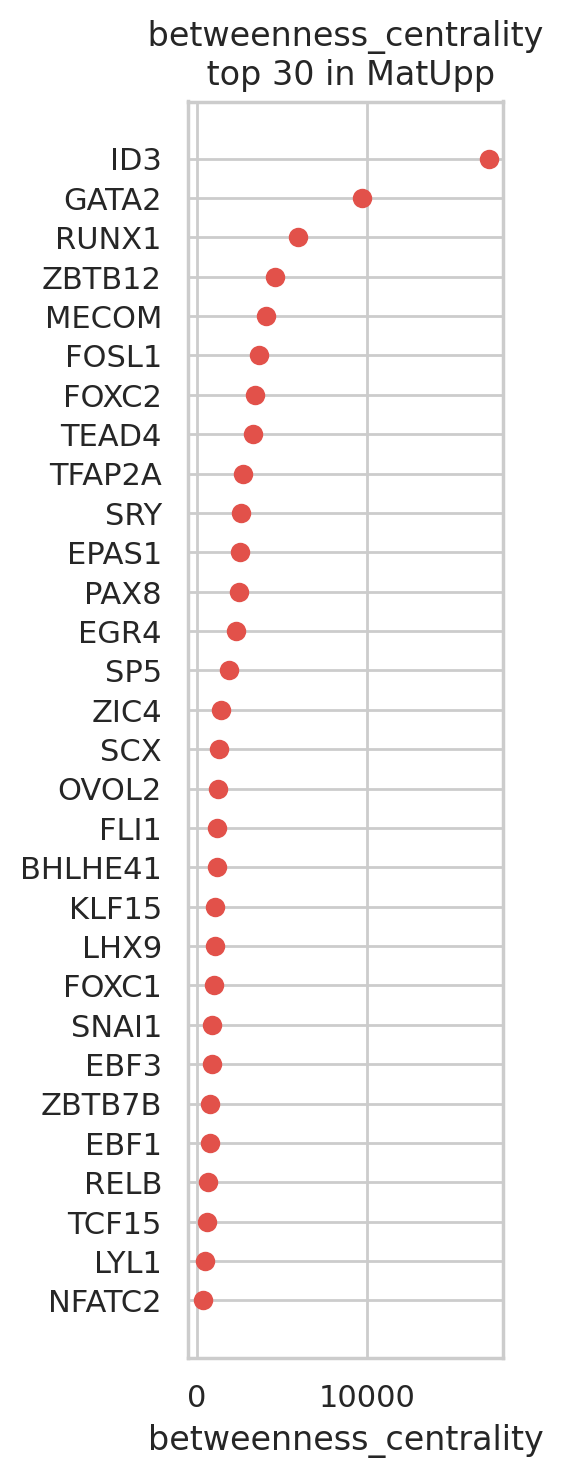

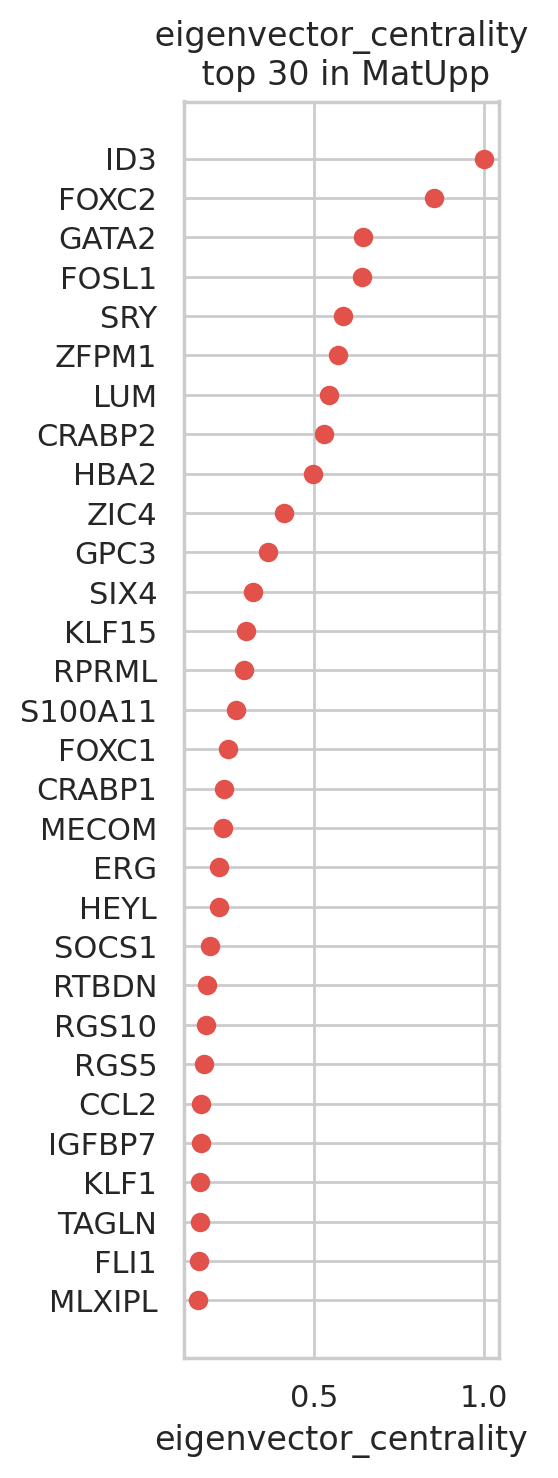

In [31]:

plt.rcParams["figure.figsize"] = [4.5, 8]

sns.set_context("notebook")
# Visualize top n-th genes with high scores.
links.plot_scores_as_rank(cluster="vRG", n_gene=30, save=f"{save_folder}/ranked_score_vRG")

sns.set_context("notebook")
# Visualize top n-th genes with high scores.
links.plot_scores_as_rank(cluster="oRG", n_gene=30, save=f"{save_folder}/ranked_score_oRG")

sns.set_context("notebook")
# Visualize top n-th genes with high scores.
links.plot_scores_as_rank(cluster="IP", n_gene=30, save=f"{save_folder}/ranked_score_IP")

sns.set_context("notebook")
# Visualize top n-th genes with high scores.
links.plot_scores_as_rank(cluster="DeepLayer", n_gene=30, save=f"{save_folder}/ranked_score_DeepLayer")

sns.set_context("notebook")
# Visualize top n-th genes with high scores.
links.plot_scores_as_rank(cluster="MigExc", n_gene=30, save=f"{save_folder}/ranked_score_MigExc")

sns.set_context("notebook")
# Visualize top n-th genes with high scores.
links.plot_scores_as_rank(cluster="MatExc", n_gene=30, save=f"{save_folder}/ranked_score_MatExc")

sns.set_context("notebook")
# Visualize top n-th genes with high scores.
links.plot_scores_as_rank(cluster="MatUpp", n_gene=30, save=f"{save_folder}/ranked_score_MatUpp")

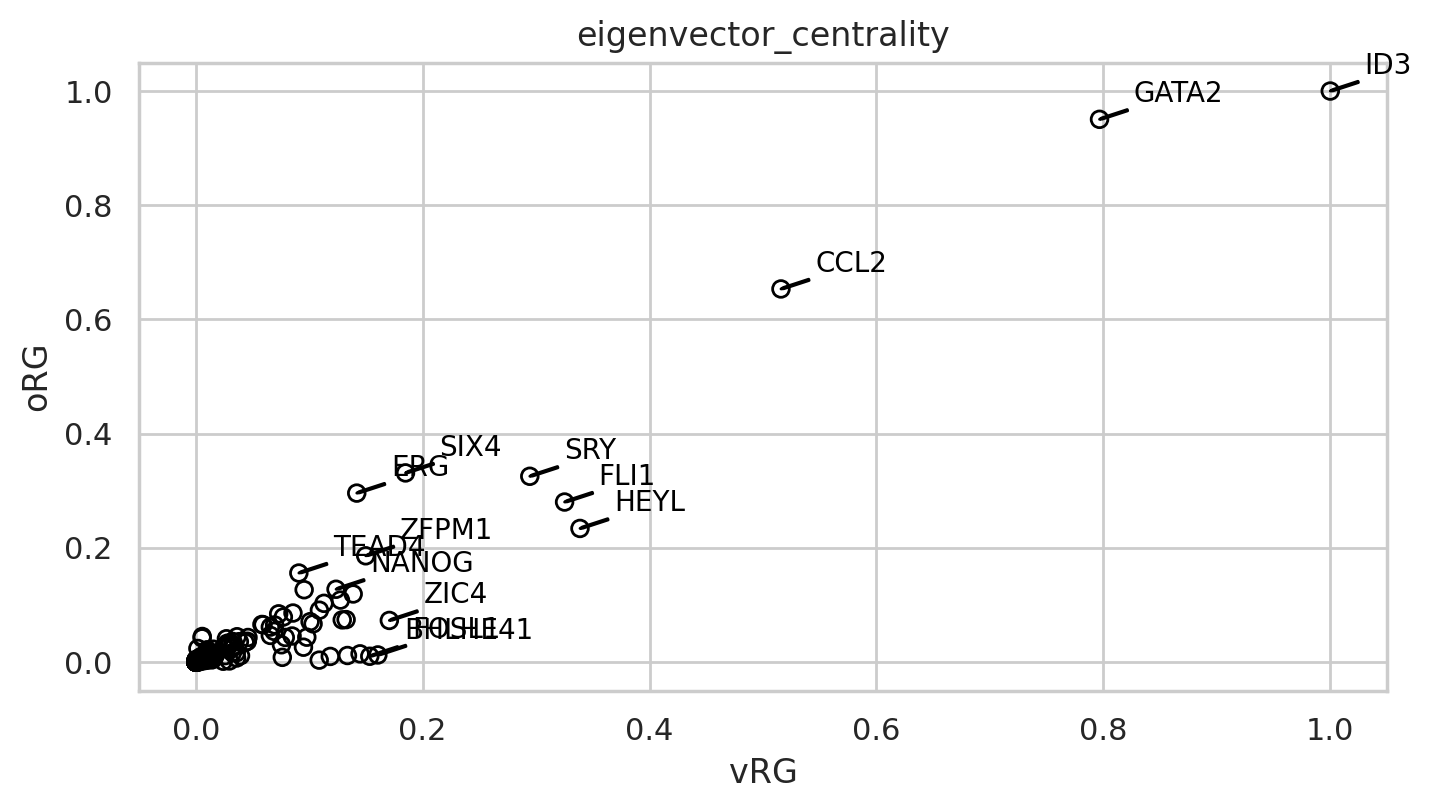

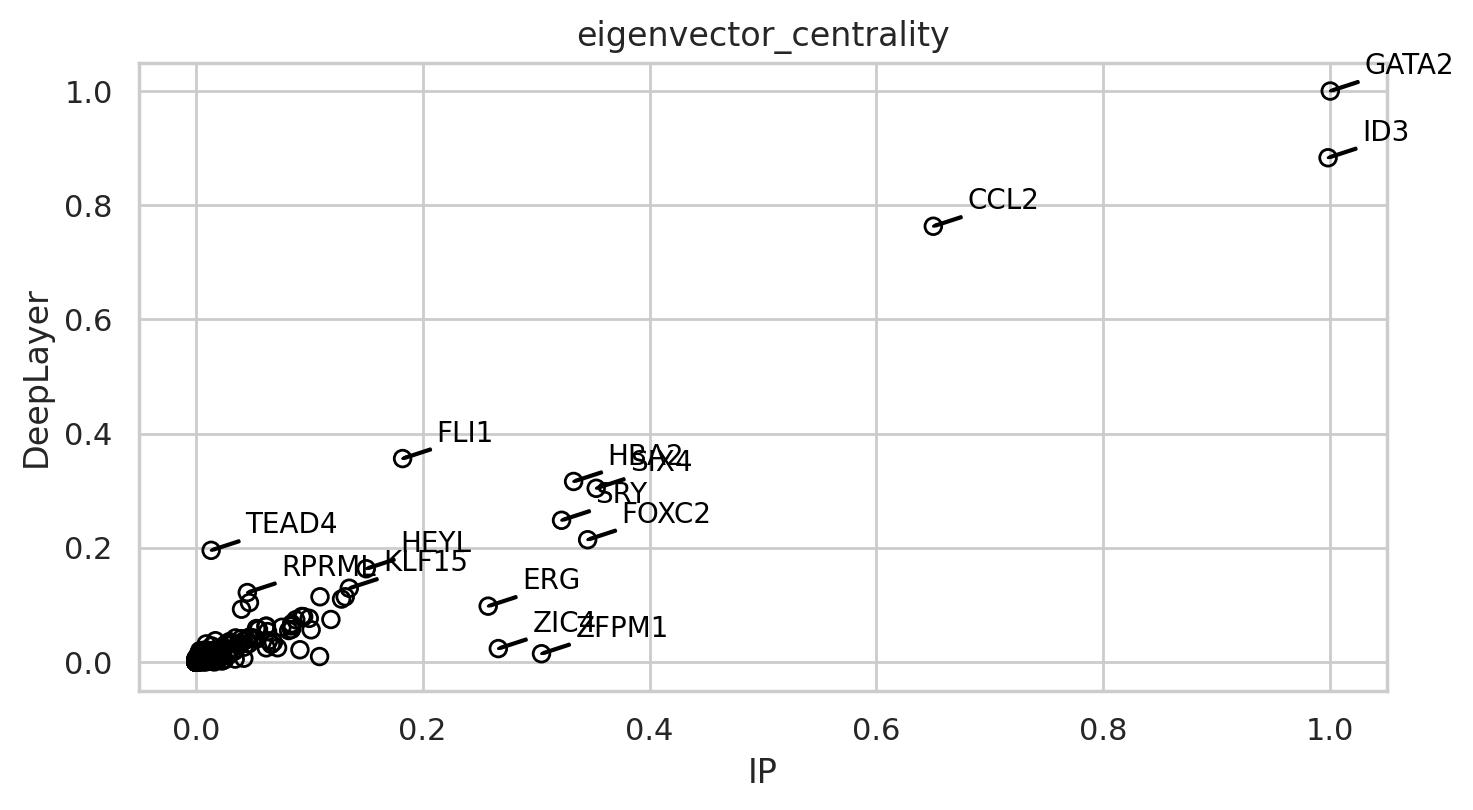

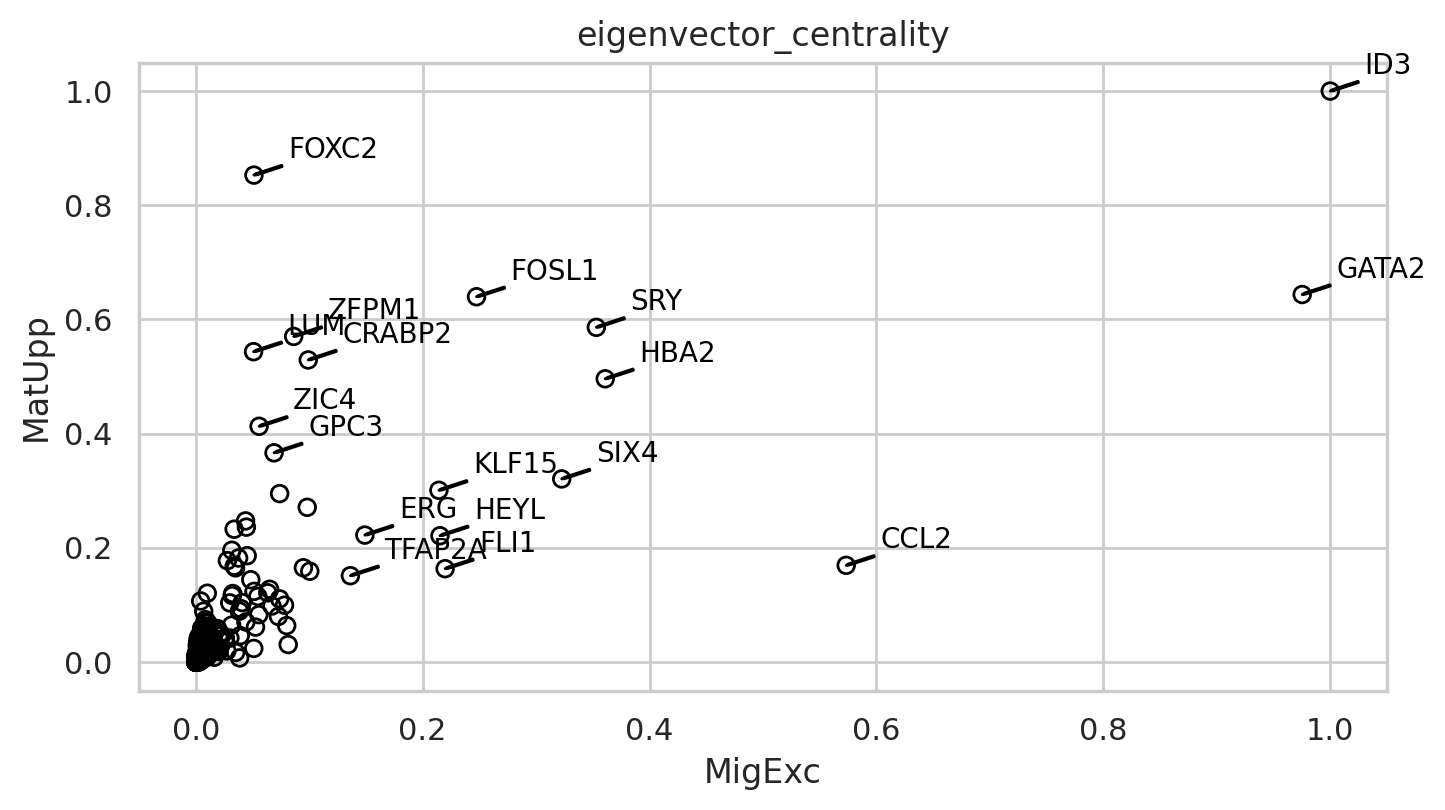

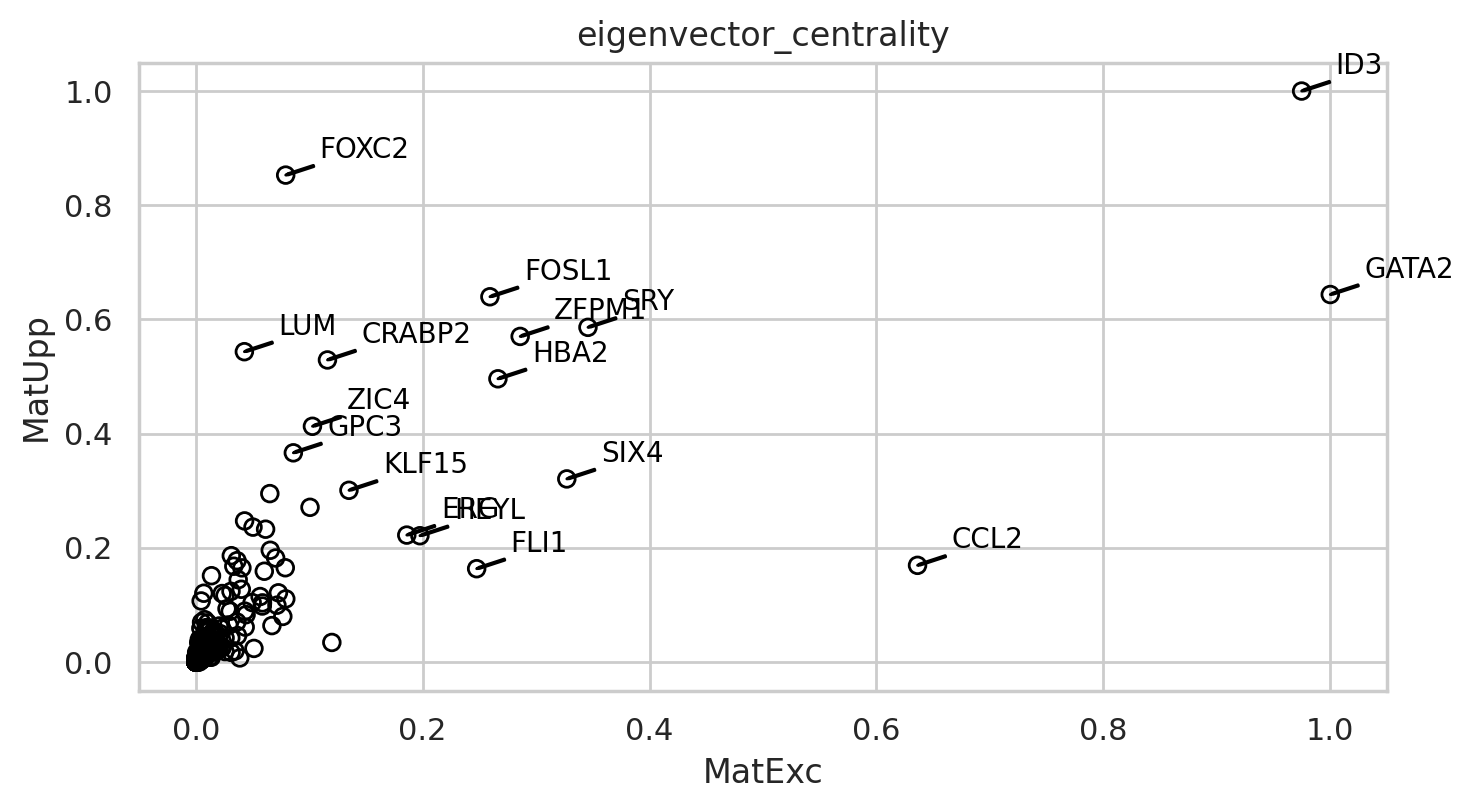

In [33]:
plt.rcParams["figure.figsize"] = [8, 4]
# Compare GRN score between two clusters
links.plot_score_comparison_2D(value="eigenvector_centrality",
                               cluster1="vRG", cluster2="oRG",
                               percentile=98,
                               save=f"{save_folder}/score_comparison_vRG_oRG")

plt.rcParams["figure.figsize"] = [8, 4]
# Compare GRN score between two clusters
links.plot_score_comparison_2D(value="eigenvector_centrality",
                               cluster1="IP", cluster2="DeepLayer",
                               percentile=98,
                               save=f"{save_folder}/score_comparison_IP_DeepLayer")

plt.rcParams["figure.figsize"] = [8, 4]
# Compare GRN score between two clusters
links.plot_score_comparison_2D(value="eigenvector_centrality",
                               cluster1="MigExc", cluster2="MatUpp",
                               percentile=98,
                               save=f"{save_folder}/score_comparison_ExcMig_MatUpp")

plt.rcParams["figure.figsize"] = [8, 4]
# Compare GRN score between two clusters
links.plot_score_comparison_2D(value="eigenvector_centrality",
                               cluster1="MatExc", cluster2="MatUpp",
                               percentile=98,
                               save=f"{save_folder}/score_comparison_Mat_Up")


KLF6


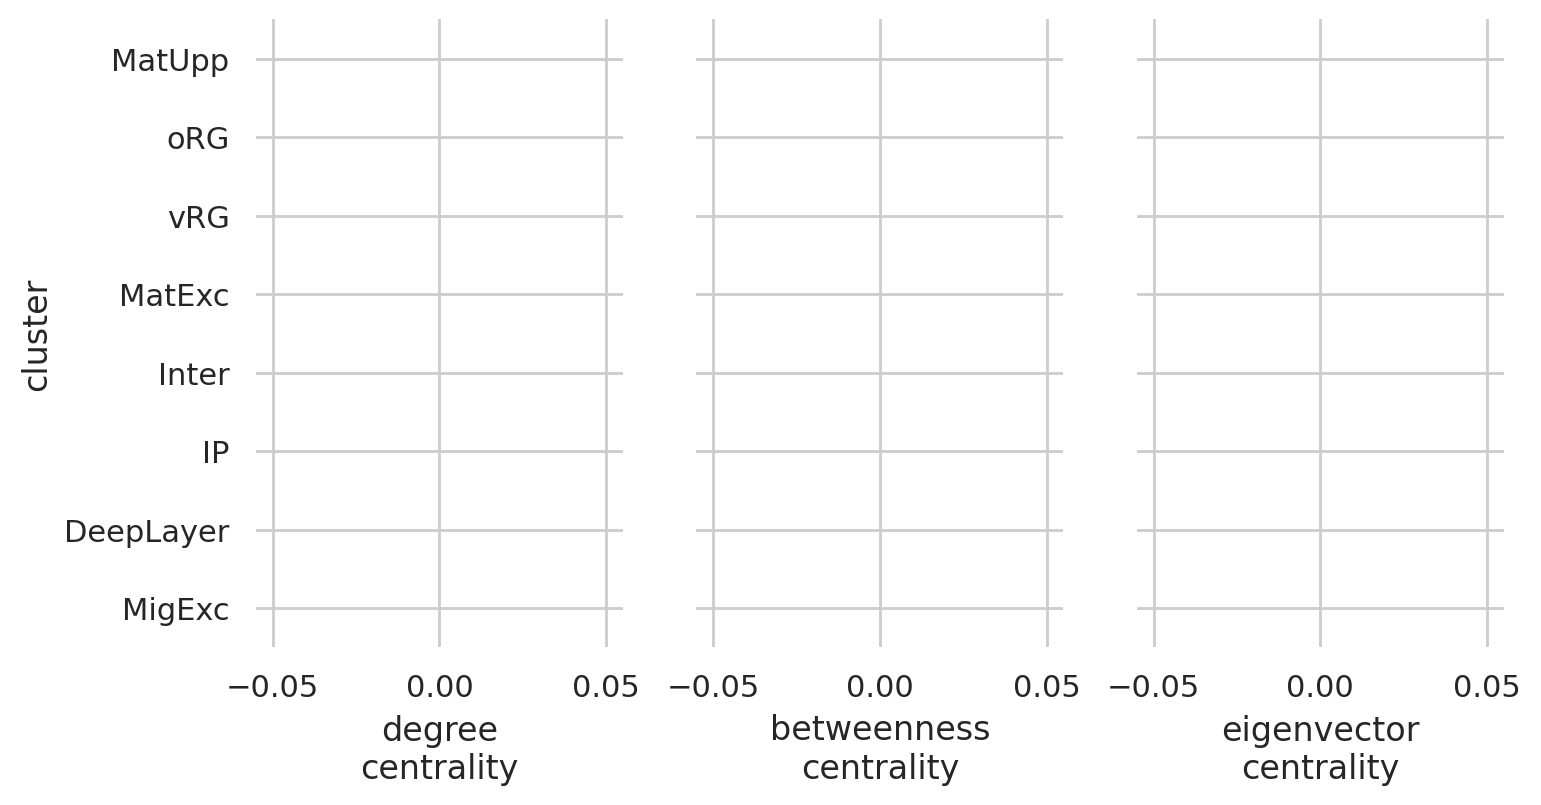

EOMES


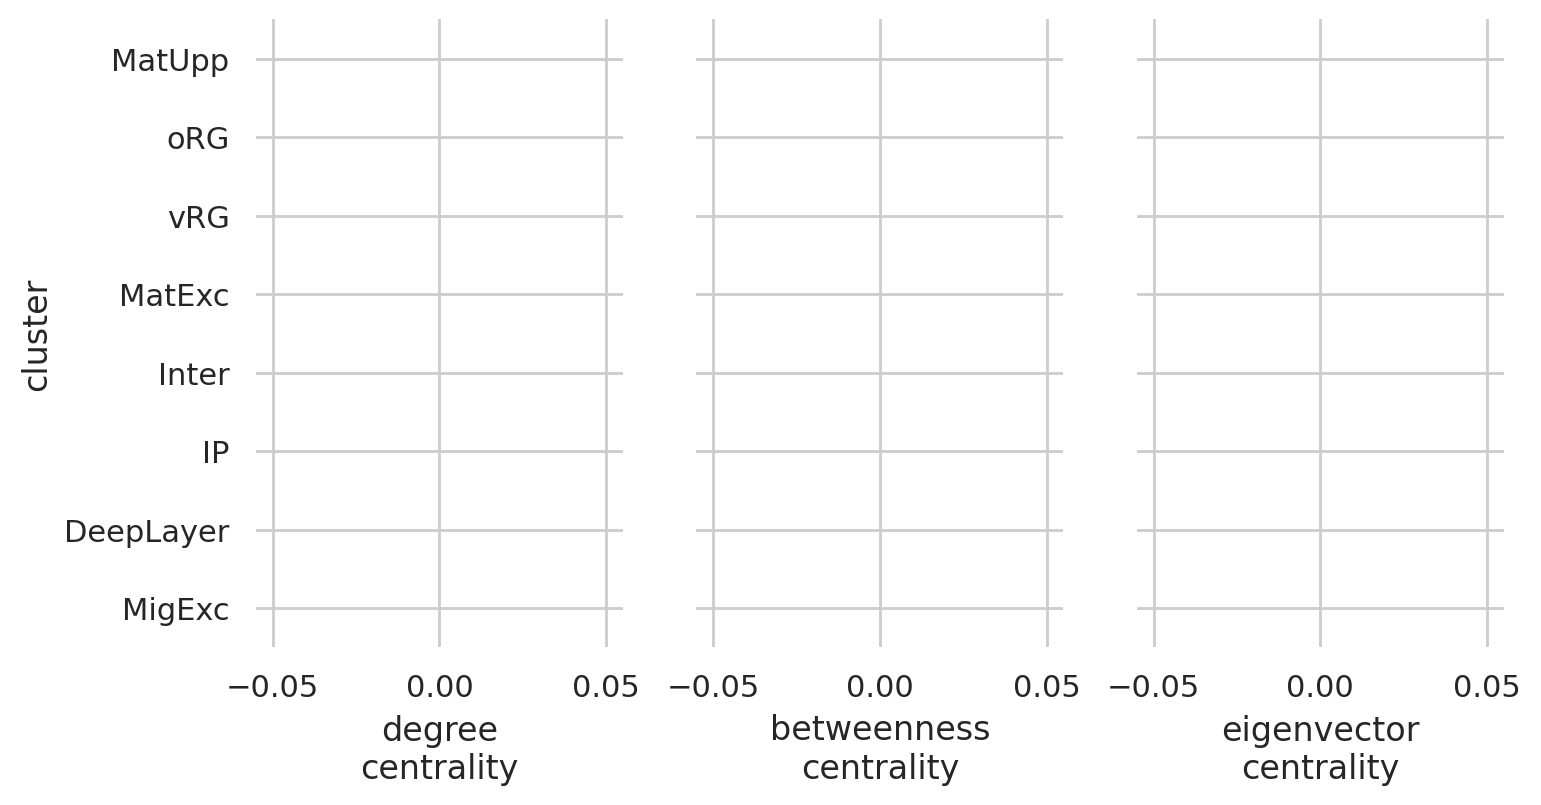

FOXG1


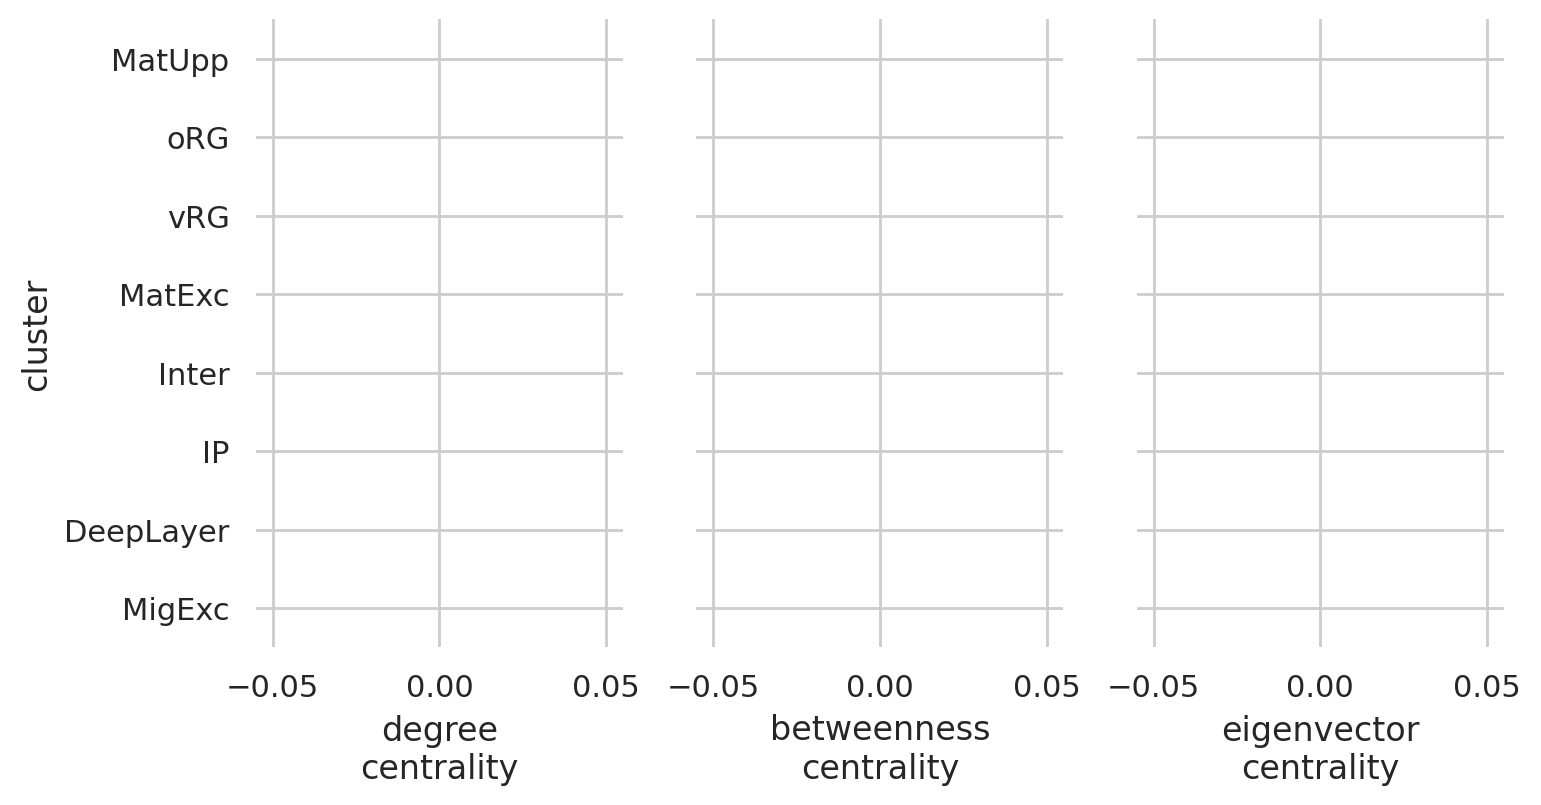

NANOG


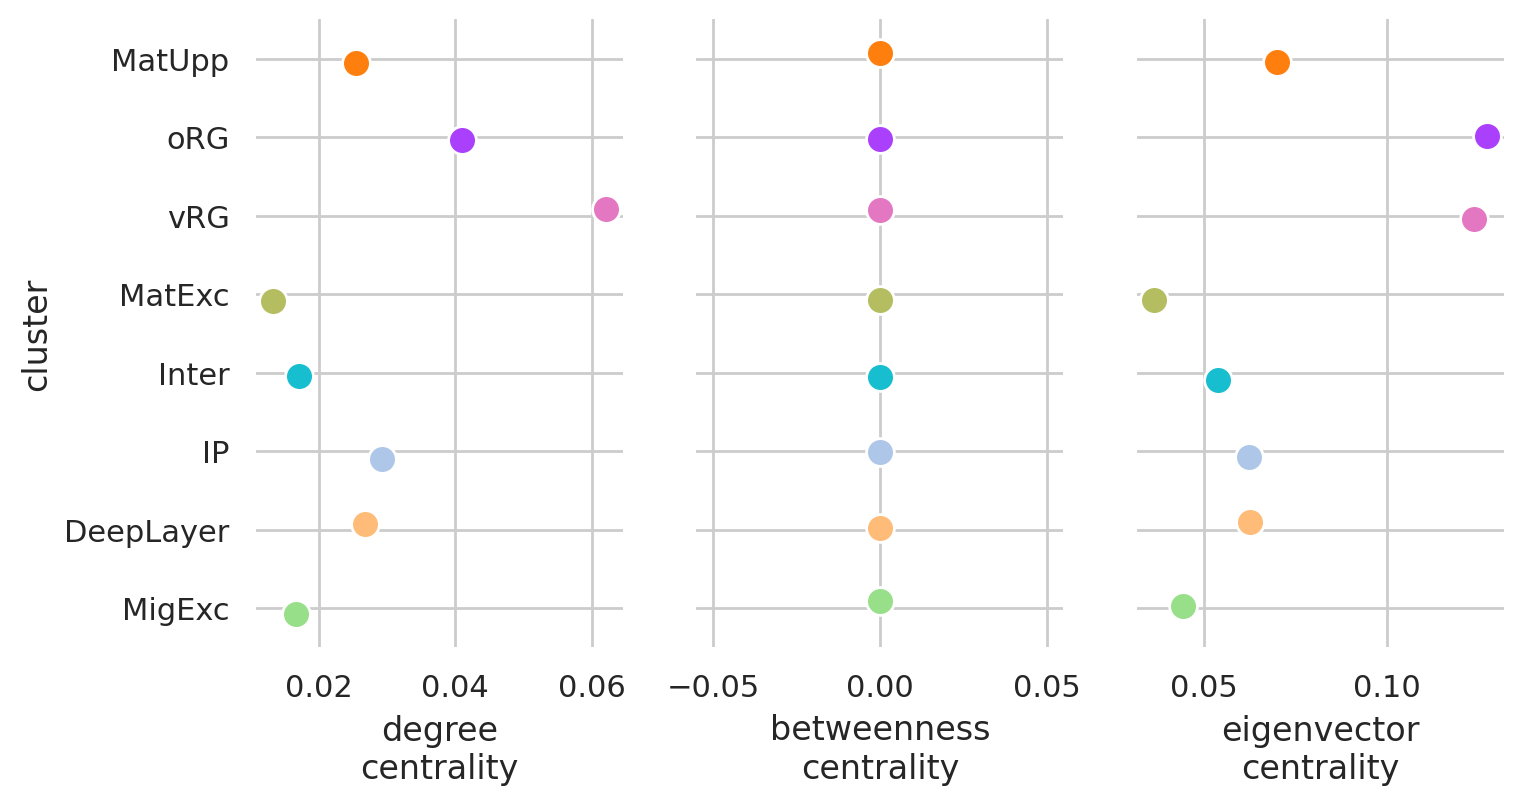

POU5F1


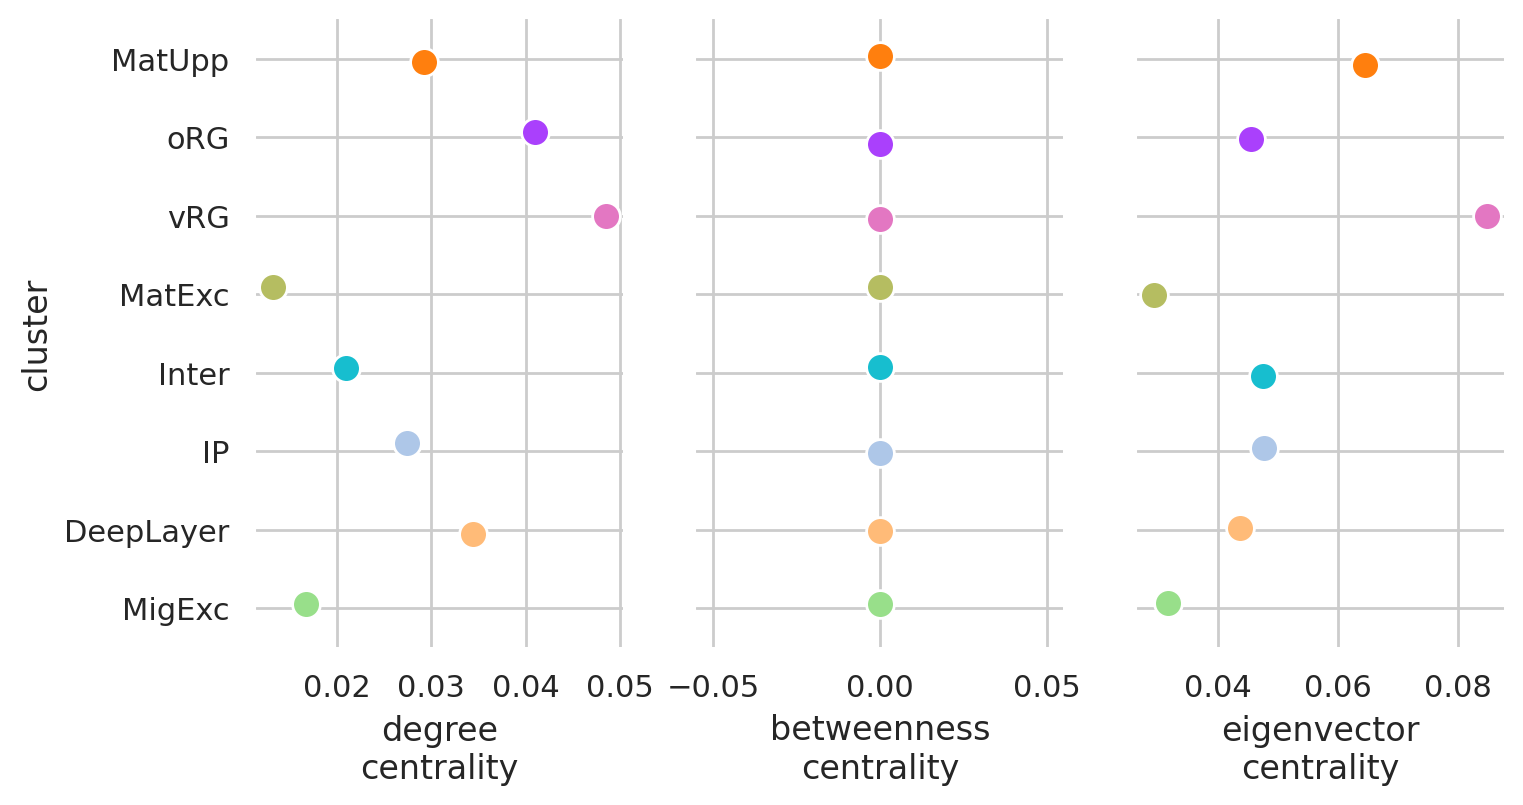

TBR1


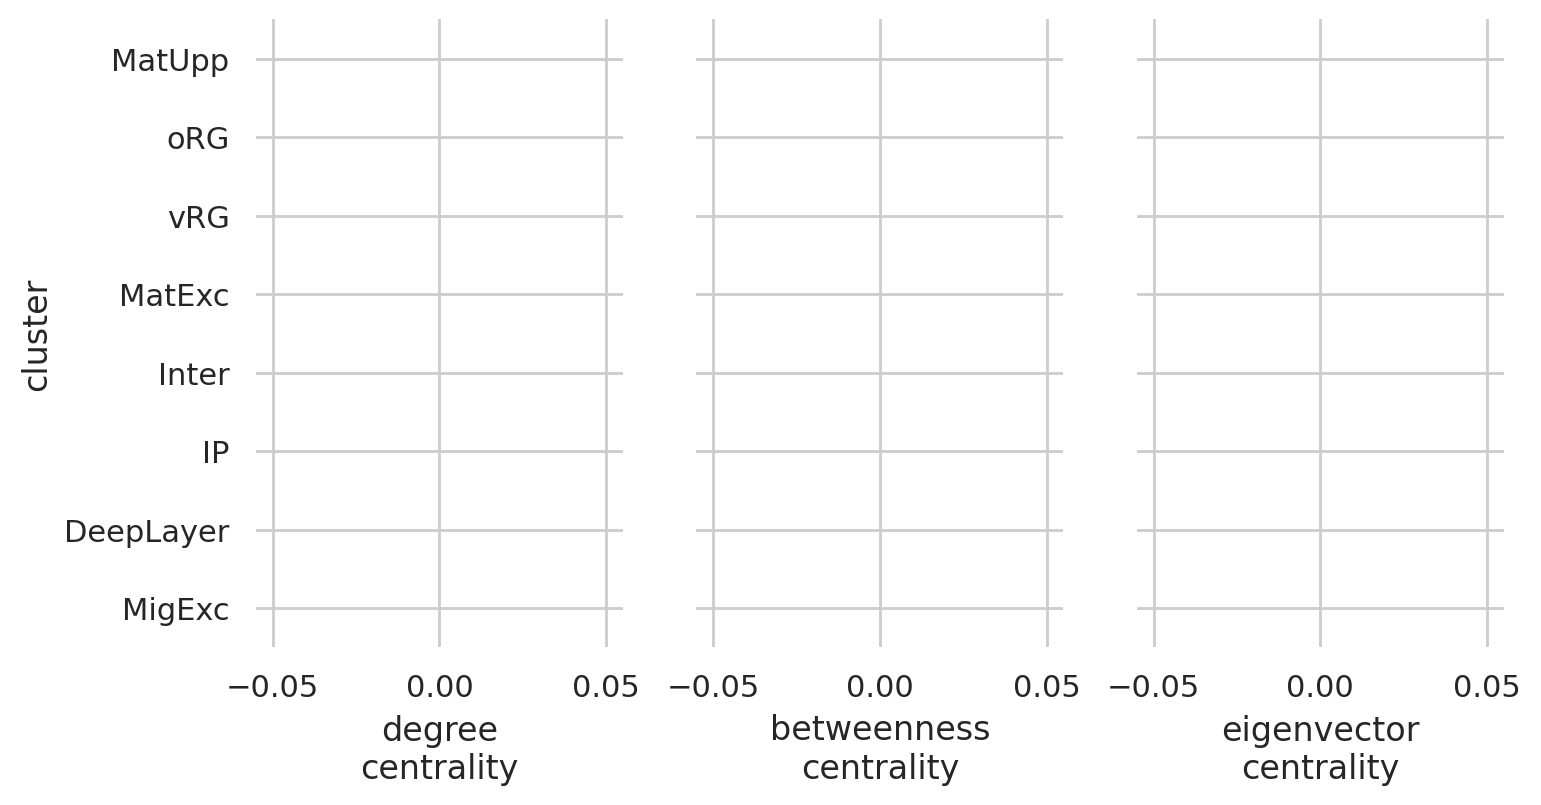

SATB2


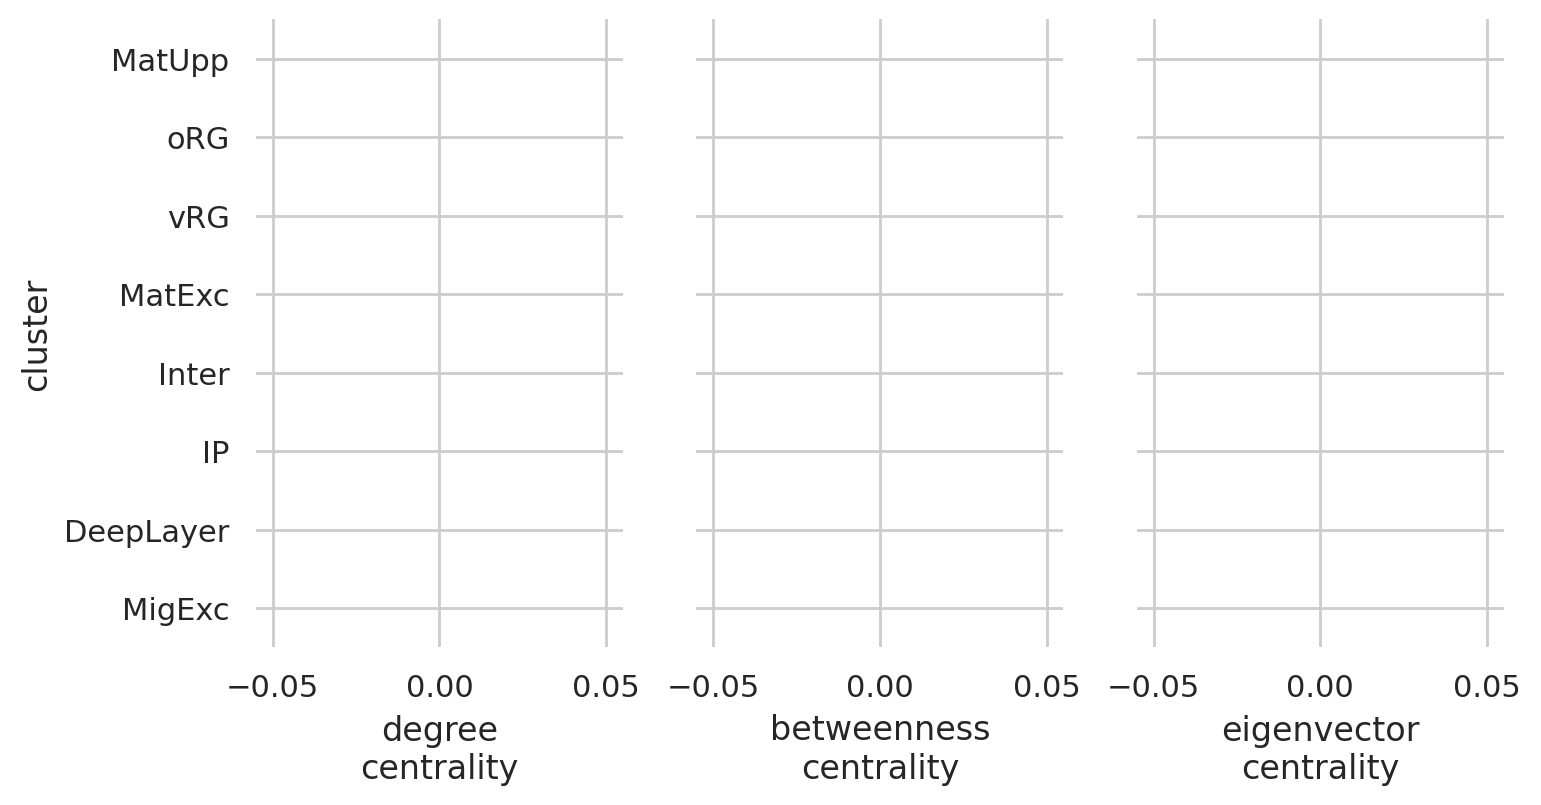

EMX1


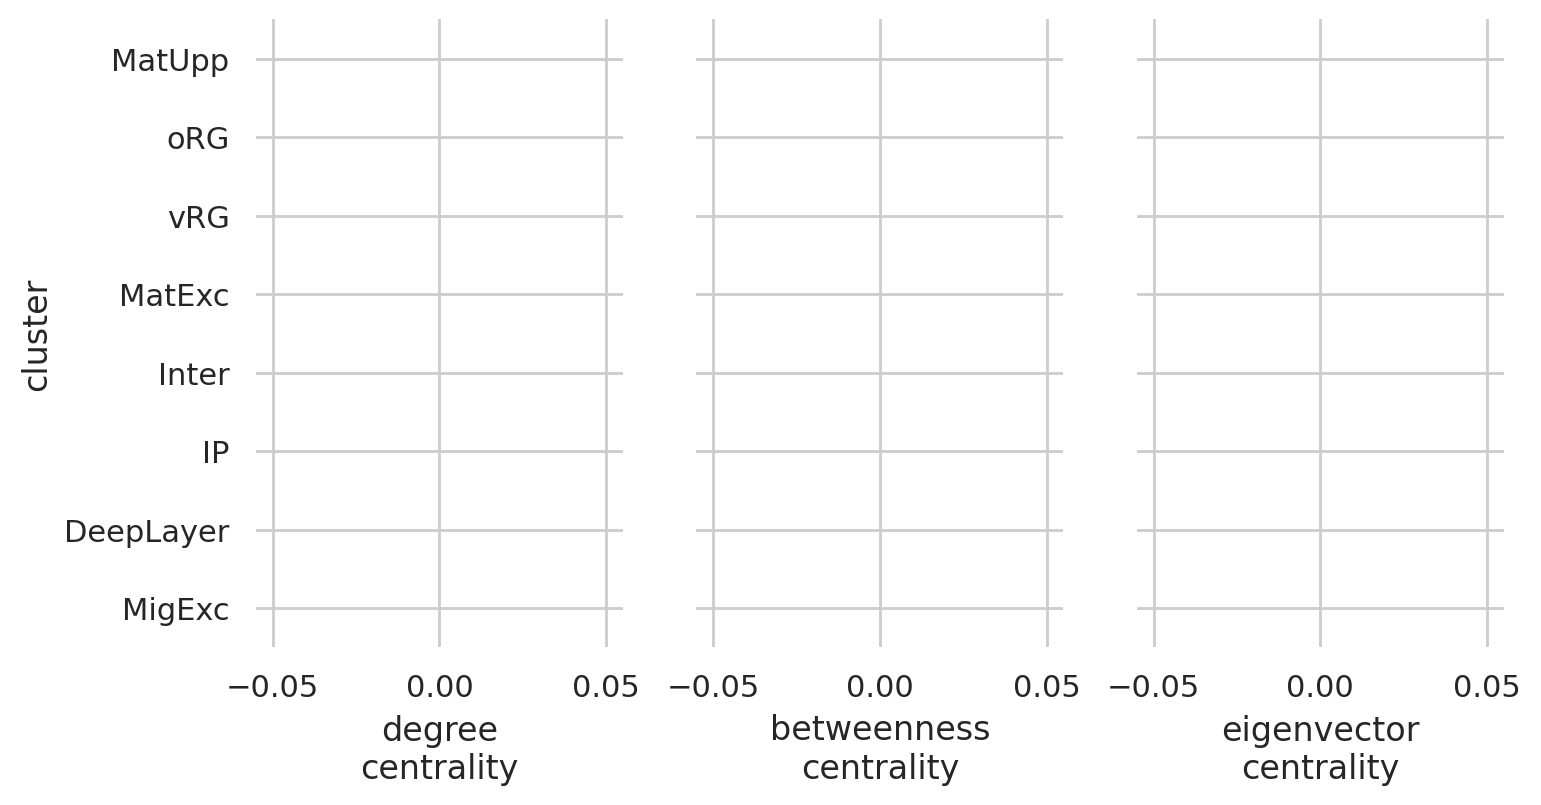

EMX2


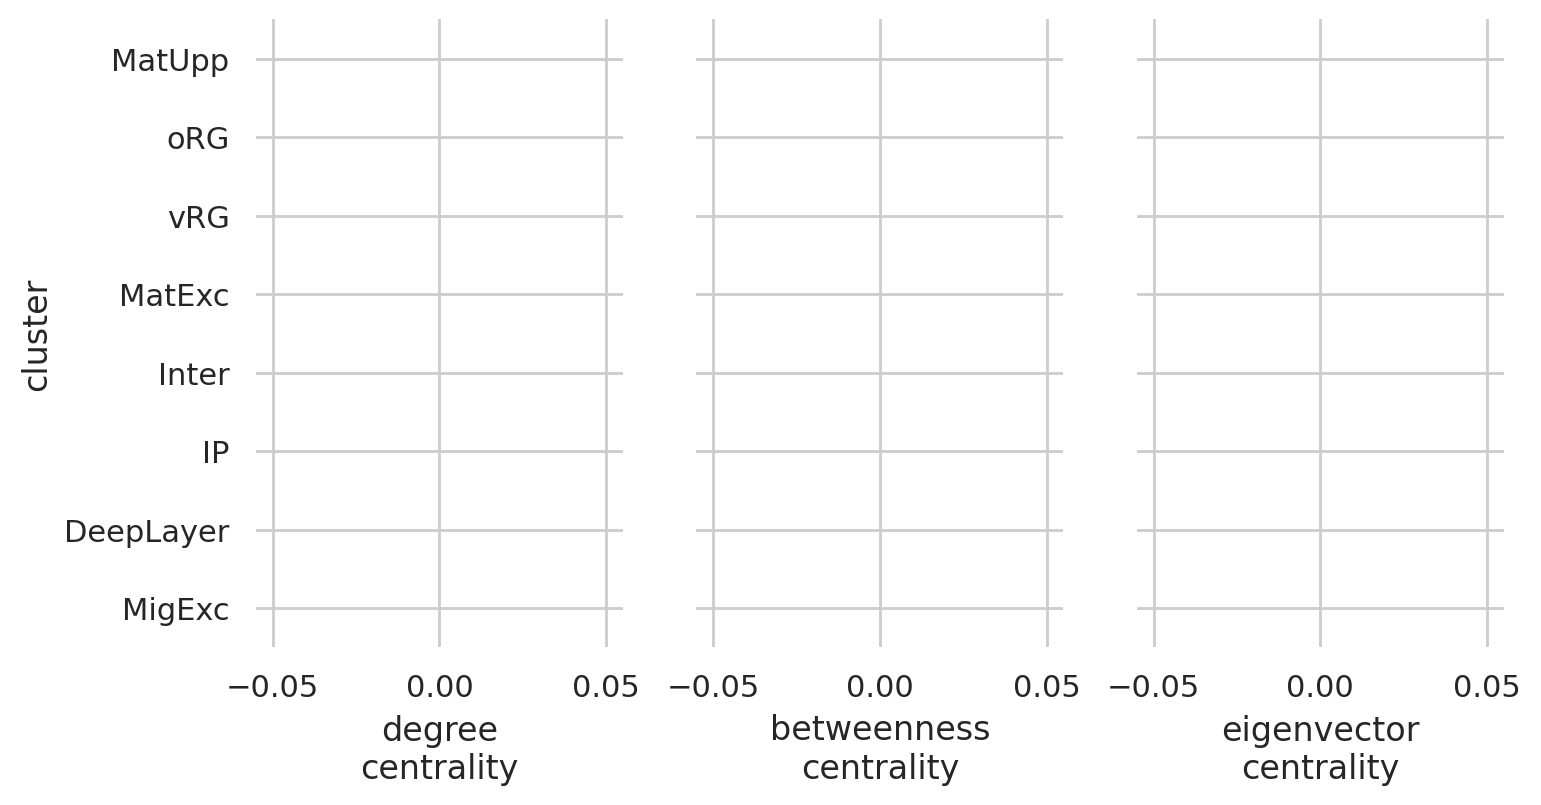

SOX2


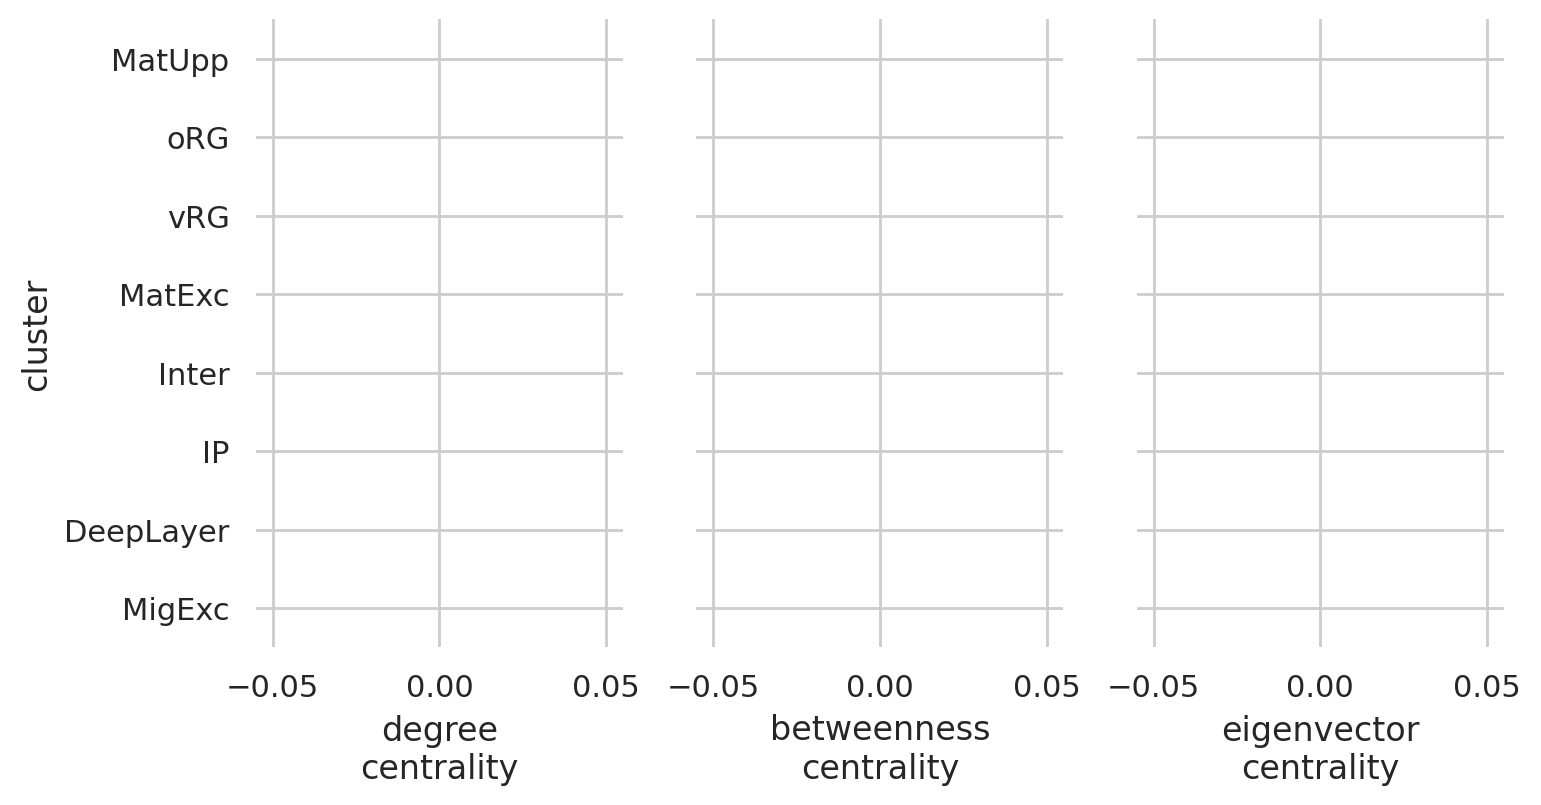

SOX4


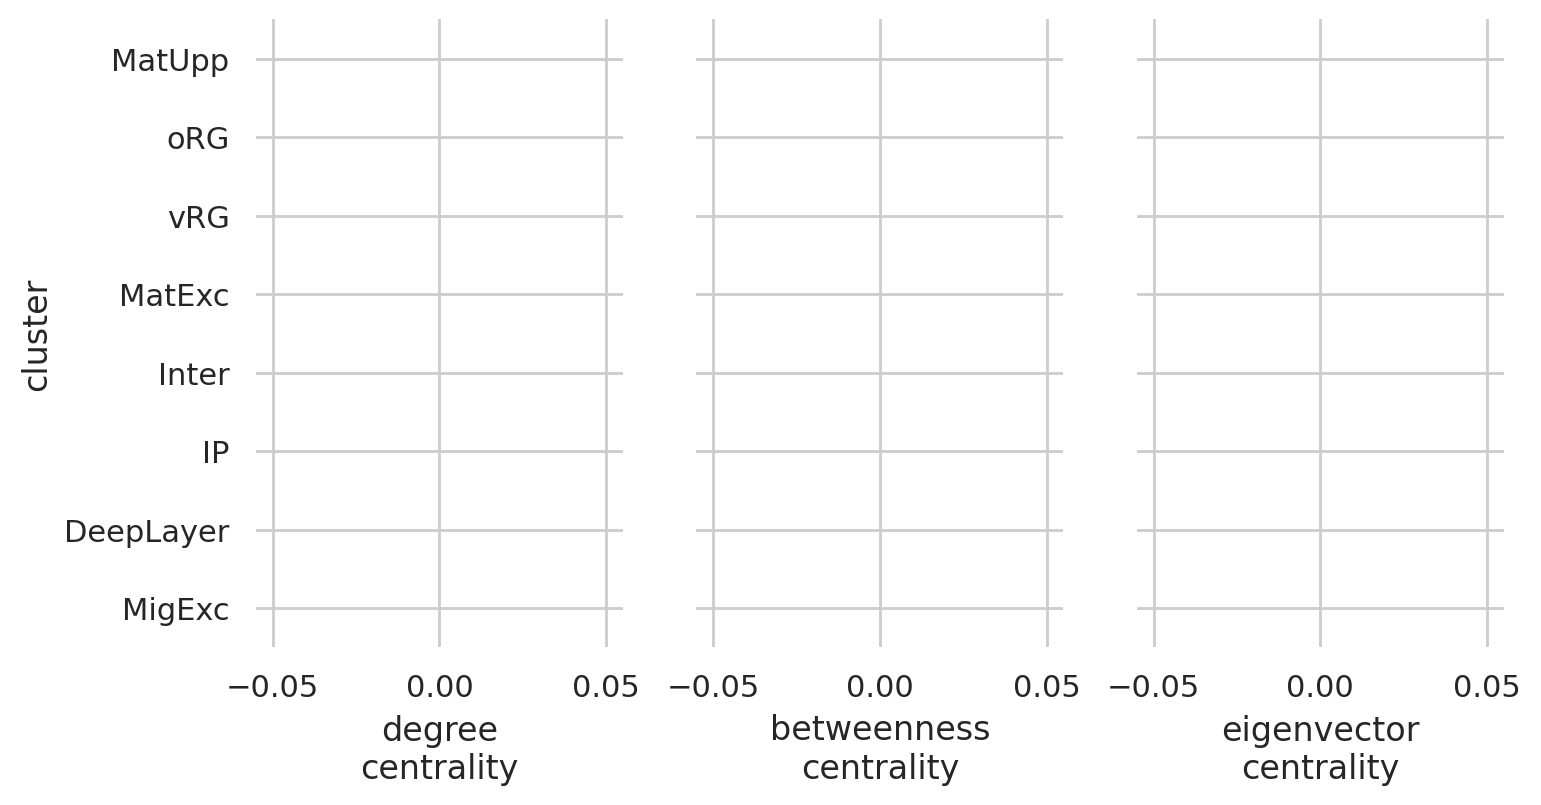

SOX11


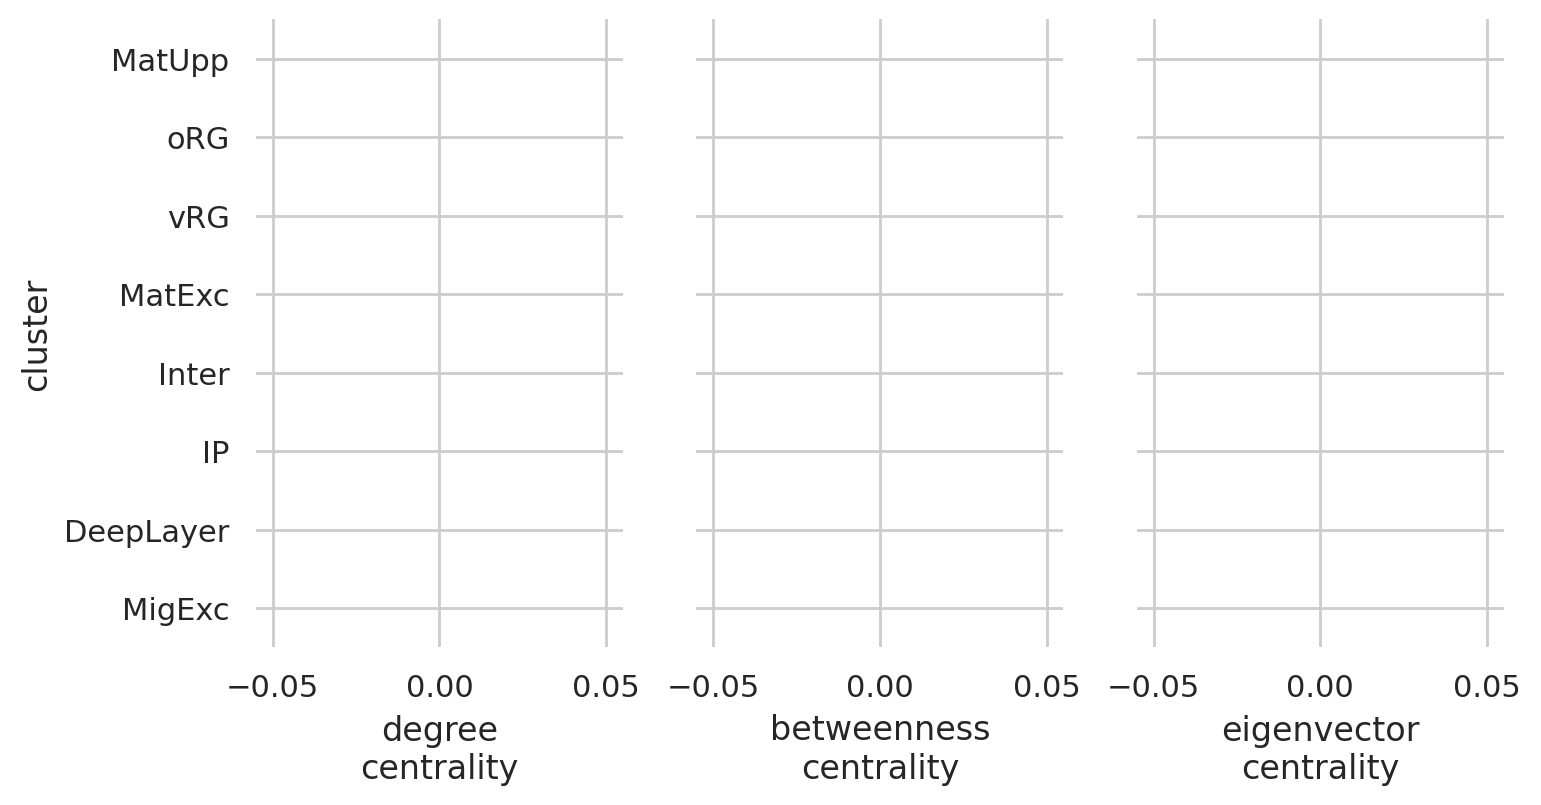

PAX6


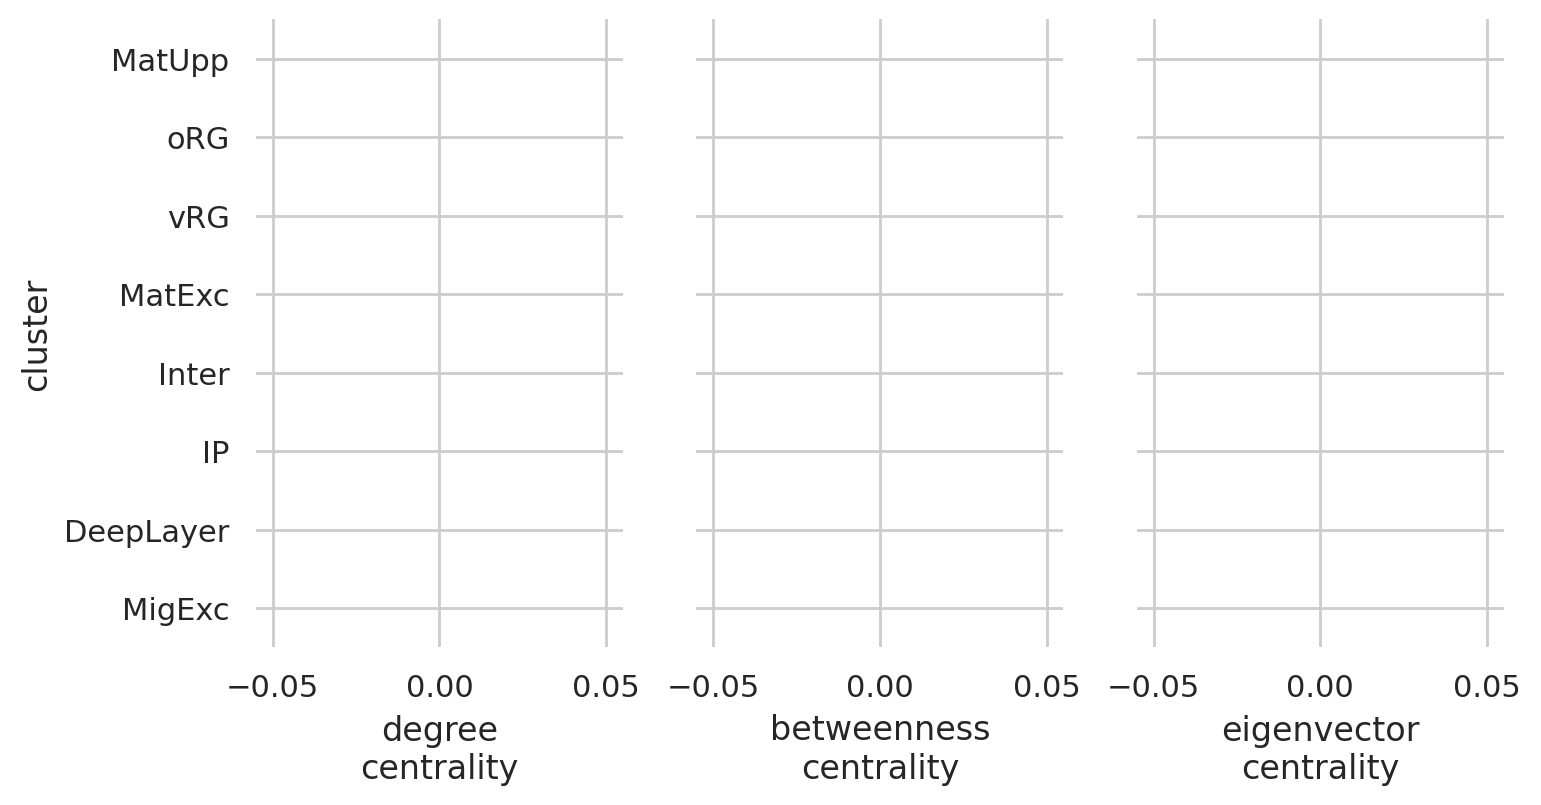

PAX8


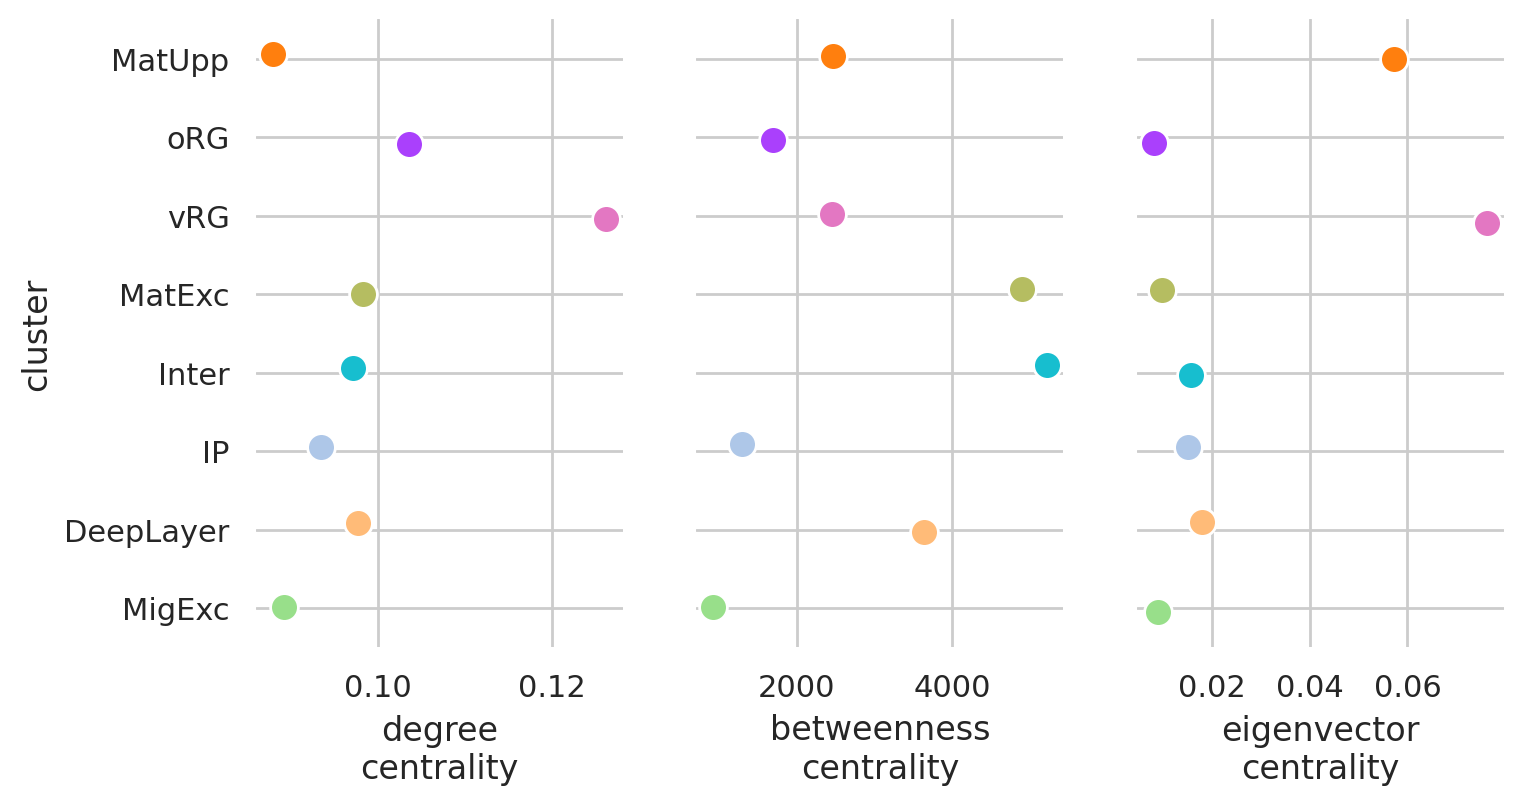

In [35]:
links.plot_score_per_cluster(goi="KLF6", save=f"{save_folder}/network_score_per_KLF6/")
links.plot_score_per_cluster(goi="EOMES", save=f"{save_folder}/network_score_per_EOMES/")
links.plot_score_per_cluster(goi="FOXG1", save=f"{save_folder}/network_score_per_FOXG1/")
links.plot_score_per_cluster(goi="NANOG", save=f"{save_folder}/network_score_per_NANOG/")
links.plot_score_per_cluster(goi="POU5F1", save=f"{save_folder}/network_score_per_POU5F1/")
links.plot_score_per_cluster(goi="TBR1", save=f"{save_folder}/network_score_per_TBR1/")
links.plot_score_per_cluster(goi="SATB2", save=f"{save_folder}/network_score_per_SATB2/")
links.plot_score_per_cluster(goi="EMX1", save=f"{save_folder}/network_score_per_EMX1/")
links.plot_score_per_cluster(goi="EMX2", save=f"{save_folder}/network_score_per_EMX2/")
links.plot_score_per_cluster(goi="SOX2", save=f"{save_folder}/network_score_per_SOX2/")
links.plot_score_per_cluster(goi="SOX4", save=f"{save_folder}/network_score_per_SOX4/")
links.plot_score_per_cluster(goi="SOX11", save=f"{save_folder}/network_score_per_SOX11/")
links.plot_score_per_cluster(goi="PAX6", save=f"{save_folder}/network_score_per_PAX6/")
links.plot_score_per_cluster(goi="PAX8", save=f"{save_folder}/network_score_per_PAX8/")

(0.0, 0.08)

degree_centrality_all


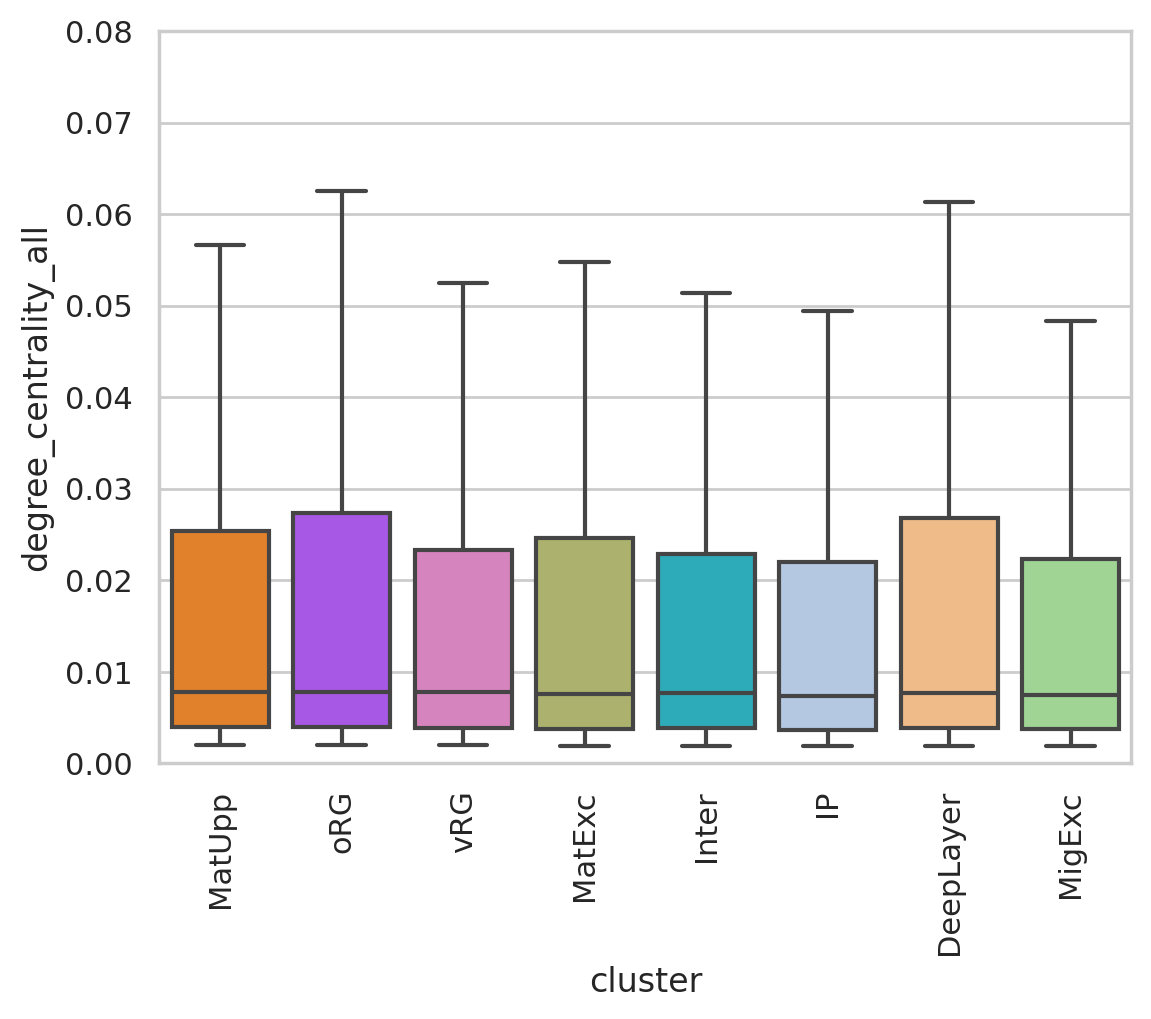

(0.0, 0.05)

eigenvector_centrality


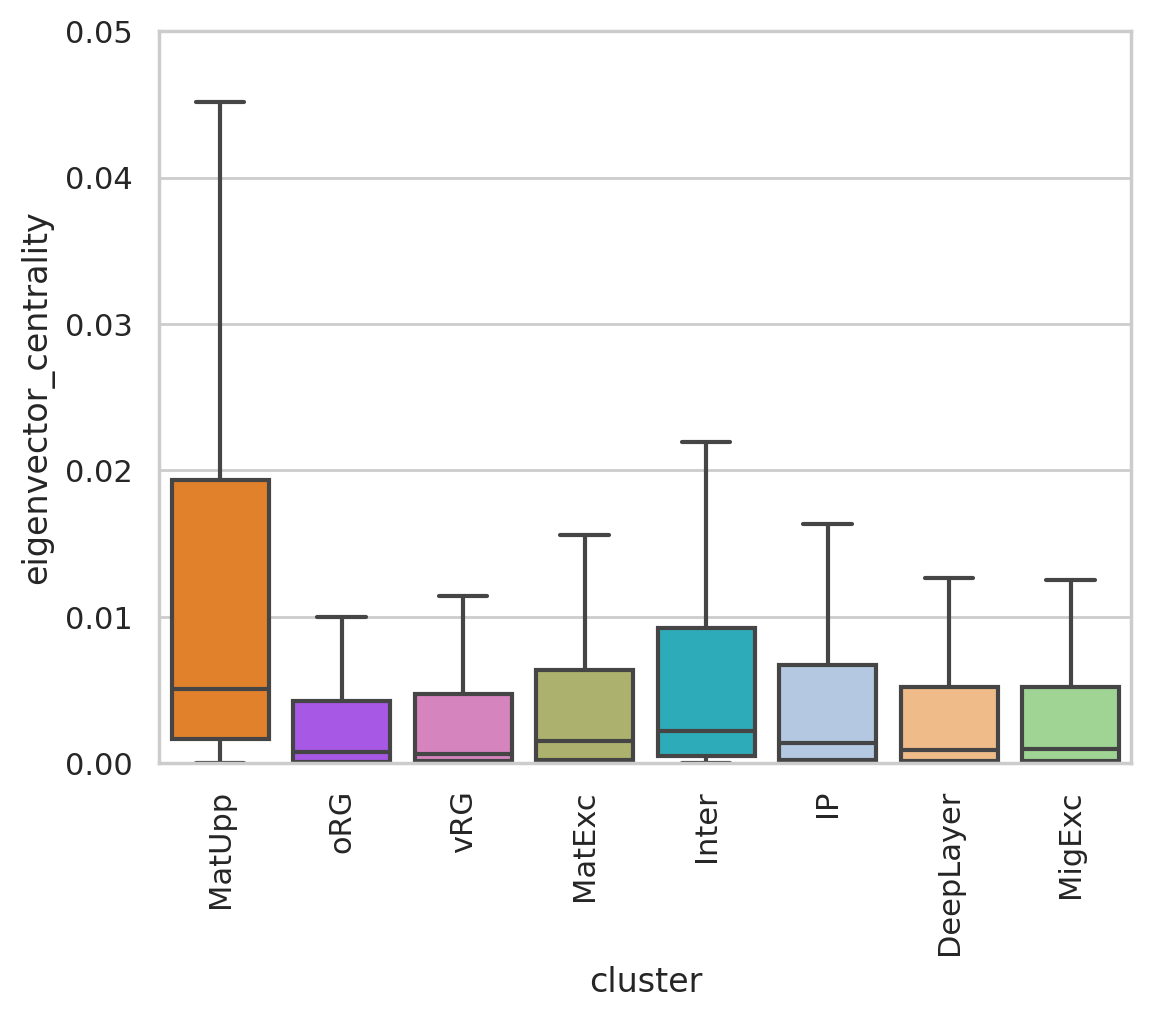

(0.0, 1.0)

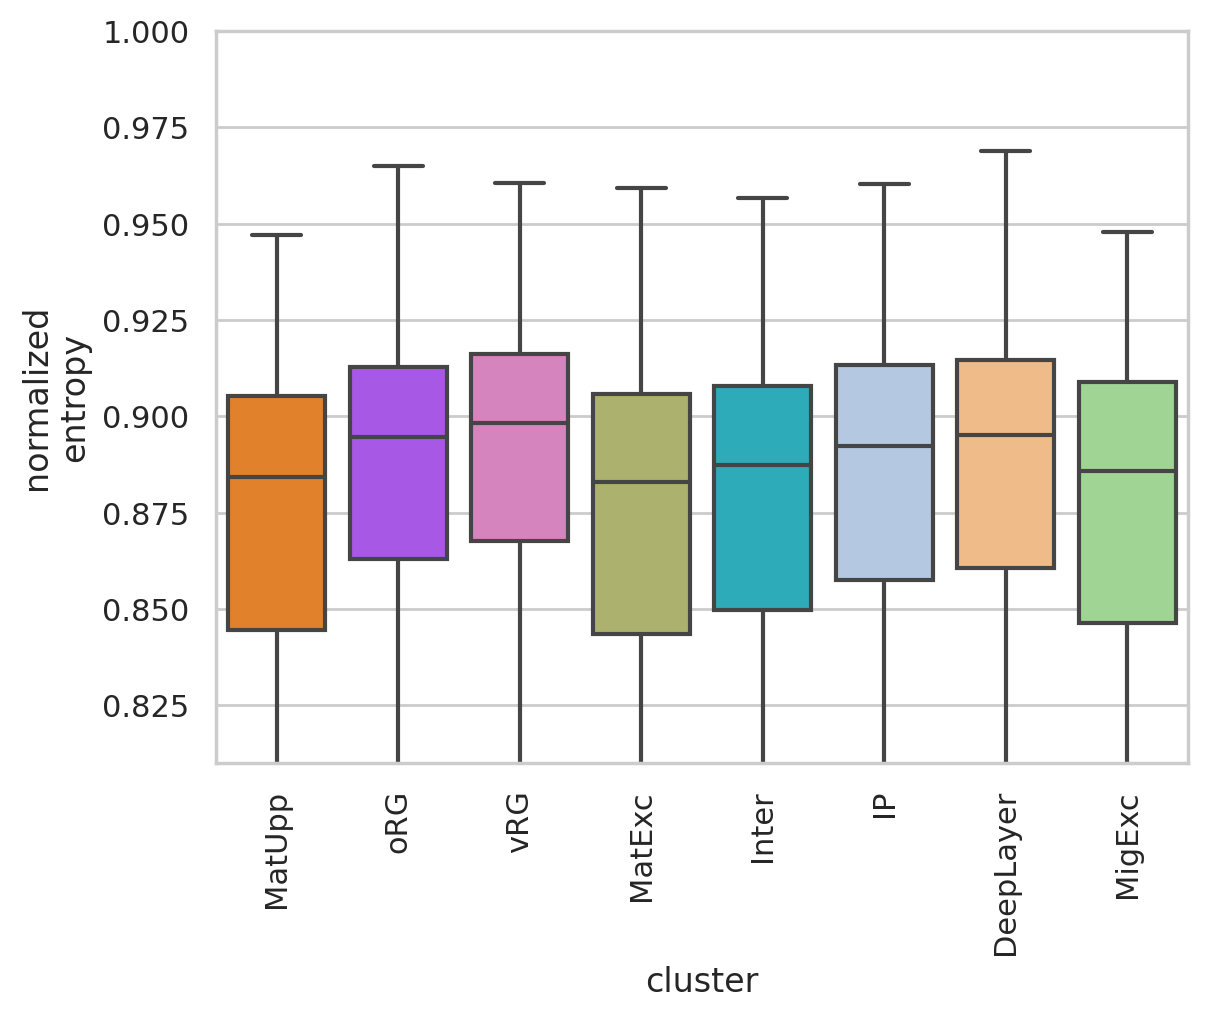

In [27]:
plt.rcParams["figure.figsize"] = [6, 6]

# Plot degree_centrality
plt.subplots_adjust(left=0.15, bottom=0.3)
plt.ylim([0,0.08])
links.plot_score_discributions(values=["degree_centrality_all"],
                               method="boxplot",
                               save=f"{save_folder}",
                              )

# Plot eigenvector_centrality
plt.subplots_adjust(left=0.15, bottom=0.3)
plt.ylim([0, 0.05])
links.plot_score_discributions(values=["eigenvector_centrality"],
                               method="boxplot",
                               save=f"{save_folder}")

plt.subplots_adjust(left=0.15, bottom=0.3)
plt.ylim([0, 1])
links.plot_network_entropy_distributions(save=f"{save_folder}")